In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from currency_converter import CurrencyConverter
from matplotlib import pyplot as plt

# Clustering Analysis Tools
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

# Content for the Bokeh Models
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap
from bokeh.io import output_file, show
from bokeh.transform import transform
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.layouts import column
from bokeh.models import RadioButtonGroup
from bokeh.models import TextInput
from bokeh.layouts import gridplot
from bokeh.models import Div
from bokeh.models import Paragraph
from bokeh.layouts import column, widgetbox

### Pre-processing Helper Functions

In [2]:
# Currency Converter (developed by Jingjing)
def convert_others_to_usd(symbol:str, old_value:float):
    #currency rates are found in the website: https://www.xe.com/currencyconverter/convert/?Amount=1&From=DEM&To=USD
    currencies = {
        'DEM': 0.61261302,
        'FRF': 0.182659,
        'ITL': 0.000618802,
        'BEF': 0.0297018,
        'ESP': 0.00720113,
        'ATS': 0.0870742, 
        'FIM': 0.201517,
        'CLP': 0.00142245,
        'NGN': 0.0026280674,
        'ARS': 0.010775668,
        'DOP': 0.017537532
    }

    if symbol in currencies:
        converted_value = currencies[symbol] * old_value
    else:
        converted_value = c.convert(old_value, symbol, 'USD')
    
    return converted_value

# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='micro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='micro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='micro')) * 100), "%")
    
# Function to convert to lowercase
def lower_case(input_str):
    input_str = input_str.lower()

    return(input_str)

## Pre-processing of all Data for analysis

### First the 'Movies' dataset that contains generic information about the films

In [3]:
# First Read it in
movies_df = pd.read_csv('IMDb movies.csv')

# Rename Columns and convert data types where appropriate
movies_df = movies_df.astype(
    {
     'duration' : 'float',
     'avg_vote' : 'float',
     'votes' : 'float',
#      'budget' : 'float', # Need this to replace '$ \d+' with float(\d+)
#      'usa_gross_income' : 'float', # Need this to replace '$ \d+' with float(\d+)
#      'worlwide_gross_income' : 'float', # Need this to replace '$ \d+' with float(\d+)
     'metascore' : 'float',
     'reviews_from_users' : 'float',
     'reviews_from_critics' : 'float'
    }).rename(columns=
    {'imdb_title_id' : 'title_id',
     'reviews_from_users' : 'user_reviews',
     'reviews_from_critics' : 'critic_reviews',
     'worlwide_gross_income' : 'ww_gross_income'
    })

# Drop the redundant 'title_id' field and set it as the index
movies_df = movies_df.set_index(movies_df['title_id']).rename(columns={'title_id' : 'REMOVE'}).drop(columns=['REMOVE'])

# Found a bad row that didn't contain an int for a year (or a year formatted as such)
movies_df = movies_df.drop(index=['tt8206668'], axis=1)
movies_df = movies_df.astype({'year' : 'int'})

# We also don't want any older films to keep the data relatively current
movies_df = movies_df[movies_df['year'] > 1969]

# Only consider films with over 10000 votes
# movies_df = movies_df[movies_df['votes'] >= 1000]

# Now print a quick summary
print(f'Shape: {movies_df.shape} \n{movies_df.columns}')
movies_df.head(2)

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Shape: (70263, 21) 
Index(['title', 'original_title', 'year', 'date_published', 'genre',
       'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'ww_gross_income', 'metascore',
       'user_reviews', 'critic_reviews'],
      dtype='object')


title          original_title  year  \
title_id                                                          
tt0017938  La glace à trois faces  La glace à trois faces  1983   
tt0035423          Kate & Leopold          Kate & Leopold  2001   

          date_published                     genre  duration country  \
title_id                                                               
tt0017938     1983-03-13            Drama, Romance      45.0  France   
tt0035423     2002-03-01  Comedy, Fantasy, Romance     118.0     USA   

                  language       director                        writer  ...  \
title_id                                                                 ...   
tt0017938     None, French   Jean Epstein     Jean Epstein, Paul Morand  ...   
tt0035423  English, French  James Mangold  Steven Rogers, James Mangold  ...   

                                                      actors  \
title_id                                                       
tt0017938  Jeanne Helbling, Suzy Pierson, Olga Day, Raymo...   
tt0035423  Meg Ryan, Hugh Jackman, Liev Schreiber, Brecki...   

                                                 description avg_vote  \
title_id                                                                
tt0017938  Psychological narrative avantgarde film about ...      7.0   
tt0035423  An English Duke from 1876 is inadvertedly drag...      6.4   

             votes      budget usa_gross_income ww_gross_income metascore  \
title_id                                                                    
tt0017938    759.0         NaN              NaN             NaN       NaN   
tt0035423  77852.0  $ 48000000       $ 47121859      $ 76019048      44.0   

           user_reviews  critic_reviews  
title_id                                 
tt0017938           7.0             4.0  
tt0035423         341.0           115.0  

[2 rows x 21 columns]

#### Currency Conversion; based on Jingjing's Pre-processing

In [4]:
# Currency Converter
c = CurrencyConverter()

movies_df.dropna(inplace = True)

# For each of the dollar amount attributes, we will be converting to USD
movies_df['budget_symbol'], movies_df['budget_loc_currency'] = movies_df['budget'].str.split(' ', 1).str
movies_df['budget_symbol'] = movies_df['budget_symbol'].str.replace('$','USD')
movies_df['budget_symbol'] = movies_df['budget_symbol'].str.replace('RUR','RUB')
movies_df['budget_loc_currency'] = movies_df['budget_loc_currency'].astype(float)
movies_df['budget_usd_currency'] = movies_df.apply(lambda movies_df: convert_others_to_usd(movies_df['budget_symbol'], movies_df['budget_loc_currency']), axis=1)

movies_df['usa_income_symbol'], movies_df['usa_income_loc_currency'] = movies_df['usa_gross_income'].str.split(' ', 1).str
movies_df['usa_income_symbol'] = movies_df['usa_income_symbol'].str.replace('$','USD')
movies_df['usa_income_symbol'] = movies_df['usa_income_symbol'].str.replace('RUR','RUB')
movies_df['usa_income_loc_currency'] = movies_df['usa_income_loc_currency'].astype(float)
movies_df['usa_income_usd_currency'] = movies_df.apply(lambda movies_df: convert_others_to_usd(movies_df['usa_income_symbol'], movies_df['usa_income_loc_currency']), axis=1)

movies_df['worldwide_income_symbol'], movies_df['worldwide_income_loc_currency'] = movies_df['ww_gross_income'].str.split(' ', 1).str
movies_df['worldwide_income_symbol'] = movies_df['worldwide_income_symbol'].str.replace('$','USD')
movies_df['worldwide_income_symbol'] = movies_df['worldwide_income_symbol'].str.replace('RUR','RUB')
movies_df['worldwide_income_loc_currency'] = movies_df['worldwide_income_loc_currency'].astype(float)
movies_df['worldwide_income_usd_currency'] = movies_df.apply(lambda movies_df: convert_others_to_usd(movies_df['worldwide_income_symbol'], movies_df['worldwide_income_loc_currency']), axis=1)

# Now Remove the redundant columns since we only want the USD ones
movies_df = movies_df.drop(
    columns=['usa_gross_income', 'ww_gross_income', 'budget',
             'budget_loc_currency', 'usa_income_loc_currency',
             'worldwide_income_loc_currency', 'budget_symbol',
             'usa_income_symbol', 'worldwide_income_symbol'
            ]
)

movies_df = movies_df.rename(
    columns={'budget_usd_currency' : 'budget', 'usa_income_usd_currency' : 'usa_income', 'worldwide_income_usd_currency' : 'worldwide_income'}
)

# Now print a quick summary
print(f'Shape: {movies_df.shape} \n{movies_df.columns}')
movies_df.head(2)

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  import sys
C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  del sys.path[0]


Shape: (6525, 21) 
Index(['title', 'original_title', 'year', 'date_published', 'genre',
       'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'metascore', 'user_reviews', 'critic_reviews', 'budget', 'usa_income',
       'worldwide_income'],
      dtype='object')


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Columnar iteration over characters will be deprecated in future releases.


title             original_title  year  \
title_id                                                              
tt0035423           Kate & Leopold             Kate & Leopold  2001   
tt0065134  Gli avvoltoi hanno fame  Two Mules for Sister Sara  1970   

          date_published                     genre  duration      country  \
title_id                                                                    
tt0035423     2002-03-01  Comedy, Fantasy, Romance     118.0          USA   
tt0065134     1970-12-05   Adventure, Romance, War     116.0  USA, Mexico   

                                  language       director  \
title_id                                                    
tt0035423                  English, French  James Mangold   
tt0065134  English, Spanish, French, Latin     Don Siegel   

                                  writer  ...  \
title_id                                  ...   
tt0035423   Steven Rogers, James Mangold  ...   
tt0065134  Budd Boetticher, Albert Maltz  ...   

                                                      actors  \
title_id                                                       
tt0035423  Meg Ryan, Hugh Jackman, Liev Schreiber, Brecki...   
tt0065134  Shirley MacLaine, Clint Eastwood, Manolo Fábre...   

                                                 description avg_vote  \
title_id                                                                
tt0035423  An English Duke from 1876 is inadvertedly drag...      6.4   
tt0065134  Nun Sara (Shirley MacLaine) is on the run in M...      7.0   

             votes  metascore  user_reviews  critic_reviews      budget  \
title_id                                                                  
tt0035423  77852.0       44.0         341.0           115.0  48000000.0   
tt0065134  23223.0       62.0          79.0            39.0   2500000.0   

           usa_income  worldwide_income  
title_id                                 
tt0035423  47121859.0        76019048.0  
tt0065134   5050000.0         5050000.0  

[2 rows x 21 columns]

#### Counts of Interest

In [5]:
movies_df['genre_count'] = movies_df['genre'].apply(lambda x: len(x.strip().split()))
movies_df['language_count'] = movies_df['language'].apply(lambda x: len(x.strip().split()))
movies_df['actor_count'] = movies_df['actors'].apply(lambda x: len(x.strip().split()))
movies_df['director_count'] = movies_df['director'].apply(lambda x: len(x.strip().split()))
movies_df['writer_count'] = movies_df['writer'].apply(lambda x: len(x.strip().split()))

# Now print a quick summary
print(f'Shape: {movies_df.shape} \n{movies_df.columns}')
movies_df.head(2)

Shape: (6525, 26) 
Index(['title', 'original_title', 'year', 'date_published', 'genre',
       'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'metascore', 'user_reviews', 'critic_reviews', 'budget', 'usa_income',
       'worldwide_income', 'genre_count', 'language_count', 'actor_count',
       'director_count', 'writer_count'],
      dtype='object')


title             original_title  year  \
title_id                                                              
tt0035423           Kate & Leopold             Kate & Leopold  2001   
tt0065134  Gli avvoltoi hanno fame  Two Mules for Sister Sara  1970   

          date_published                     genre  duration      country  \
title_id                                                                    
tt0035423     2002-03-01  Comedy, Fantasy, Romance     118.0          USA   
tt0065134     1970-12-05   Adventure, Romance, War     116.0  USA, Mexico   

                                  language       director  \
title_id                                                    
tt0035423                  English, French  James Mangold   
tt0065134  English, Spanish, French, Latin     Don Siegel   

                                  writer  ... user_reviews critic_reviews  \
title_id                                  ...                               
tt0035423   Steven Rogers, James Mangold  ...        341.0          115.0   
tt0065134  Budd Boetticher, Albert Maltz  ...         79.0           39.0   

               budget  usa_income  worldwide_income  genre_count  \
title_id                                                           
tt0035423  48000000.0  47121859.0        76019048.0            3   
tt0065134   2500000.0   5050000.0         5050000.0            3   

           language_count  actor_count  director_count  writer_count  
title_id                                                              
tt0035423               2           30               2             4  
tt0065134               4           32               2             4  

[2 rows x 26 columns]

### Now for the Ratings Dataset

In [6]:
ratings_df = pd.read_csv('IMDb ratings.csv')

# Update the index to the title_id
ratings_df = ratings_df.set_index(ratings_df['imdb_title_id']).rename(columns={'imdb_title_id' : 'REMOVE'}).drop(columns=['REMOVE'])

# Also drop any movies that aren't in the movies dataframe we made
preservedindex = movies_df.index
droppingindex = ratings_df.drop(index=preservedindex).index
ratings_df = ratings_df.drop(index=droppingindex)

ratings_df.index = ratings_df.index.rename('title_id')

print(ratings_df.shape)
print(ratings_df.columns)
ratings_df.head(3)

(6525, 48)
Index(['weighted_average_vote', 'total_votes', 'mean_vote', 'median_vote',
       'votes_10', 'votes_9', 'votes_8', 'votes_7', 'votes_6', 'votes_5',
       'votes_4', 'votes_3', 'votes_2', 'votes_1', 'allgenders_0age_avg_vote',
       'allgenders_0age_votes', 'allgenders_18age_avg_vote',
       'allgenders_18age_votes', 'allgenders_30age_avg_vote',
       'allgenders_30age_votes', 'allgenders_45age_avg_vote',
       'allgenders_45age_votes', 'males_allages_avg_vote',
       'males_allages_votes', 'males_0age_avg_vote', 'males_0age_votes',
       'males_18age_avg_vote', 'males_18age_votes', 'males_30age_avg_vote',
       'males_30age_votes', 'males_45age_avg_vote', 'males_45age_votes',
       'females_allages_avg_vote', 'females_allages_votes',
       'females_0age_avg_vote', 'females_0age_votes', 'females_18age_avg_vote',
       'females_18age_votes', 'females_30age_avg_vote', 'females_30age_votes',
       'females_45age_avg_vote', 'females_45age_votes',
       'top1000_vote

weighted_average_vote  total_votes  mean_vote  median_vote  \
title_id                                                                
tt0035423                    6.4        77852        6.6          7.0   
tt0065134                    7.0        23223        7.1          7.0   
tt0065377                    6.6        17068        6.7          7.0   

           votes_10  votes_9  votes_8  votes_7  votes_6  votes_5  ...  \
title_id                                                          ...   
tt0035423      5169     4046    10663    21076    19837     9669  ...   
tt0065134      1465     1482     4997     9084     4204     1267  ...   
tt0065377      1151      962     2630     5216     3912     1783  ...   

           females_30age_avg_vote  females_30age_votes  \
title_id                                                 
tt0035423                     6.5              15654.0   
tt0065134                     7.2                707.0   
tt0065377                     6.5                496.0   

           females_45age_avg_vote  females_45age_votes  top1000_voters_rating  \
title_id                                                                        
tt0035423                     6.7               3753.0                    6.1   
tt0065134                     7.2                786.0                    7.0   
tt0065377                     7.0                870.0                    6.4   

           top1000_voters_votes  us_voters_rating  us_voters_votes  \
title_id                                                             
tt0035423                 468.0               6.4          14831.0   
tt0065134                 455.0               7.1           5857.0   
tt0065377                 435.0               6.7           5331.0   

           non_us_voters_rating  non_us_voters_votes  
title_id                                              
tt0035423                   6.3              38534.0  
tt0065134                   6.9              10364.0  
tt0065377                   6.5               6653.0  

[3 rows x 48 columns]

### There are a few noteworthy items we can take a look at in the scores data

In [7]:
# The average ratings between the demographics and the overall totals
ratings_avg = ratings_df.drop(
    columns=['votes_10', 'votes_9', 'votes_8', 'votes_7', 'votes_6', 'votes_5',
             'votes_4', 'votes_3', 'votes_2', 'votes_1', 'allgenders_0age_votes',
             'allgenders_18age_votes', 'allgenders_30age_votes', 'allgenders_45age_votes',
             'allgenders_18age_votes', 'males_allages_votes', 'males_0age_votes',
             'males_18age_votes', 'males_30age_votes', 'males_45age_votes',
             'females_allages_votes','females_0age_votes','females_18age_votes',
             'females_30age_votes','females_45age_votes', 'top1000_voters_votes',
             'non_us_voters_votes', 'us_voters_votes','total_votes'
            ])

print(ratings_avg.shape)
print(ratings_avg.columns)
ratings_avg.head(4)

(6525, 20)
Index(['weighted_average_vote', 'mean_vote', 'median_vote',
       'allgenders_0age_avg_vote', 'allgenders_18age_avg_vote',
       'allgenders_30age_avg_vote', 'allgenders_45age_avg_vote',
       'males_allages_avg_vote', 'males_0age_avg_vote', 'males_18age_avg_vote',
       'males_30age_avg_vote', 'males_45age_avg_vote',
       'females_allages_avg_vote', 'females_0age_avg_vote',
       'females_18age_avg_vote', 'females_30age_avg_vote',
       'females_45age_avg_vote', 'top1000_voters_rating', 'us_voters_rating',
       'non_us_voters_rating'],
      dtype='object')


weighted_average_vote  mean_vote  median_vote  \
title_id                                                   
tt0035423                    6.4        6.6          7.0   
tt0065134                    7.0        7.1          7.0   
tt0065377                    6.6        6.7          7.0   
tt0065421                    7.1        7.3          7.0   

           allgenders_0age_avg_vote  allgenders_18age_avg_vote  \
title_id                                                         
tt0035423                       5.4                        6.6   
tt0065134                       7.4                        7.2   
tt0065377                       6.5                        6.5   
tt0065421                       7.3                        7.3   

           allgenders_30age_avg_vote  allgenders_45age_avg_vote  \
title_id                                                          
tt0035423                        6.3                        6.4   
tt0065134                        7.0                        7.0   
tt0065377                        6.5                        6.7   
tt0065421                        7.0                        7.1   

           males_allages_avg_vote  males_0age_avg_vote  males_18age_avg_vote  \
title_id                                                                       
tt0035423                     6.3                  5.0                   6.5   
tt0065134                     7.0                  7.3                   7.2   
tt0065377                     6.6                  NaN                   6.6   
tt0065421                     6.9                  6.8                   7.1   

           males_30age_avg_vote  males_45age_avg_vote  \
title_id                                                
tt0035423                   6.2                   6.3   
tt0065134                   7.0                   7.0   
tt0065377                   6.5                   6.7   
tt0065421                   6.9                   7.0   

           females_allages_avg_vote  females_0age_avg_vote  \
title_id                                                     
tt0035423                       6.6                    6.6   
tt0065134                       7.2                    9.0   
tt0065377                       6.8                    6.5   
tt0065421                       7.6                    8.2   

           females_18age_avg_vote  females_30age_avg_vote  \
title_id                                                    
tt0035423                     6.7                     6.5   
tt0065134                     7.3                     7.2   
tt0065377                     6.3                     6.5   
tt0065421                     7.7                     7.4   

           females_45age_avg_vote  top1000_voters_rating  us_voters_rating  \
title_id                                                                     
tt0035423                     6.7                    6.1               6.4   
tt0065134                     7.2                    7.0               7.1   
tt0065377                     7.0                    6.4               6.7   
tt0065421                     7.6                    6.8               7.0   

           non_us_voters_rating  
title_id                         
tt0035423                   6.3  
tt0065134                   6.9  
tt0065377                   6.5  
tt0065421                   7.1

In [8]:
# The demographic counts as tallies
demograph_tallies = ratings_df.drop(
    columns=['allgenders_0age_avg_vote',
             'allgenders_18age_avg_vote', 'allgenders_30age_avg_vote', 'allgenders_45age_avg_vote',
             'allgenders_18age_avg_vote', 'males_allages_avg_vote', 'males_0age_avg_vote',
             'males_18age_avg_vote', 'males_30age_avg_vote', 'males_45age_avg_vote',
             'females_allages_avg_vote','females_0age_avg_vote','females_18age_avg_vote',
             'females_30age_avg_vote','females_45age_avg_vote', 'top1000_voters_rating',
             'non_us_voters_rating', 'us_voters_rating', 'weighted_average_vote', 'mean_vote',
             'median_vote'
            ])

# Since these are tallies, it's okay to fill with 0's (unlike with ratings averages where undefined is safer than a numeric value)
demograph_tallies = demograph_tallies.fillna(0.0)

print(demograph_tallies.shape)
print(demograph_tallies.columns)
demograph_tallies.head(4)

(6525, 28)
Index(['total_votes', 'votes_10', 'votes_9', 'votes_8', 'votes_7', 'votes_6',
       'votes_5', 'votes_4', 'votes_3', 'votes_2', 'votes_1',
       'allgenders_0age_votes', 'allgenders_18age_votes',
       'allgenders_30age_votes', 'allgenders_45age_votes',
       'males_allages_votes', 'males_0age_votes', 'males_18age_votes',
       'males_30age_votes', 'males_45age_votes', 'females_allages_votes',
       'females_0age_votes', 'females_18age_votes', 'females_30age_votes',
       'females_45age_votes', 'top1000_voters_votes', 'us_voters_votes',
       'non_us_voters_votes'],
      dtype='object')


total_votes  votes_10  votes_9  votes_8  votes_7  votes_6  votes_5  \
title_id                                                                        
tt0035423        77852      5169     4046    10663    21076    19837     9669   
tt0065134        23223      1465     1482     4997     9084     4204     1267   
tt0065377        17068      1151      962     2630     5216     3912     1783   
tt0065421        91085      9770     7779    19193    29819    15543     5576   

           votes_4  votes_3  votes_2  ...  males_30age_votes  \
title_id                              ...                      
tt0035423     3933     1720      880  ...            21538.0   
tt0065134      367      157       76  ...             7315.0   
tt0065377      695      346      182  ...             4155.0   
tt0065421     1878      766      366  ...            22176.0   

           males_45age_votes  females_allages_votes  females_0age_votes  \
title_id                                                                  
tt0035423             8149.0                27328.0                 5.0   
tt0065134             7071.0                 1777.0                 2.0   
tt0065377             6355.0                 1507.0                 2.0   
tt0065421             6486.0                24951.0                27.0   

           females_18age_votes  females_30age_votes  females_45age_votes  \
title_id                                                                   
tt0035423               6811.0              15654.0               3753.0   
tt0065134                218.0                707.0                786.0   
tt0065377                 89.0                496.0                870.0   
tt0065421              10869.0              10907.0               1687.0   

           top1000_voters_votes  us_voters_votes  non_us_voters_votes  
title_id                                                               
tt0035423                 468.0          14831.0              38534.0  
tt0065134                 455.0           5857.0              10364.0  
tt0065377                 435.0           5331.0               6653.0  
tt0065421                 519.0          16831.0              39688.0  

[4 rows x 28 columns]

In [9]:
# The spread of the vote count without demographics
demograph_percents = ratings_df.drop(
    columns=['median_vote', 'allgenders_0age_avg_vote',
             'allgenders_18age_avg_vote', 'allgenders_30age_avg_vote', 'allgenders_45age_avg_vote',
             'allgenders_18age_avg_vote', 'males_allages_avg_vote', 'males_0age_avg_vote',
             'males_18age_avg_vote', 'males_30age_avg_vote', 'males_45age_avg_vote',
             'females_allages_avg_vote','females_0age_avg_vote','females_18age_avg_vote',
             'females_30age_avg_vote','females_45age_avg_vote', 'top1000_voters_rating',
             'non_us_voters_rating', 'us_voters_rating', 'weighted_average_vote', 'mean_vote',
            ])

# Since these are percentages, it's okay to fill with 0's (unlike with ratings averages where undefined is safer than a numeric value)
demograph_percents = demograph_percents.fillna(0.0)

# Basically divide every column's entries by the respective total votes
demograph_percents['votes_10'] = demograph_percents['votes_10'] / demograph_percents['total_votes']
demograph_percents['votes_1'] = demograph_percents['votes_1'] / demograph_percents['total_votes']
demograph_percents['votes_2'] = demograph_percents['votes_2'] / demograph_percents['total_votes']
demograph_percents['votes_3'] = demograph_percents['votes_3'] / demograph_percents['total_votes']
demograph_percents['votes_4'] = demograph_percents['votes_4'] / demograph_percents['total_votes']
demograph_percents['votes_5'] = demograph_percents['votes_5'] / demograph_percents['total_votes']
demograph_percents['votes_6'] = demograph_percents['votes_6'] / demograph_percents['total_votes']
demograph_percents['votes_7'] = demograph_percents['votes_7'] / demograph_percents['total_votes']
demograph_percents['votes_8'] = demograph_percents['votes_8'] / demograph_percents['total_votes']
demograph_percents['votes_9'] = demograph_percents['votes_9'] / demograph_percents['total_votes']
demograph_percents['allgenders_0age_votes'] = demograph_percents['allgenders_0age_votes'] / demograph_percents['total_votes']
demograph_percents['allgenders_18age_votes'] = demograph_percents['allgenders_18age_votes'] / demograph_percents['total_votes']
demograph_percents['allgenders_30age_votes'] = demograph_percents['allgenders_30age_votes'] / demograph_percents['total_votes']
demograph_percents['allgenders_45age_votes'] = demograph_percents['allgenders_45age_votes'] / demograph_percents['total_votes']
demograph_percents['males_allages_votes'] = demograph_percents['males_allages_votes'] / demograph_percents['total_votes']
demograph_percents['males_0age_votes'] = demograph_percents['males_0age_votes'] / demograph_percents['total_votes']
demograph_percents['males_18age_votes'] = demograph_percents['males_18age_votes'] / demograph_percents['total_votes']
demograph_percents['males_30age_votes'] = demograph_percents['males_30age_votes'] / demograph_percents['total_votes']
demograph_percents['males_45age_votes'] = demograph_percents['males_45age_votes'] / demograph_percents['total_votes']
demograph_percents['females_allages_votes'] = demograph_percents['females_allages_votes'] / demograph_percents['total_votes']
demograph_percents['females_0age_votes'] = demograph_percents['females_0age_votes'] / demograph_percents['total_votes']
demograph_percents['females_18age_votes'] = demograph_percents['females_18age_votes'] / demograph_percents['total_votes']
demograph_percents['females_30age_votes'] = demograph_percents['females_30age_votes'] / demograph_percents['total_votes']
demograph_percents['females_45age_votes'] = demograph_percents['females_45age_votes'] / demograph_percents['total_votes']
demograph_percents['top1000_voters_votes'] = demograph_percents['top1000_voters_votes'] / demograph_percents['total_votes']
demograph_percents['us_voters_votes'] = demograph_percents['us_voters_votes'] / demograph_percents['total_votes']
demograph_percents['non_us_voters_votes'] = demograph_percents['non_us_voters_votes'] / demograph_percents['total_votes']

# Rename to avoid confusion with the tallies data
demograph_percents = demograph_percents.rename(columns={
    'votes_10' : 'votes_10_percent',
    'votes_1' : 'votes_1_percent',
    'votes_2' : 'votes_2_percent',
    'votes_3' : 'votes_3_percent',
    'votes_4' : 'votes_4_percent',
    'votes_5' : 'votes_5_percent',
    'votes_6' : 'votes_6_percent',
    'votes_7' : 'votes_7_percent',
    'votes_8' : 'votes_8_percent',
    'votes_9' : 'votes_9_percent',
    'allgenders_0age_votes' : 'allgenders_0age_votes_percent',
    'allgenders_18age_votes' : 'allgenders_18age_votes_percent',
    'allgenders_30age_votes' : 'allgenders_30age_votes_percent',
    'allgenders_45age_votes' : 'allgenders_45age_votes_percent',
    'males_allages_votes' : 'males_allages_votes_percent',
    'males_0age_votes' : 'males_0age_votes_percent',
    'males_18age_votes' : 'males_18age_votes_percent',
    'males_30age_votes' : 'males_30age_votes_percent',
    'males_45age_votes' : 'males_45age_votes_percent',
    'females_allages_votes' : 'females_allages_votes_percent',
    'females_0age_votes' : 'females_0age_votes_percent',
    'females_18age_votes' : 'females_18age_votes_percent',
    'females_30age_votes' : 'females_30age_votes_percent',
    'females_45age_votes' : 'females_45age_votes_percent',
    'top1000_voters_votes' : 'top1000_voters_votes_percent',
    'us_voters_votes' : 'us_voters_votes_percent',
    'non_us_voters_votes' : 'non_us_voters_votes_percent',
})

# Don't need the total amount for this part
demograph_percents = demograph_percents.drop(columns=['total_votes'])

print(demograph_percents.shape)
print(demograph_percents.columns)
demograph_percents.head(4)

(6525, 27)
Index(['votes_10_percent', 'votes_9_percent', 'votes_8_percent',
       'votes_7_percent', 'votes_6_percent', 'votes_5_percent',
       'votes_4_percent', 'votes_3_percent', 'votes_2_percent',
       'votes_1_percent', 'allgenders_0age_votes_percent',
       'allgenders_18age_votes_percent', 'allgenders_30age_votes_percent',
       'allgenders_45age_votes_percent', 'males_allages_votes_percent',
       'males_0age_votes_percent', 'males_18age_votes_percent',
       'males_30age_votes_percent', 'males_45age_votes_percent',
       'females_allages_votes_percent', 'females_0age_votes_percent',
       'females_18age_votes_percent', 'females_30age_votes_percent',
       'females_45age_votes_percent', 'top1000_voters_votes_percent',
       'us_voters_votes_percent', 'non_us_voters_votes_percent'],
      dtype='object')


votes_10_percent  votes_9_percent  votes_8_percent  \
title_id                                                        
tt0035423          0.066395         0.051970         0.136965   
tt0065134          0.063084         0.063816         0.215175   
tt0065377          0.067436         0.056363         0.154090   
tt0065421          0.107262         0.085404         0.210715   

           votes_7_percent  votes_6_percent  votes_5_percent  votes_4_percent  \
title_id                                                                        
tt0035423         0.270719         0.254804         0.124197         0.050519   
tt0065134         0.391164         0.181027         0.054558         0.015803   
tt0065377         0.305601         0.229201         0.104464         0.040719   
tt0065421         0.327376         0.170643         0.061218         0.020618   

           votes_3_percent  votes_2_percent  votes_1_percent  ...  \
title_id                                                      ...   
tt0035423         0.022093         0.011303         0.011034  ...   
tt0065134         0.006761         0.003273         0.005340  ...   
tt0065377         0.020272         0.010663         0.011191  ...   
tt0065421         0.008410         0.004018         0.004337  ...   

           males_30age_votes_percent  males_45age_votes_percent  \
title_id                                                          
tt0035423                   0.276653                   0.104673   
tt0065134                   0.314989                   0.304483   
tt0065377                   0.243438                   0.372334   
tt0065421                   0.243465                   0.071208   

           females_allages_votes_percent  females_0age_votes_percent  \
title_id                                                               
tt0035423                       0.351025                    0.000064   
tt0065134                       0.076519                    0.000086   
tt0065377                       0.088294                    0.000117   
tt0065421                       0.273931                    0.000296   

           females_18age_votes_percent  females_30age_votes_percent  \
title_id                                                              
tt0035423                     0.087487                     0.201074   
tt0065134                     0.009387                     0.030444   
tt0065377                     0.005214                     0.029060   
tt0065421                     0.119328                     0.119745   

           females_45age_votes_percent  top1000_voters_votes_percent  \
title_id                                                               
tt0035423                     0.048207                      0.006011   
tt0065134                     0.033846                      0.019593   
tt0065377                     0.050973                      0.025486   
tt0065421                     0.018521                      0.005698   

           us_voters_votes_percent  non_us_voters_votes_percent  
title_id                                                         
tt0035423                 0.190502                     0.494965  
tt0065134                 0.252207                     0.446282  
tt0065377                 0.312339                     0.389794  
tt0065421                 0.184783                     0.435725  

[4 rows x 27 columns]

#### Create a base 'movies' dataframe without any non-numeric data

In [10]:
# Create a Copy to avid resetting the whole notebook (and have full grammar avaialble for the interactive cluster)
movies = movies_df.drop(columns=[
    'avg_vote', 'votes', 'user_reviews', 'critic_reviews',
    'date_published', 'genre', 'country', 'language', 'description',
    'original_title', 'director', 'writer', 'actors', 'production_company',
    'title'])

movies.head(2)

year  duration  metascore      budget  usa_income  \
title_id                                                       
tt0035423  2001     118.0       44.0  48000000.0  47121859.0   
tt0065134  1970     116.0       62.0   2500000.0   5050000.0   

           worldwide_income  genre_count  language_count  actor_count  \
title_id                                                                
tt0035423        76019048.0            3               2           30   
tt0065134         5050000.0            3               4           32   

           director_count  writer_count  
title_id                                 
tt0035423               2             4  
tt0065134               2             4

##### Now make one DataFrame per 'potentially interesting' collection of the scores

In [11]:
ratings_collection = ratings_avg.join(movies, on='title_id')
tallies_collection = demograph_tallies.join(movies, on='title_id')
demogrp_collection = demograph_percents.join(movies, on='title_id')

ratings_and_tallies = ratings_collection.join(demograph_tallies, on='title_id')
ratings_and_demogrp = ratings_collection.join(demograph_percents, on='title_id')
tallies_and_demogrp = tallies_collection.join(demograph_percents, on='title_id')

all_attributes = ratings_and_tallies.join(demograph_percents, on='title_id').dropna()

ratings_collection = ratings_collection.dropna()
tallies_collection = tallies_collection.dropna()
demogrp_collection = demogrp_collection.dropna()
ratings_and_tallies = ratings_and_tallies.dropna()
ratings_and_demogrp = ratings_and_demogrp.dropna()
tallies_and_demogrp = tallies_and_demogrp.dropna()

print(ratings_collection.shape)
print(tallies_collection.shape)
print(demogrp_collection.shape)
print(ratings_and_tallies.shape)
print(ratings_and_demogrp.shape)
print(tallies_and_demogrp.shape)
print(all_attributes.shape)
print(all_attributes.columns)

(4781, 31)
(6525, 39)
(6525, 38)
(4781, 59)
(4781, 58)
(6525, 66)
(4781, 86)
Index(['weighted_average_vote', 'mean_vote', 'median_vote',
       'allgenders_0age_avg_vote', 'allgenders_18age_avg_vote',
       'allgenders_30age_avg_vote', 'allgenders_45age_avg_vote',
       'males_allages_avg_vote', 'males_0age_avg_vote', 'males_18age_avg_vote',
       'males_30age_avg_vote', 'males_45age_avg_vote',
       'females_allages_avg_vote', 'females_0age_avg_vote',
       'females_18age_avg_vote', 'females_30age_avg_vote',
       'females_45age_avg_vote', 'top1000_voters_rating', 'us_voters_rating',
       'non_us_voters_rating', 'year', 'duration', 'metascore', 'budget',
       'usa_income', 'worldwide_income', 'genre_count', 'language_count',
       'actor_count', 'director_count', 'writer_count', 'total_votes',
       'votes_10', 'votes_9', 'votes_8', 'votes_7', 'votes_6', 'votes_5',
       'votes_4', 'votes_3', 'votes_2', 'votes_1', 'allgenders_0age_votes',
       'allgenders_18age_votes', 

# Now for the K-means Clustering

We don't know how useful each of the datasets could be, so let's first determine whether to use a particular dataset or not.  To do this, we will compare each of the collections we defined in the last cell using a cluster evaluation measure.  We'll use the 'movies' dataframe as the non-specialized set and perform K-means clustering on the data after embedding it with t-SNE.

The cluster evaluation measure available to use is the Silhouette score.  This is a measure of the mean intra-cluster distance to the cluster's center ('a') and the mean nearest-cluster distance (b).  It is defined as: __(b - a / max(b, a))__.  The closer the number is to 0, the more likely there is an overlap.  A negative score indicates that the clusters have more overlap than cohesion and a positive number indicates a mix of good separation and good intra-cluster cohesion.  The maximum 'best' silhouette score is 1, though this is an unlikely occurrence given the size and dimensionality of our data.

The helper functions below will be used to repeatedly create a list of scores for varying levels of K.

In [12]:
# Creates the numpy data in a format we can put inside a t-SNE model
def create_np_data(df):
    lists = []

    for ratio in df:
        feat = df[ratio]
        col_data = []
    
        for item in feat:
            col_data.append(item)
        
        lists.append(col_data)

    tot_data = []

    for i in range(df.count().min()):
        row_data = []

        for j in range(len(lists)):
            row_data.append(lists[j][i])
        
        tot_data.append(row_data)

    return(np.array(tot_data).reshape(df.count().min(), len(lists)))

# Creates a list of the silhouette scores for a given df
def create_silhouette_score_lists(df, lowend, highend):
    np_array = create_np_data(df)
    
    print(np_array.shape)
    
    # Create the scores lists
    silhouette_scores = [] # a cluster separation score: (b - a) / max(b, a)

    for k in range(lowend, highend):
        kmeans_model = KMeans(n_clusters=k, n_jobs=-1, verbose=10)
        kmeans_model_fit = kmeans_model.fit(np_array)
        k_labels = kmeans_model_fit.labels_

        silhouette_scores.append(metrics.silhouette_score(np_array, k_labels, metric='euclidean'))

    print(f"Done! {len(silhouette_scores)}")
    
    # Finally, return it!
    return(silhouette_scores)

#### Running the K-means Clustering over K = [2, 19] on the Six Datasets

In [13]:
%%time
# Get all the scores
movies_sil_scores = create_silhouette_score_lists(movies, 2, 20)
ratings_sil_scores = create_silhouette_score_lists(ratings_collection, 2, 20)
tallies_sil_scores = create_silhouette_score_lists(tallies_collection, 2, 20)
demogrp_sil_scores = create_silhouette_score_lists(demogrp_collection, 2, 20)
ratings_and_tallies_sil_scores = create_silhouette_score_lists(ratings_and_tallies, 2, 20)
ratings_and_demogrp_sil_scores = create_silhouette_score_lists(ratings_and_demogrp, 2, 20)
tallies_and_demogrp_sil_scores = create_silhouette_score_lists(tallies_and_demogrp, 2, 20)
all_data_sil_scores = create_silhouette_score_lists(all_attributes, 2, 20)

(6525, 11)
Initialization complete
Iteration 0, inertia 1.040750984665642e+20
Iteration 1, inertia 9.63976439178122e+19
Iteration 2, inertia 9.603585256142029e+19
Iteration 3, inertia 9.57447136624432e+19
Iteration 4, inertia 9.560786606399786e+19
Iteration 5, inertia 9.551444445987545e+19
Iteration 6, inertia 9.541011654043697e+19
Iteration 7, inertia 9.535641982971637e+19
Iteration 8, inertia 9.534555802875524e+19
Iteration 9, inertia 9.534080563837133e+19
Iteration 10, inertia 9.533630690150582e+19
Iteration 11, inertia 9.533461699067842e+19
Iteration 12, inertia 9.533351538931727e+19
Iteration 13, inertia 9.533145611912359e+19
Iteration 14, inertia 9.533033108049936e+19
Converged at iteration 14: strict convergence.
Initialization complete
Iteration 0, inertia 1.696583434721346e+20
Iteration 1, inertia 1.2287128757020883e+20
Iteration 2, inertia 1.0840706431605655e+20
Iteration 3, inertia 1.0111101943279945e+20
Iteration 4, inertia 9.752720598556058e+19
Iteration 5, inertia 9.62900

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)



Iteration 0, inertia 1.132412546502092e+20
Iteration 1, inertia 9.629008754666809e+19
Iteration 2, inertia 9.586819985813599e+19
Iteration 3, inertia 9.560001311940483e+19
Iteration 4, inertia 9.543411321948756e+19
Iteration 5, inertia 9.534148590776127e+19
Iteration 6, inertia 9.532451403127387e+19
Iteration 7, inertia 9.531902539512354e+19
Iteration 8, inertia 9.531497256301075e+19
Iteration 9, inertia 9.531340994506927e+19
Iteration 10, inertia 9.531315833661206e+19
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 9.945069905781367e+19
Iteration 1, inertia 9.533568606001355e+19
Iteration 2, inertia 9.533351538931727e+19
Iteration 3, inertia 9.533145611912357e+19
Iteration 4, inertia 9.533033108049935e+19
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 1.5162576832184805e+20
Iteration 1, inertia 1.1270592742842468e+20
Iteration 2, inertia 1.030863342440953e+20
Iteration 3, inertia 9.819136604274237

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 6.472553360518683e+19
Iteration 1, inertia 5.532026046136209e+19
Iteration 2, inertia 5.344638774005746e+19
Iteration 3, inertia 5.260287411147276e+19
Iteration 4, inertia 5.204360716696946e+19
Iteration 5, inertia 5.187347943304651e+19
Iteration 6, inertia 5.177365308934745e+19
Iteration 7, inertia 5.174345955261942e+19
Iteration 8, inertia 5.173158175001162e+19
Iteration 9, inertia 5.172093060493983e+19
Iteration 10, inertia 5.171462329832191e+19
Iteration 11, inertia 5.171393981191789e+19
Converged at iteration 11: center shift 221889486048.356 within tolerance 335203320922.0439.
Initialization complete
Iteration 0, inertia 6.632916222708654e+19
Iteration 1, inertia 5.376445474261876e+19
Iteration 2, inertia 5.25545844923596e+19
Iteration 3, inertia 5.214538137119742e+19
Iteration 4, inertia 5.195735786296594e+19
Iteration 5, inertia 5.184750523052559e+19
Iteration 6, inertia 5.177391189016698e+19
Iteration 7, inertia 5.175056196364312e+1

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 4.451804808306081e+19
Iteration 1, inertia 3.776593795878576e+19
Iteration 2, inertia 3.7285645406190354e+19
Iteration 3, inertia 3.717389909765439e+19
Iteration 4, inertia 3.7117808082221425e+19
Iteration 5, inertia 3.708367714600871e+19
Iteration 6, inertia 3.7060985398695174e+19
Iteration 7, inertia 3.704299090112631e+19
Iteration 8, inertia 3.700370839056781e+19
Iteration 9, inertia 3.696775861151876e+19
Iteration 10, inertia 3.694855101309286e+19
Iteration 11, inertia 3.694093731195314e+19
Iteration 12, inertia 3.692922736208145e+19
Iteration 13, inertia 3.692536767981696e+19
Converged at iteration 13: center shift 43253411825.81607 within tolerance 335203320922.0439.
Initialization complete
Iteration 0, inertia 5.034776058073968e+19
Iteration 1, inertia 3.749575570408464e+19
Iteration 2, inertia 3.724570747843886e+19
Iteration 3, inertia 3.718526193838116e+19
Iteration 4, inertia 3.714576722948313e+19
Iteration 5, inertia 3.71193419600

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 4.320685455480837e+19
Iteration 1, inertia 3.4362515769731523e+19
Iteration 2, inertia 3.299222386245341e+19
Iteration 3, inertia 3.242151900196222e+19
Iteration 4, inertia 3.2009597543013794e+19
Iteration 5, inertia 3.1700390503952744e+19
Iteration 6, inertia 3.1377724466186117e+19
Iteration 7, inertia 3.106746304763657e+19
Iteration 8, inertia 3.0790348222752784e+19
Iteration 9, inertia 3.0463518791480926e+19
Iteration 10, inertia 3.021928338369439e+19
Iteration 11, inertia 2.9841747849368383e+19
Iteration 12, inertia 2.9654965671549202e+19
Iteration 13, inertia 2.940657760536646e+19
Iteration 14, inertia 2.9175813439679603e+19
Iteration 15, inertia 2.8827001305662845e+19
Iteration 16, inertia 2.8675007361374556e+19
Iteration 17, inertia 2.8570335580697297e+19
Iteration 18, inertia 2.8460556873946907e+19
Iteration 19, inertia 2.8373448020407034e+19
Iteration 20, inertia 2.8311073044785537e+19
Iteration 21, inertia 2.824256330285817e+19
Ite

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.7421052607241675e+19
Iteration 1, inertia 2.267576888297476e+19
Iteration 2, inertia 2.1698989450409275e+19
Iteration 3, inertia 2.120256462459363e+19
Iteration 4, inertia 2.0960522213860016e+19
Iteration 5, inertia 2.0860603677764563e+19
Iteration 6, inertia 2.0812973635929735e+19
Iteration 7, inertia 2.0787646420472054e+19
Iteration 8, inertia 2.0759050267334713e+19
Iteration 9, inertia 2.0737047752083964e+19
Iteration 10, inertia 2.071931861909022e+19
Iteration 11, inertia 2.069069293448384e+19
Iteration 12, inertia 2.0674125269113655e+19
Iteration 13, inertia 2.0647150165937046e+19
Iteration 14, inertia 2.0635589106425913e+19
Iteration 15, inertia 2.0625410993405313e+19
Iteration 16, inertia 2.061588778393922e+19
Iteration 17, inertia 2.0610520181573734e+19
Iteration 18, inertia 2.0603934761350365e+19
Iteration 19, inertia 2.0598303700334567e+19
Iteration 20, inertia 2.0591469027337806e+19
Iteration 21, inertia 2.0587842781358772e+19
I

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.438997414865495e+19
Iteration 1, inertia 1.7898119901459122e+19
Iteration 2, inertia 1.7252290660702577e+19
Iteration 3, inertia 1.6980815508847704e+19
Iteration 4, inertia 1.6885567071004846e+19
Iteration 5, inertia 1.6836412388265069e+19
Iteration 6, inertia 1.6762241837850833e+19
Iteration 7, inertia 1.671094167646021e+19
Iteration 8, inertia 1.6693851365500676e+19
Iteration 9, inertia 1.6679425891603618e+19
Iteration 10, inertia 1.6648826254536743e+19
Iteration 11, inertia 1.6627466113778835e+19
Iteration 12, inertia 1.6599752269938858e+19
Iteration 13, inertia 1.6563237973121395e+19
Iteration 14, inertia 1.6536590905741842e+19
Iteration 15, inertia 1.6506531257564056e+19
Iteration 16, inertia 1.6491290065306333e+19
Iteration 17, inertia 1.647769672443798e+19
Iteration 18, inertia 1.6458440656615973e+19
Iteration 19, inertia 1.644936782454176e+19
Iteration 20, inertia 1.6441596318179774e+19
Iteration 21, inertia 1.6432995192286083e+19


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.8651784123721105e+19
Iteration 1, inertia 1.560032660217584e+19
Iteration 2, inertia 1.5274747264431819e+19
Iteration 3, inertia 1.5143983821234311e+19
Iteration 4, inertia 1.5064068319273791e+19
Iteration 5, inertia 1.495234868418047e+19
Iteration 6, inertia 1.4828596770838544e+19
Iteration 7, inertia 1.4760249713424257e+19
Iteration 8, inertia 1.4708839084473332e+19
Iteration 9, inertia 1.4684554101391323e+19
Iteration 10, inertia 1.4649151778296058e+19
Iteration 11, inertia 1.460877572468919e+19
Iteration 12, inertia 1.4570654256636758e+19
Iteration 13, inertia 1.4536038175020499e+19
Iteration 14, inertia 1.4500359274770878e+19
Iteration 15, inertia 1.444809199498398e+19
Iteration 16, inertia 1.439169373505021e+19
Iteration 17, inertia 1.4371204049524849e+19
Iteration 18, inertia 1.4352170344075383e+19
Iteration 19, inertia 1.4345463887480541e+19
Iteration 20, inertia 1.4337685465208107e+19
Iteration 21, inertia 1.433112812922089e+19
It

Iteration 8, inertia 1.4350089318410918e+19
Iteration 9, inertia 1.4331222441925798e+19
Iteration 10, inertia 1.4317971755085808e+19
Iteration 11, inertia 1.4304450004388477e+19
Iteration 12, inertia 1.429805012644262e+19
Iteration 13, inertia 1.429596071543783e+19
Iteration 14, inertia 1.4294222692457105e+19
Iteration 15, inertia 1.4292076056004735e+19
Iteration 16, inertia 1.4290593891631602e+19
Converged at iteration 16: center shift 300546449825.20557 within tolerance 335203320922.0439.
Initialization complete
Iteration 0, inertia 2.1631562505098293e+19
Iteration 1, inertia 1.533169076191072e+19
Iteration 2, inertia 1.4871681883666799e+19
Iteration 3, inertia 1.4551376572265011e+19
Iteration 4, inertia 1.43964249010095e+19
Iteration 5, inertia 1.4266247158180153e+19
Iteration 6, inertia 1.4165505539360246e+19
Iteration 7, inertia 1.4104754441450813e+19
Iteration 8, inertia 1.4079952312939129e+19
Iteration 9, inertia 1.405952994148655e+19
Iteration 10, inertia 1.404409021314441e+19


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.7579008890118867e+19
Iteration 1, inertia 1.3306465843676008e+19
Iteration 2, inertia 1.307094438835399e+19
Iteration 3, inertia 1.3008596898319993e+19
Iteration 4, inertia 1.2965134089971276e+19
Iteration 5, inertia 1.2930289336656142e+19
Iteration 6, inertia 1.2801289601693618e+19
Iteration 7, inertia 1.2678294226428705e+19
Iteration 8, inertia 1.2648847073989077e+19
Iteration 9, inertia 1.2633887028775813e+19
Iteration 10, inertia 1.2623639609657147e+19
Iteration 11, inertia 1.2615384384772528e+19
Iteration 12, inertia 1.2610168449683536e+19
Iteration 13, inertia 1.2603961543672625e+19
Iteration 14, inertia 1.2597713588131854e+19
Iteration 15, inertia 1.2595913005755683e+19
Converged at iteration 15: center shift 5114327062.88179 within tolerance 335203320922.0439.
Initialization complete
Iteration 0, inertia 1.9083373979741544e+19
Iteration 1, inertia 1.3588690383747959e+19
Iteration 2, inertia 1.3285024862437569e+19
Iteration 3, inert

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.7430198708604824e+19
Iteration 1, inertia 1.2779085172742162e+19
Iteration 2, inertia 1.1727385173093951e+19
Iteration 3, inertia 1.1370687369513202e+19
Iteration 4, inertia 1.1314528791889111e+19
Iteration 5, inertia 1.1304231899826467e+19
Iteration 6, inertia 1.1300540488154937e+19
Iteration 7, inertia 1.1297299655851266e+19
Iteration 8, inertia 1.1295166882686308e+19
Iteration 9, inertia 1.1294219143431264e+19
Iteration 10, inertia 1.1293238541384348e+19
Iteration 11, inertia 1.129263629629385e+19
Converged at iteration 11: center shift 242885017011.78467 within tolerance 335203320922.0439.
Initialization complete
Iteration 0, inertia 1.6395814792049035e+19
Iteration 1, inertia 1.3525156205739858e+19
Iteration 2, inertia 1.3105904575237908e+19
Iteration 3, inertia 1.2795579293640204e+19
Iteration 4, inertia 1.2299539651202497e+19
Iteration 5, inertia 1.2154445370921484e+19
Iteration 6, inertia 1.2092759955941278e+19
Iteration 7, inertia

Initialization complete
Iteration 0, inertia 1.9270798317950497e+19
Iteration 1, inertia 1.457605141287404e+19
Iteration 2, inertia 1.312919680853826e+19
Iteration 3, inertia 1.2540626439740242e+19
Iteration 4, inertia 1.2328546813310274e+19
Iteration 5, inertia 1.2211752157418426e+19
Iteration 6, inertia 1.214095387194752e+19
Iteration 7, inertia 1.2090683200037886e+19
Iteration 8, inertia 1.2054809919009034e+19
Iteration 9, inertia 1.2031219520193343e+19
Iteration 10, inertia 1.2016714250047044e+19
Iteration 11, inertia 1.2005013259636408e+19
Iteration 12, inertia 1.1989147311350718e+19
Iteration 13, inertia 1.1982103227834843e+19
Iteration 14, inertia 1.197810010420819e+19
Iteration 15, inertia 1.1974195189361967e+19
Iteration 16, inertia 1.1972175052931092e+19
Iteration 17, inertia 1.197098693290947e+19
Iteration 18, inertia 1.1970600869492371e+19
Converged at iteration 18: center shift 190090666728.1641 within tolerance 335203320922.0439.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.7763266162166092e+19
Iteration 1, inertia 1.1832577287958307e+19
Iteration 2, inertia 1.128855645009454e+19
Iteration 3, inertia 1.1108832171565277e+19
Iteration 4, inertia 1.1033558913079126e+19
Iteration 5, inertia 1.1008348291094446e+19
Iteration 6, inertia 1.0995992442489979e+19
Iteration 7, inertia 1.0983395651391687e+19
Iteration 8, inertia 1.0971027123183112e+19
Iteration 9, inertia 1.0953064521779755e+19
Iteration 10, inertia 1.0931785084038312e+19
Iteration 11, inertia 1.0914595868066427e+19
Iteration 12, inertia 1.0893023111346342e+19
Iteration 13, inertia 1.0798874590655519e+19
Iteration 14, inertia 1.0745002807216605e+19
Iteration 15, inertia 1.0716422347540572e+19
Iteration 16, inertia 1.0695364225502829e+19
Iteration 17, inertia 1.0690513475950662e+19
Iteration 18, inertia 1.0688147027651013e+19
Iteration 19, inertia 1.0683902429365529e+19
Iteration 20, inertia 1.0669557386986166e+19
Iteration 21, inertia 1.0662784026660614e+

Iteration 4, inertia 1.0687683598561626e+19
Iteration 5, inertia 1.0627378843106564e+19
Iteration 6, inertia 1.059479560762105e+19
Iteration 7, inertia 1.0582396846950867e+19
Iteration 8, inertia 1.057743955880357e+19
Iteration 9, inertia 1.0572591279399836e+19
Iteration 10, inertia 1.056916790872429e+19
Iteration 11, inertia 1.0565686628866992e+19
Iteration 12, inertia 1.0564692132529318e+19
Iteration 13, inertia 1.0564342897055099e+19
Iteration 14, inertia 1.056399340925252e+19
Converged at iteration 14: center shift 237487166838.95602 within tolerance 335203320922.0439.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.3574397521826079e+19
Iteration 1, inertia 1.066459397842546e+19
Iteration 2, inertia 1.0424262825129257e+19
Iteration 3, inertia 1.0360721607352697e+19
Iteration 4, inertia 1.033226927034506e+19
Iteration 5, inertia 1.031384909145034e+19
Iteration 6, inertia 1.0299070361497125e+19
Iteration 7, inertia 1.0291279001414175e+19
Iteration 8, inertia 1.0288329975498766e+19
Iteration 9, inertia 1.0286887828405477e+19
Iteration 10, inertia 1.0285745941233766e+19
Iteration 11, inertia 1.0285056404644452e+19
Converged at iteration 11: center shift 287059497083.4773 within tolerance 335203320922.0439.
Initialization complete
Iteration 0, inertia 1.3468971455715688e+19
Iteration 1, inertia 1.0241999758347508e+19
Iteration 2, inertia 1.0023826562011148e+19
Iteration 3, inertia 9.992159874542512e+18
Iteration 4, inertia 9.98418076517765e+18
Iteration 5, inertia 9.981409518538742e+18
Iteration 6, inertia 9.980992123861918e+18
Iteration 7, inertia 9.98023

Iteration 1, inertia 1.079823060587452e+19
Iteration 2, inertia 1.0626493426612576e+19
Iteration 3, inertia 1.0513435473512004e+19
Iteration 4, inertia 1.0464604633270796e+19
Iteration 5, inertia 1.044781254697772e+19
Iteration 6, inertia 1.0433608094236645e+19
Iteration 7, inertia 1.041967878651973e+19
Iteration 8, inertia 1.040703672877515e+19
Iteration 9, inertia 1.0386011260676778e+19
Iteration 10, inertia 1.037861322784664e+19
Iteration 11, inertia 1.0374719068677208e+19
Iteration 12, inertia 1.0367351404130984e+19
Iteration 13, inertia 1.0361147401508076e+19
Iteration 14, inertia 1.0346021049904476e+19
Iteration 15, inertia 1.0334387283635864e+19
Iteration 16, inertia 1.0328941155305818e+19
Iteration 17, inertia 1.0321662751953449e+19
Iteration 18, inertia 1.0316615946063071e+19
Iteration 19, inertia 1.0311620794157494e+19
Iteration 20, inertia 1.030466431919128e+19
Iteration 21, inertia 1.02970262162534e+19
Iteration 22, inertia 1.028679381113145e+19
Iteration 23, inertia 1.0272

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.573915751670352e+19
Iteration 1, inertia 1.0585414030667016e+19
Iteration 2, inertia 1.0139533725762933e+19
Iteration 3, inertia 9.95026502685465e+18
Iteration 4, inertia 9.873686477318961e+18
Iteration 5, inertia 9.84569010927056e+18
Iteration 6, inertia 9.828776142920063e+18
Iteration 7, inertia 9.810055301258375e+18
Iteration 8, inertia 9.778426587882609e+18
Iteration 9, inertia 9.739903335140694e+18
Iteration 10, inertia 9.707628029050139e+18
Iteration 11, inertia 9.671560551172504e+18
Iteration 12, inertia 9.630694644098028e+18
Iteration 13, inertia 9.593963611702096e+18
Iteration 14, inertia 9.571728913701239e+18
Iteration 15, inertia 9.551993494087231e+18
Iteration 16, inertia 9.53808822570599e+18
Iteration 17, inertia 9.525845843196938e+18
Iteration 18, inertia 9.516890907336716e+18
Iteration 19, inertia 9.510355867613528e+18
Iteration 20, inertia 9.504979891732003e+18
Iteration 21, inertia 9.502690953698296e+18
Iteration 22, inert

Iteration 1, inertia 1.00636625346523e+19
Iteration 2, inertia 9.816010787678816e+18
Iteration 3, inertia 9.719915424119603e+18
Iteration 4, inertia 9.652118801568752e+18
Iteration 5, inertia 9.596174154417019e+18
Iteration 6, inertia 9.568773048718242e+18
Iteration 7, inertia 9.541288791615883e+18
Iteration 8, inertia 9.510558774837465e+18
Iteration 9, inertia 9.480343606700288e+18
Iteration 10, inertia 9.457535086021601e+18
Iteration 11, inertia 9.441971409971306e+18
Iteration 12, inertia 9.436619549026253e+18
Iteration 13, inertia 9.429775511789367e+18
Iteration 14, inertia 9.424727107949179e+18
Iteration 15, inertia 9.416546412175587e+18
Iteration 16, inertia 9.409553046416355e+18
Iteration 17, inertia 9.406632936332319e+18
Iteration 18, inertia 9.405853993436938e+18
Iteration 19, inertia 9.405319270941049e+18
Iteration 20, inertia 9.404688777354004e+18
Iteration 21, inertia 9.404023433773062e+18
Iteration 22, inertia 9.402784100710621e+18
Iteration 23, inertia 9.40144589492919e+18

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.2180039459384963e+19
Iteration 1, inertia 9.334787597149684e+18
Iteration 2, inertia 9.125905275808157e+18
Iteration 3, inertia 9.042031293106696e+18
Iteration 4, inertia 9.000899597707536e+18
Iteration 5, inertia 8.984817266447879e+18
Iteration 6, inertia 8.974278919202004e+18
Iteration 7, inertia 8.965326046958081e+18
Iteration 8, inertia 8.945408578999618e+18
Iteration 9, inertia 8.907783431798106e+18
Iteration 10, inertia 8.888223311371591e+18
Iteration 11, inertia 8.871031818553668e+18
Iteration 12, inertia 8.859827516287859e+18
Iteration 13, inertia 8.852205019726652e+18
Iteration 14, inertia 8.849696202992172e+18
Iteration 15, inertia 8.84829779248833e+18
Iteration 16, inertia 8.846693834259082e+18
Iteration 17, inertia 8.845839307350912e+18
Iteration 18, inertia 8.845721352464624e+18
Converged at iteration 18: strict convergence.
Initialization complete
Iteration 0, inertia 1.218518402237456e+19
Iteration 1, inertia 1.0247248039894

Iteration 6, inertia 8.997466941284413e+18
Iteration 7, inertia 8.994627548156533e+18
Iteration 8, inertia 8.993889082113932e+18
Iteration 9, inertia 8.993292406608639e+18
Iteration 10, inertia 8.992636834917692e+18
Iteration 11, inertia 8.992242693580601e+18
Converged at iteration 11: center shift 130803190108.93991 within tolerance 335203320922.0439.
Initialization complete
Iteration 0, inertia 1.238342541473974e+19
Iteration 1, inertia 9.654567907049138e+18
Iteration 2, inertia 9.287402688530563e+18
Iteration 3, inertia 9.1235496581541e+18
Iteration 4, inertia 9.02877984215955e+18
Iteration 5, inertia 8.971274728180202e+18
Iteration 6, inertia 8.938460873586139e+18
Iteration 7, inertia 8.921886112139709e+18
Iteration 8, inertia 8.913730973390814e+18
Iteration 9, inertia 8.90743047237728e+18
Iteration 10, inertia 8.905766937838008e+18
Iteration 11, inertia 8.904934553636078e+18
Iteration 12, inertia 8.904193459922376e+18
Converged at iteration 12: center shift 316719193938.3608 withi

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.2376968287240485e+19
Iteration 1, inertia 8.982590764713534e+18
Iteration 2, inertia 8.750741860193108e+18
Iteration 3, inertia 8.672921326704781e+18
Iteration 4, inertia 8.621822196120873e+18
Iteration 5, inertia 8.587765313631399e+18
Iteration 6, inertia 8.569371654929404e+18
Iteration 7, inertia 8.555543394722397e+18
Iteration 8, inertia 8.538940899784394e+18
Iteration 9, inertia 8.518426232912134e+18
Iteration 10, inertia 8.493243736606586e+18
Iteration 11, inertia 8.472061548787979e+18
Iteration 12, inertia 8.455235519748217e+18
Iteration 13, inertia 8.446369949214014e+18
Iteration 14, inertia 8.440788758036182e+18
Iteration 15, inertia 8.436485127574884e+18
Iteration 16, inertia 8.432979293819646e+18
Iteration 17, inertia 8.430121838334324e+18
Iteration 18, inertia 8.427366014949432e+18
Iteration 19, inertia 8.424007564494341e+18
Iteration 20, inertia 8.422281081095442e+18
Iteration 21, inertia 8.42147231701614e+18
Iteration 22, iner

Initialization complete
Iteration 0, inertia 1.1687697168136004e+19
Iteration 1, inertia 9.355114655796517e+18
Iteration 2, inertia 9.158206725491945e+18
Iteration 3, inertia 9.059982717520068e+18
Iteration 4, inertia 8.984357842969845e+18
Iteration 5, inertia 8.942374135884982e+18
Iteration 6, inertia 8.923433146601095e+18
Iteration 7, inertia 8.905132394404713e+18
Iteration 8, inertia 8.893198921566172e+18
Iteration 9, inertia 8.885704813806615e+18
Iteration 10, inertia 8.878470387956233e+18
Iteration 11, inertia 8.872659978532527e+18
Iteration 12, inertia 8.865755571560549e+18
Iteration 13, inertia 8.862968718732028e+18
Iteration 14, inertia 8.862066771136799e+18
Iteration 15, inertia 8.861507170436537e+18
Iteration 16, inertia 8.861009239170817e+18
Iteration 17, inertia 8.860588663116232e+18
Converged at iteration 17: center shift 160297950441.51523 within tolerance 335203320922.0439.
Initialization complete
Iteration 0, inertia 1.0758098167252253e+19
Iteration 1, inertia 8.8870744

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.030141470254267e+19
Iteration 1, inertia 8.698811749128836e+18
Iteration 2, inertia 8.490077302331384e+18
Iteration 3, inertia 8.414602056238918e+18
Iteration 4, inertia 8.377083572226302e+18
Iteration 5, inertia 8.356838921554978e+18
Iteration 6, inertia 8.341010855213155e+18
Iteration 7, inertia 8.337491427562945e+18
Iteration 8, inertia 8.335762779597883e+18
Iteration 9, inertia 8.334987251336026e+18
Iteration 10, inertia 8.334084238182695e+18
Iteration 11, inertia 8.333228775754007e+18
Iteration 12, inertia 8.332931900135807e+18
Iteration 13, inertia 8.332801649683017e+18
Iteration 14, inertia 8.332652738451696e+18
Iteration 15, inertia 8.332541072105821e+18
Converged at iteration 15: center shift 113218947300.74483 within tolerance 335203320922.0439.
Initialization complete
Iteration 0, inertia 1.1992802692158749e+19
Iteration 1, inertia 8.706129121380529e+18
Iteration 2, inertia 8.51152911588591e+18
Iteration 3, inertia 8.46576199445

Iteration 37, inertia 8.030721384139882e+18
Iteration 38, inertia 8.028769826511258e+18
Iteration 39, inertia 8.026943061416873e+18
Iteration 40, inertia 8.026503285604295e+18
Iteration 41, inertia 8.026411503825708e+18
Converged at iteration 41: center shift 39691864449.975975 within tolerance 335203320922.0439.
Initialization complete
Iteration 0, inertia 1.0600707069365484e+19
Iteration 1, inertia 8.659492800412073e+18
Iteration 2, inertia 8.472523289831602e+18
Iteration 3, inertia 8.419119478817585e+18
Iteration 4, inertia 8.391176544450116e+18
Iteration 5, inertia 8.376790347556256e+18
Iteration 6, inertia 8.360622878170233e+18
Iteration 7, inertia 8.355891747521063e+18
Iteration 8, inertia 8.353406087009209e+18
Iteration 9, inertia 8.350662215940727e+18
Iteration 10, inertia 8.349450577130791e+18
Iteration 11, inertia 8.348544213229868e+18
Iteration 12, inertia 8.348190597289698e+18
Converged at iteration 12: center shift 321323997482.5205 within tolerance 335203320922.0439.
Init

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0076332216843321e+19
Iteration 1, inertia 8.304683215530043e+18
Iteration 2, inertia 8.070160927515529e+18
Iteration 3, inertia 7.999767051486112e+18
Iteration 4, inertia 7.967700706166652e+18
Iteration 5, inertia 7.940700699273379e+18
Iteration 6, inertia 7.926231978588658e+18
Iteration 7, inertia 7.91609806324715e+18
Iteration 8, inertia 7.913142980296972e+18
Iteration 9, inertia 7.906102753854925e+18
Iteration 10, inertia 7.901274022965943e+18
Iteration 11, inertia 7.889382764364946e+18
Iteration 12, inertia 7.884591265562363e+18
Iteration 13, inertia 7.874038559576989e+18
Iteration 14, inertia 7.868628555664786e+18
Iteration 15, inertia 7.864700921004189e+18
Iteration 16, inertia 7.864491158210177e+18
Converged at iteration 16: center shift 296889417370.06995 within tolerance 335203320922.0439.
Initialization complete
Iteration 0, inertia 1.1338159741513732e+19
Iteration 1, inertia 8.454618042261352e+18
Iteration 2, inertia 8.159576710

Iteration 12, inertia 7.804365969887971e+18
Iteration 13, inertia 7.791394341505465e+18
Iteration 14, inertia 7.786267874704935e+18
Iteration 15, inertia 7.786105898923733e+18
Converged at iteration 15: center shift 181505911625.96194 within tolerance 335203320922.0439.
Initialization complete
Iteration 0, inertia 1.0547329052053709e+19
Iteration 1, inertia 8.591005746713713e+18
Iteration 2, inertia 8.394393789638436e+18
Iteration 3, inertia 8.277210301585295e+18
Iteration 4, inertia 8.220363632259049e+18
Iteration 5, inertia 8.167819524773921e+18
Iteration 6, inertia 8.104984105137246e+18
Iteration 7, inertia 8.054982543739517e+18
Iteration 8, inertia 7.983135187767521e+18
Iteration 9, inertia 7.918814709591192e+18
Iteration 10, inertia 7.877163041737509e+18
Iteration 11, inertia 7.852292493095293e+18
Iteration 12, inertia 7.829984031655033e+18
Iteration 13, inertia 7.819442050757048e+18
Iteration 14, inertia 7.808375451540735e+18
Iteration 15, inertia 7.796072159405148e+18
Iteration 

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.462613107637783e+18
Iteration 1, inertia 7.825997079998621e+18
Iteration 2, inertia 7.501655365659879e+18
Iteration 3, inertia 7.392946615219385e+18
Iteration 4, inertia 7.340373505486263e+18
Iteration 5, inertia 7.293860147775793e+18
Iteration 6, inertia 7.275698795563302e+18
Iteration 7, inertia 7.26968351015693e+18
Iteration 8, inertia 7.267611666548103e+18
Iteration 9, inertia 7.26591103944642e+18
Iteration 10, inertia 7.264611731252357e+18
Iteration 11, inertia 7.263571023071826e+18
Iteration 12, inertia 7.262870456417202e+18
Iteration 13, inertia 7.262273653230497e+18
Converged at iteration 13: center shift 329536692964.3921 within tolerance 335203320922.0439.
Initialization complete
Iteration 0, inertia 1.0810976157287207e+19
Iteration 1, inertia 7.950897460716238e+18
Iteration 2, inertia 7.614689934696779e+18
Iteration 3, inertia 7.515327479747911e+18
Iteration 4, inertia 7.464213660886617e+18
Iteration 5, inertia 7.446518958647238

Iteration 20, inertia 7.360524162070831e+18
Iteration 21, inertia 7.353026163482846e+18
Iteration 22, inertia 7.348036217985477e+18
Iteration 23, inertia 7.342488913040534e+18
Iteration 24, inertia 7.34023322723524e+18
Iteration 25, inertia 7.338385120000671e+18
Iteration 26, inertia 7.337233239926639e+18
Iteration 27, inertia 7.336283318099426e+18
Iteration 28, inertia 7.336067313049181e+18
Converged at iteration 28: center shift 182360749.9279554 within tolerance 335203320922.0439.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0266241482720635e+19
Iteration 1, inertia 7.556004719411045e+18
Iteration 2, inertia 7.333893830341079e+18
Iteration 3, inertia 7.278927996372034e+18
Iteration 4, inertia 7.255944912095312e+18
Iteration 5, inertia 7.246850471539451e+18
Iteration 6, inertia 7.239326023601619e+18
Iteration 7, inertia 7.234615084493982e+18
Iteration 8, inertia 7.229599381022178e+18
Iteration 9, inertia 7.225861864286744e+18
Iteration 10, inertia 7.225140835059111e+18
Iteration 11, inertia 7.223842499580655e+18
Iteration 12, inertia 7.221760903326483e+18
Iteration 13, inertia 7.220571835587005e+18
Iteration 14, inertia 7.218450216665097e+18
Iteration 15, inertia 7.216351845890629e+18
Iteration 16, inertia 7.214658143030373e+18
Iteration 17, inertia 7.212195140511701e+18
Iteration 18, inertia 7.209626278425804e+18
Iteration 19, inertia 7.207700920691837e+18
Iteration 20, inertia 7.207432253752844e+18
Converged at iteration 20: center shift 827943886.1285053 wit

Iteration 3, inertia 7.265612565054596e+18
Iteration 4, inertia 7.234199464814735e+18
Iteration 5, inertia 7.224243325994939e+18
Iteration 6, inertia 7.220242478180404e+18
Iteration 7, inertia 7.217045731610719e+18
Iteration 8, inertia 7.213728633887127e+18
Iteration 9, inertia 7.21055034653842e+18
Iteration 10, inertia 7.20626017355385e+18
Iteration 11, inertia 7.199768618377655e+18
Iteration 12, inertia 7.189628386445637e+18
Iteration 13, inertia 7.178979679524749e+18
Iteration 14, inertia 7.170464975205304e+18
Iteration 15, inertia 7.161556823475409e+18
Iteration 16, inertia 7.148831290005686e+18
Iteration 17, inertia 7.133951002195571e+18
Iteration 18, inertia 7.121682001937026e+18
Iteration 19, inertia 7.109268487786183e+18
Iteration 20, inertia 7.103359708872882e+18
Iteration 21, inertia 7.097765748967514e+18
Iteration 22, inertia 7.092890521815994e+18
Iteration 23, inertia 7.0901492362613e+18
Iteration 24, inertia 7.088427815281241e+18
Iteration 25, inertia 7.085915853141627e+18

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)



Iteration 5, inertia 8.841424843005842e+19
Iteration 6, inertia 8.820947514114272e+19
Iteration 7, inertia 8.80265538442913e+19
Iteration 8, inertia 8.796313517007793e+19
Iteration 9, inertia 8.794006646865333e+19
Iteration 10, inertia 8.791489967045134e+19
Iteration 11, inertia 8.787804704637528e+19
Iteration 12, inertia 8.784774170401898e+19
Iteration 13, inertia 8.782450183817077e+19
Iteration 14, inertia 8.782042206190223e+19
Iteration 15, inertia 8.78195343870639e+19
Iteration 16, inertia 8.781919510896925e+19
Converged at iteration 16: strict convergence.
Initialization complete
Iteration 0, inertia 1.5349983801586978e+20
Iteration 1, inertia 1.2001038217673135e+20
Iteration 2, inertia 1.0319877144216068e+20
Iteration 3, inertia 9.437136914084923e+19
Iteration 4, inertia 9.069526345653235e+19
Iteration 5, inertia 8.94006385122791e+19
Iteration 6, inertia 8.866841911296863e+19
Iteration 7, inertia 8.835595177507661e+19
Iteration 8, inertia 8.815078103123988e+19
Iteration 9, inert

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 5.580588105030968e+19
Iteration 1, inertia 4.909091829812764e+19
Iteration 2, inertia 4.854362611100194e+19
Iteration 3, inertia 4.842088085138472e+19
Iteration 4, inertia 4.835647177407194e+19
Iteration 5, inertia 4.8343683794848694e+19
Iteration 6, inertia 4.833364105366619e+19
Iteration 7, inertia 4.832131006556235e+19
Iteration 8, inertia 4.830695492096684e+19
Iteration 9, inertia 4.830246561912042e+19
Iteration 10, inertia 4.829408003425422e+19
Iteration 11, inertia 4.8291495396119536e+19
Iteration 12, inertia 4.8288760855328645e+19
Iteration 13, inertia 4.82876556677999e+19
Converged at iteration 13: center shift 140234517940.79044 within tolerance 150063545158.90387.
Initialization complete
Iteration 0, inertia 6.924717133386197e+19
Iteration 1, inertia 5.499761370650021e+19
Iteration 2, inertia 5.2252956356194574e+19
Iteration 3, inertia 5.047369388093651e+19
Iteration 4, inertia 4.938201943141992e+19
Iteration 5, inertia 4.880000143

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 4.559471547529883e+19
Iteration 1, inertia 3.5054055101277712e+19
Iteration 2, inertia 3.4800171100980584e+19
Iteration 3, inertia 3.4721534395937755e+19
Iteration 4, inertia 3.468524033190954e+19
Iteration 5, inertia 3.4668415747661607e+19
Iteration 6, inertia 3.4653701440457925e+19
Iteration 7, inertia 3.4648382053718344e+19
Iteration 8, inertia 3.464738342620575e+19
Iteration 9, inertia 3.464493298863674e+19
Iteration 10, inertia 3.4644462079534363e+19
Converged at iteration 10: center shift 24400579475.119083 within tolerance 150063545158.90387.
Initialization complete
Iteration 0, inertia 4.653156684986578e+19
Iteration 1, inertia 3.536259784596758e+19
Iteration 2, inertia 3.500963568063688e+19
Iteration 3, inertia 3.497768073517806e+19
Iteration 4, inertia 3.494822952440387e+19
Iteration 5, inertia 3.492117186585926e+19
Iteration 6, inertia 3.4908105487728136e+19
Iteration 7, inertia 3.4902076527162896e+19
Iteration 8, inertia 3.489453

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 3.55661841533791e+19
Iteration 1, inertia 3.1409527282792997e+19
Iteration 2, inertia 3.084454198779186e+19
Iteration 3, inertia 3.050948685162011e+19
Iteration 4, inertia 3.0109886346280657e+19
Iteration 5, inertia 2.9761799402477056e+19
Iteration 6, inertia 2.936087246442711e+19
Iteration 7, inertia 2.8991464149999124e+19
Iteration 8, inertia 2.8559770728993903e+19
Iteration 9, inertia 2.828780125536625e+19
Iteration 10, inertia 2.798274231212524e+19
Iteration 11, inertia 2.76625035779579e+19
Iteration 12, inertia 2.731324757991172e+19
Iteration 13, inertia 2.715061471770125e+19
Iteration 14, inertia 2.701268870509901e+19
Iteration 15, inertia 2.6928767821994803e+19
Iteration 16, inertia 2.682746028680601e+19
Iteration 17, inertia 2.6668499750095016e+19
Iteration 18, inertia 2.641434053707701e+19
Iteration 19, inertia 2.6236904260892316e+19
Iteration 20, inertia 2.6076826987086537e+19
Iteration 21, inertia 2.596258137387082e+19
Iteration 2

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.7902402881376793e+19
Iteration 1, inertia 2.133920640490438e+19
Iteration 2, inertia 2.0161871327513596e+19
Iteration 3, inertia 1.9877728438444052e+19
Iteration 4, inertia 1.968057867442442e+19
Iteration 5, inertia 1.9581979358586573e+19
Iteration 6, inertia 1.9570747488741368e+19
Iteration 7, inertia 1.9562986264142025e+19
Iteration 8, inertia 1.9557208793738846e+19
Iteration 9, inertia 1.9551796785710744e+19
Iteration 10, inertia 1.954324661798424e+19
Iteration 11, inertia 1.953536498934976e+19
Iteration 12, inertia 1.953242116221401e+19
Iteration 13, inertia 1.952275369457473e+19
Iteration 14, inertia 1.950259339364646e+19
Iteration 15, inertia 1.9479439108839436e+19
Iteration 16, inertia 1.9466706707259445e+19
Iteration 17, inertia 1.946222232444991e+19
Iteration 18, inertia 1.9455996907684688e+19
Iteration 19, inertia 1.945197301338242e+19
Iteration 20, inertia 1.945117266182491e+19
Iteration 21, inertia 1.945086602301123e+19
Converg

Iteration 9, inertia 2.0981734918042575e+19
Iteration 10, inertia 2.061457746805907e+19
Iteration 11, inertia 2.0311375223587893e+19
Iteration 12, inertia 1.991701921652614e+19
Iteration 13, inertia 1.962678710313539e+19
Iteration 14, inertia 1.937839548857059e+19
Iteration 15, inertia 1.9225560580734616e+19
Iteration 16, inertia 1.911326912355092e+19
Iteration 17, inertia 1.9035851744378757e+19
Iteration 18, inertia 1.898073476706232e+19
Iteration 19, inertia 1.8951249005275374e+19
Iteration 20, inertia 1.891918954442604e+19
Iteration 21, inertia 1.8887145545946784e+19
Iteration 22, inertia 1.8856669011778466e+19
Iteration 23, inertia 1.8837391290539233e+19
Iteration 24, inertia 1.8829385199125803e+19
Iteration 25, inertia 1.8827089800976417e+19
Iteration 26, inertia 1.8825925398280778e+19
Iteration 27, inertia 1.882528827789959e+19
Iteration 28, inertia 1.8824944343955382e+19
Iteration 29, inertia 1.8824136284157555e+19
Iteration 30, inertia 1.8823730469720687e+19
Iteration 31, inert

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.241261714127767e+19
Iteration 1, inertia 1.8163368661585263e+19
Iteration 2, inertia 1.725061436215207e+19
Iteration 3, inertia 1.6357128126384941e+19
Iteration 4, inertia 1.584744918716145e+19
Iteration 5, inertia 1.561522128602436e+19
Iteration 6, inertia 1.5444772495722627e+19
Iteration 7, inertia 1.540698170152225e+19
Iteration 8, inertia 1.5386194706957744e+19
Iteration 9, inertia 1.537293890648863e+19
Iteration 10, inertia 1.5368034382586583e+19
Iteration 11, inertia 1.5364763699150842e+19
Iteration 12, inertia 1.5363156178169117e+19
Iteration 13, inertia 1.5362028635168813e+19
Iteration 14, inertia 1.5361454346874995e+19
Iteration 15, inertia 1.536121126357049e+19
Converged at iteration 15: center shift 17131167465.436659 within tolerance 150063545158.90387.
Initialization complete
Iteration 0, inertia 2.1852138709467877e+19
Iteration 1, inertia 1.64465446106207e+19
Iteration 2, inertia 1.600354354087702e+19
Iteration 3, inertia 1.5

Iteration 5, inertia 1.5681154657648677e+19
Iteration 6, inertia 1.5608829885547538e+19
Iteration 7, inertia 1.5554591260217526e+19
Iteration 8, inertia 1.5498480483711007e+19
Iteration 9, inertia 1.5483041280618043e+19
Iteration 10, inertia 1.5479877620470962e+19
Iteration 11, inertia 1.5479381097620222e+19
Converged at iteration 11: center shift 134131748144.5331 within tolerance 150063545158.90387.
Initialization complete
Iteration 0, inertia 2.1339898212679344e+19
Iteration 1, inertia 1.6925636715888067e+19
Iteration 2, inertia 1.6591987082113962e+19
Iteration 3, inertia 1.6312174918914877e+19
Iteration 4, inertia 1.6155139712688957e+19
Iteration 5, inertia 1.6032823345460754e+19
Iteration 6, inertia 1.5906456024780018e+19
Iteration 7, inertia 1.5833373263600136e+19
Iteration 8, inertia 1.5775903711903506e+19
Iteration 9, inertia 1.5718250884737634e+19
Iteration 10, inertia 1.5664276238115164e+19
Iteration 11, inertia 1.5633204288014078e+19
Iteration 12, inertia 1.5582748405002174e

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.883642762380981e+19
Iteration 1, inertia 1.5091533985946171e+19
Iteration 2, inertia 1.4463541747320236e+19
Iteration 3, inertia 1.428220002864103e+19
Iteration 4, inertia 1.4208651429509648e+19
Iteration 5, inertia 1.416646431772017e+19
Iteration 6, inertia 1.4138686708070345e+19
Iteration 7, inertia 1.4117988704364677e+19
Iteration 8, inertia 1.4103334858085083e+19
Iteration 9, inertia 1.4098200192060148e+19
Iteration 10, inertia 1.4095698286702084e+19
Iteration 11, inertia 1.409411033149142e+19
Iteration 12, inertia 1.4093593388312949e+19
Iteration 13, inertia 1.4092956359237313e+19
Iteration 14, inertia 1.4092465482046239e+19
Converged at iteration 14: center shift 73420735155.68288 within tolerance 150063545158.90387.
Initialization complete
Iteration 0, inertia 1.7413069228887065e+19
Iteration 1, inertia 1.3558178425190377e+19
Iteration 2, inertia 1.3409594984424178e+19
Iteration 3, inertia 1.336024801834145e+19
Iteration 4, inertia 

Iteration 36, inertia 1.303574888062325e+19
Iteration 37, inertia 1.303542547348834e+19
Iteration 38, inertia 1.303525733256065e+19
Converged at iteration 38: center shift 6226798644.9192095 within tolerance 150063545158.90387.
Initialization complete
Iteration 0, inertia 1.6947670824152009e+19
Iteration 1, inertia 1.4076798746022971e+19
Iteration 2, inertia 1.3541444355372595e+19
Iteration 3, inertia 1.342659590041166e+19
Iteration 4, inertia 1.3367657644242698e+19
Iteration 5, inertia 1.3339903127440443e+19
Iteration 6, inertia 1.3224444011798219e+19
Iteration 7, inertia 1.3100952628688538e+19
Iteration 8, inertia 1.3074411211051696e+19
Iteration 9, inertia 1.3063992734795248e+19
Iteration 10, inertia 1.3058506935808778e+19
Iteration 11, inertia 1.3055715975806882e+19
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 2.077306270168554e+19
Iteration 1, inertia 1.5043741008650793e+19
Iteration 2, inertia 1.4678213136012136e+19
Iteration 3, iner

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.6113501771263232e+19
Iteration 1, inertia 1.3161694225760776e+19
Iteration 2, inertia 1.2618420066075073e+19
Iteration 3, inertia 1.2163533296508959e+19
Iteration 4, inertia 1.2120928969479922e+19
Iteration 5, inertia 1.2107586528983706e+19
Iteration 6, inertia 1.2100707350861967e+19
Iteration 7, inertia 1.2098674486786036e+19
Iteration 8, inertia 1.2094019565203378e+19
Iteration 9, inertia 1.2085566347341154e+19
Iteration 10, inertia 1.2079201046487362e+19
Iteration 11, inertia 1.2078289116613024e+19
Iteration 12, inertia 1.2078210887954166e+19
Converged at iteration 12: strict convergence.
Initialization complete
Iteration 0, inertia 1.7182904223169909e+19
Iteration 1, inertia 1.2128773213040597e+19
Iteration 2, inertia 1.1932733842111816e+19
Iteration 3, inertia 1.1843490511296561e+19
Iteration 4, inertia 1.1784615862344255e+19
Iteration 5, inertia 1.1742949838614608e+19
Iteration 6, inertia 1.1732396732243798e+19
Iteration 7, inertia 1

Iteration 20, inertia 1.1762990080096096e+19
Iteration 21, inertia 1.1761531981936665e+19
Iteration 22, inertia 1.1759328742165332e+19
Iteration 23, inertia 1.1757935933035788e+19
Iteration 24, inertia 1.1756122487712483e+19
Iteration 25, inertia 1.1750260544591307e+19
Iteration 26, inertia 1.1742360430188335e+19
Iteration 27, inertia 1.1739500085948623e+19
Iteration 28, inertia 1.1737674376397599e+19
Iteration 29, inertia 1.173714606206728e+19
Iteration 30, inertia 1.1736640362466687e+19
Converged at iteration 30: strict convergence.
Initialization complete
Iteration 0, inertia 1.8473021061771485e+19
Iteration 1, inertia 1.4635884822510221e+19
Iteration 2, inertia 1.3242010738285718e+19
Iteration 3, inertia 1.2475739780330349e+19
Iteration 4, inertia 1.221432005278318e+19
Iteration 5, inertia 1.2060732889746557e+19
Iteration 6, inertia 1.1927016670202071e+19
Iteration 7, inertia 1.189842701221858e+19
Iteration 8, inertia 1.188956352380252e+19
Iteration 9, inertia 1.1881884163528274e+1

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.7631986263977044e+19
Iteration 1, inertia 1.2231225237913645e+19
Iteration 2, inertia 1.1759002333413808e+19
Iteration 3, inertia 1.164135829194859e+19
Iteration 4, inertia 1.1577643085683978e+19
Iteration 5, inertia 1.1526891635364542e+19
Iteration 6, inertia 1.1469537866599326e+19
Iteration 7, inertia 1.1394799165558878e+19
Iteration 8, inertia 1.1290256331588305e+19
Iteration 9, inertia 1.1174576611576281e+19
Iteration 10, inertia 1.1075991275880155e+19
Iteration 11, inertia 1.0995386305820652e+19
Iteration 12, inertia 1.0941077203246983e+19
Iteration 13, inertia 1.0888782738658564e+19
Iteration 14, inertia 1.0836361526494534e+19
Iteration 15, inertia 1.0794676377076599e+19
Iteration 16, inertia 1.0774160086988198e+19
Iteration 17, inertia 1.0744644044834953e+19
Iteration 18, inertia 1.071650760511598e+19
Iteration 19, inertia 1.0683799290667317e+19
Iteration 20, inertia 1.0668361146178714e+19
Iteration 21, inertia 1.0658973503243788e+1

Initialization complete
Iteration 0, inertia 1.5302356071146273e+19
Iteration 1, inertia 1.2385082067917887e+19
Iteration 2, inertia 1.180726500720653e+19
Iteration 3, inertia 1.1380268681418426e+19
Iteration 4, inertia 1.116175726701905e+19
Iteration 5, inertia 1.1119177009758734e+19
Iteration 6, inertia 1.110517212696808e+19
Iteration 7, inertia 1.1097621754692825e+19
Iteration 8, inertia 1.1093657974615323e+19
Iteration 9, inertia 1.108999334165735e+19
Iteration 10, inertia 1.108775507936302e+19
Iteration 11, inertia 1.1083654871599184e+19
Iteration 12, inertia 1.107807264431028e+19
Iteration 13, inertia 1.107607307643274e+19
Iteration 14, inertia 1.1075329006966348e+19
Converged at iteration 14: strict convergence.
Initialization complete
Iteration 0, inertia 1.6724139465675823e+19
Iteration 1, inertia 1.254647883946064e+19
Iteration 2, inertia 1.2094183331989864e+19
Iteration 3, inertia 1.1921241241690354e+19
Iteration 4, inertia 1.1821929130121556e+19
Iteration 5, inertia 1.17506

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.4292398764344556e+19
Iteration 1, inertia 1.059735514225199e+19
Iteration 2, inertia 1.023709653289846e+19
Iteration 3, inertia 1.0143841395061813e+19
Iteration 4, inertia 1.0103651825638228e+19
Iteration 5, inertia 1.009485736108551e+19
Iteration 6, inertia 1.0087331582942142e+19
Iteration 7, inertia 1.008171905836926e+19
Iteration 8, inertia 1.007722417072637e+19
Iteration 9, inertia 1.0069149162586978e+19
Iteration 10, inertia 1.0056251552005513e+19
Iteration 11, inertia 1.0047078696192477e+19
Iteration 12, inertia 1.0043110890628315e+19
Iteration 13, inertia 1.0040089036026485e+19
Iteration 14, inertia 1.0038612602765349e+19
Iteration 15, inertia 1.0037523803102183e+19
Iteration 16, inertia 1.003673188828838e+19
Iteration 17, inertia 1.0036339959659209e+19
Iteration 18, inertia 1.0036085675735824e+19
Iteration 19, inertia 1.0035842252666558e+19
Iteration 20, inertia 1.0035510409440582e+19
Iteration 21, inertia 1.0035358755122758e+19
Co

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.4800063144371149e+19
Iteration 1, inertia 1.058846866082804e+19
Iteration 2, inertia 1.0055429945982913e+19
Iteration 3, inertia 9.85117921573943e+18
Iteration 4, inertia 9.756900845944773e+18
Iteration 5, inertia 9.704788807573354e+18
Iteration 6, inertia 9.671715434568944e+18
Iteration 7, inertia 9.650998418555128e+18
Iteration 8, inertia 9.635865988773216e+18
Iteration 9, inertia 9.627971778587038e+18
Iteration 10, inertia 9.625106781843012e+18
Iteration 11, inertia 9.621656424036954e+18
Iteration 12, inertia 9.619316464602812e+18
Iteration 13, inertia 9.61759788622089e+18
Iteration 14, inertia 9.615954578918556e+18
Iteration 15, inertia 9.61449959717685e+18
Iteration 16, inertia 9.612238746039702e+18
Iteration 17, inertia 9.61064237740947e+18
Iteration 18, inertia 9.610018534666422e+18
Iteration 19, inertia 9.60980089581231e+18
Iteration 20, inertia 9.609600605396832e+18
Converged at iteration 20: center shift 94769906154.39764 within 

Iteration 58, inertia 9.885534528732637e+18
Iteration 59, inertia 9.882979900108745e+18
Iteration 60, inertia 9.880119153458418e+18
Iteration 61, inertia 9.875780637291114e+18
Iteration 62, inertia 9.871558327355136e+18
Iteration 63, inertia 9.866952743224173e+18
Iteration 64, inertia 9.862979231367197e+18
Iteration 65, inertia 9.855800181495472e+18
Iteration 66, inertia 9.852058690213513e+18
Iteration 67, inertia 9.850652211587682e+18
Iteration 68, inertia 9.849896236647209e+18
Iteration 69, inertia 9.849777111558717e+18
Iteration 70, inertia 9.84971588964465e+18
Converged at iteration 70: strict convergence.
Initialization complete
Iteration 0, inertia 1.3300376935187202e+19
Iteration 1, inertia 1.0516435170478203e+19
Iteration 2, inertia 1.0215066321419119e+19
Iteration 3, inertia 1.0075092316420215e+19
Iteration 4, inertia 1.0013500365693942e+19
Iteration 5, inertia 9.955014696381782e+18
Iteration 6, inertia 9.926183235052872e+18
Iteration 7, inertia 9.91493570816846e+18
Iteration 

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.3545957023449602e+19
Iteration 1, inertia 9.75722628424673e+18
Iteration 2, inertia 9.391008859817196e+18
Iteration 3, inertia 9.148826960322998e+18
Iteration 4, inertia 8.89923757584246e+18
Iteration 5, inertia 8.83917999110747e+18
Iteration 6, inertia 8.826864574881473e+18
Iteration 7, inertia 8.822279448941707e+18
Iteration 8, inertia 8.8154103570297e+18
Iteration 9, inertia 8.810577859637752e+18
Iteration 10, inertia 8.807995371061079e+18
Iteration 11, inertia 8.80507056709998e+18
Iteration 12, inertia 8.80134418508339e+18
Iteration 13, inertia 8.798503388976787e+18
Iteration 14, inertia 8.796969005726511e+18
Iteration 15, inertia 8.796008509838381e+18
Iteration 16, inertia 8.79565710731372e+18
Iteration 17, inertia 8.795487555606422e+18
Converged at iteration 17: center shift 113555937471.66306 within tolerance 150063545158.90387.
Initialization complete
Iteration 0, inertia 1.2199615836927068e+19
Iteration 1, inertia 9.77661925785909

Iteration 28, inertia 9.181055903327167e+18
Iteration 29, inertia 9.171430048755068e+18
Iteration 30, inertia 9.16020655420979e+18
Iteration 31, inertia 9.139929016480167e+18
Iteration 32, inertia 9.102508816510225e+18
Iteration 33, inertia 9.079177104196333e+18
Iteration 34, inertia 9.070836202243359e+18
Iteration 35, inertia 9.068430476726094e+18
Iteration 36, inertia 9.066213792305644e+18
Iteration 37, inertia 9.063464709880103e+18
Iteration 38, inertia 9.060688262857757e+18
Iteration 39, inertia 9.057061370829397e+18
Iteration 40, inertia 9.052437401057594e+18
Iteration 41, inertia 9.047446780250178e+18
Iteration 42, inertia 9.039903571212916e+18
Iteration 43, inertia 9.030931128857544e+18
Iteration 44, inertia 9.023809708799833e+18
Iteration 45, inertia 9.018227977662842e+18
Iteration 46, inertia 9.013569238830883e+18
Iteration 47, inertia 9.009568797292055e+18
Iteration 48, inertia 9.006204153856475e+18
Iteration 49, inertia 9.001999550964128e+18
Iteration 50, inertia 8.999954126

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.243783313494837e+19
Iteration 1, inertia 9.43110247696871e+18
Iteration 2, inertia 8.844835903039473e+18
Iteration 3, inertia 8.722693316190295e+18
Iteration 4, inertia 8.623491949771644e+18
Iteration 5, inertia 8.544146491917274e+18
Iteration 6, inertia 8.494043495709059e+18
Iteration 7, inertia 8.473254352360266e+18
Iteration 8, inertia 8.458619229779701e+18
Iteration 9, inertia 8.440490024728761e+18
Iteration 10, inertia 8.417961826854075e+18
Iteration 11, inertia 8.399299697910111e+18
Iteration 12, inertia 8.388709632734829e+18
Iteration 13, inertia 8.379203663469639e+18
Iteration 14, inertia 8.373341818051898e+18
Iteration 15, inertia 8.371050662638064e+18
Iteration 16, inertia 8.368961358673871e+18
Iteration 17, inertia 8.366924748283851e+18
Iteration 18, inertia 8.366265115768456e+18
Iteration 19, inertia 8.365599978674842e+18
Iteration 20, inertia 8.36468234739015e+18
Iteration 21, inertia 8.363530756730661e+18
Iteration 22, inerti

Iteration 0, inertia 1.1908811696846655e+19
Iteration 1, inertia 9.038533146679121e+18
Iteration 2, inertia 8.72863082527736e+18
Iteration 3, inertia 8.582677290014018e+18
Iteration 4, inertia 8.520638394205456e+18
Iteration 5, inertia 8.491687553049689e+18
Iteration 6, inertia 8.476453836781024e+18
Iteration 7, inertia 8.462560806944628e+18
Iteration 8, inertia 8.448395904025137e+18
Iteration 9, inertia 8.438375591503751e+18
Iteration 10, inertia 8.4302947243618e+18
Iteration 11, inertia 8.425860103968148e+18
Iteration 12, inertia 8.423251248466952e+18
Iteration 13, inertia 8.421222311924851e+18
Iteration 14, inertia 8.418717651227782e+18
Iteration 15, inertia 8.416056755499642e+18
Iteration 16, inertia 8.412763798872971e+18
Iteration 17, inertia 8.410041786931539e+18
Iteration 18, inertia 8.405338810424887e+18
Iteration 19, inertia 8.398509718935281e+18
Iteration 20, inertia 8.396305550851457e+18
Iteration 21, inertia 8.39393971915265e+18
Iteration 22, inertia 8.391178119384952e+18
I

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0371687031970013e+19
Iteration 1, inertia 8.395606982228771e+18
Iteration 2, inertia 8.162240864456451e+18
Iteration 3, inertia 8.100298875013738e+18
Iteration 4, inertia 8.070338735398566e+18
Iteration 5, inertia 8.052090714450304e+18
Iteration 6, inertia 8.030465133155879e+18
Iteration 7, inertia 8.019421532259284e+18
Iteration 8, inertia 8.014918871963613e+18
Iteration 9, inertia 8.012417917120632e+18
Iteration 10, inertia 8.00739453198637e+18
Iteration 11, inertia 8.003738560067421e+18
Iteration 12, inertia 8.000143002731664e+18
Iteration 13, inertia 7.993452096080736e+18
Iteration 14, inertia 7.989225634309136e+18
Iteration 15, inertia 7.986808596808134e+18
Iteration 16, inertia 7.984218036426237e+18
Iteration 17, inertia 7.980292887610941e+18
Iteration 18, inertia 7.977634179410154e+18
Iteration 19, inertia 7.976551674125847e+18
Iteration 20, inertia 7.974406321933402e+18
Iteration 21, inertia 7.971277732056442e+18
Iteration 22, iner

Iteration 0, inertia 9.441330048573503e+18
Iteration 1, inertia 8.183803088366705e+18
Iteration 2, inertia 8.041699093210943e+18
Iteration 3, inertia 7.979450403051176e+18
Iteration 4, inertia 7.946728546973891e+18
Iteration 5, inertia 7.929011061290706e+18
Iteration 6, inertia 7.920600881036091e+18
Iteration 7, inertia 7.91452601597578e+18
Iteration 8, inertia 7.911513162418756e+18
Iteration 9, inertia 7.909600674930851e+18
Iteration 10, inertia 7.906617448907219e+18
Iteration 11, inertia 7.902213639779021e+18
Iteration 12, inertia 7.900299636958979e+18
Iteration 13, inertia 7.899403020840532e+18
Iteration 14, inertia 7.898677152237588e+18
Iteration 15, inertia 7.897743679921348e+18
Iteration 16, inertia 7.896680736870842e+18
Iteration 17, inertia 7.89582757181432e+18
Iteration 18, inertia 7.894935225344806e+18
Iteration 19, inertia 7.894059444369949e+18
Iteration 20, inertia 7.893404187137811e+18
Iteration 21, inertia 7.892589234183303e+18
Iteration 22, inertia 7.891910287917971e+18


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.075856520504079e+19
Iteration 1, inertia 8.691227083259436e+18
Iteration 2, inertia 8.371865488898388e+18
Iteration 3, inertia 8.19871667835598e+18
Iteration 4, inertia 8.084520893601508e+18
Iteration 5, inertia 8.009254478328594e+18
Iteration 6, inertia 7.964069284798634e+18
Iteration 7, inertia 7.927598445608363e+18
Iteration 8, inertia 7.89711351075264e+18
Iteration 9, inertia 7.871356768873093e+18
Iteration 10, inertia 7.845635426585068e+18
Iteration 11, inertia 7.832200878429707e+18
Iteration 12, inertia 7.81448405976923e+18
Iteration 13, inertia 7.794705556325187e+18
Iteration 14, inertia 7.779171600535322e+18
Iteration 15, inertia 7.769286742312643e+18
Iteration 16, inertia 7.765713390553156e+18
Iteration 17, inertia 7.763432805756675e+18
Iteration 18, inertia 7.761776538618078e+18
Iteration 19, inertia 7.760328601009458e+18
Iteration 20, inertia 7.759753429423572e+18
Iteration 21, inertia 7.759102710054248e+18
Iteration 22, inertia

Iteration 24, inertia 8.005255167095992e+18
Iteration 25, inertia 8.004932811615465e+18
Iteration 26, inertia 8.004625670266337e+18
Iteration 27, inertia 8.004491084481593e+18
Iteration 28, inertia 8.004222581286279e+18
Iteration 29, inertia 8.003843910800625e+18
Iteration 30, inertia 8.003239190420766e+18
Iteration 31, inertia 8.002862519695939e+18
Iteration 32, inertia 8.002159372001829e+18
Iteration 33, inertia 8.001270678785072e+18
Iteration 34, inertia 7.999106996245319e+18
Iteration 35, inertia 7.994987082417965e+18
Iteration 36, inertia 7.992114519746802e+18
Iteration 37, inertia 7.987756265786351e+18
Iteration 38, inertia 7.983412190161881e+18
Iteration 39, inertia 7.972699200350589e+18
Iteration 40, inertia 7.954006447126295e+18
Iteration 41, inertia 7.939050261802011e+18
Iteration 42, inertia 7.928622227113281e+18
Iteration 43, inertia 7.905561233252128e+18
Iteration 44, inertia 7.88149485999115e+18
Iteration 45, inertia 7.852502358655738e+18
Iteration 46, inertia 7.816470107

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.337426430293285e+18
Iteration 1, inertia 7.876710846341177e+18
Iteration 2, inertia 7.614293917010159e+18
Iteration 3, inertia 7.495821524624968e+18
Iteration 4, inertia 7.443632824990668e+18
Iteration 5, inertia 7.417744199152322e+18
Iteration 6, inertia 7.397740628368413e+18
Iteration 7, inertia 7.378778424246591e+18
Iteration 8, inertia 7.356933217648187e+18
Iteration 9, inertia 7.344856131242842e+18
Iteration 10, inertia 7.339275714000965e+18
Iteration 11, inertia 7.335280973552773e+18
Iteration 12, inertia 7.332316687224657e+18
Iteration 13, inertia 7.330601351536307e+18
Iteration 14, inertia 7.326105700163433e+18
Iteration 15, inertia 7.324652049647544e+18
Iteration 16, inertia 7.323962359173589e+18
Converged at iteration 16: center shift 137644786630.8602 within tolerance 150063545158.90387.
Initialization complete
Iteration 0, inertia 9.07705532192332e+18
Iteration 1, inertia 7.628138609744396e+18
Iteration 2, inertia 7.29761309552

Iteration 0, inertia 1.0043886724489636e+19
Iteration 1, inertia 7.772530475629653e+18
Iteration 2, inertia 7.456242014360263e+18
Iteration 3, inertia 7.284283578966329e+18
Iteration 4, inertia 7.227509483665646e+18
Iteration 5, inertia 7.215744740936696e+18
Iteration 6, inertia 7.209167015649083e+18
Iteration 7, inertia 7.203331326104344e+18
Iteration 8, inertia 7.198845630143049e+18
Iteration 9, inertia 7.194899480578457e+18
Iteration 10, inertia 7.191421673622607e+18
Iteration 11, inertia 7.188150780763122e+18
Iteration 12, inertia 7.184312771599011e+18
Iteration 13, inertia 7.180625970742257e+18
Iteration 14, inertia 7.177063938059694e+18
Iteration 15, inertia 7.172952508399545e+18
Iteration 16, inertia 7.16607168730736e+18
Iteration 17, inertia 7.157183338096091e+18
Iteration 18, inertia 7.145537727122284e+18
Iteration 19, inertia 7.128064140937618e+18
Iteration 20, inertia 7.113177396492428e+18
Iteration 21, inertia 7.10122301778524e+18
Iteration 22, inertia 7.089787327547849e+18

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.09423767572961e+18
Iteration 1, inertia 7.531778960746538e+18
Iteration 2, inertia 7.215459342837362e+18
Iteration 3, inertia 6.992165753433406e+18
Iteration 4, inertia 6.906929919328712e+18
Iteration 5, inertia 6.87621057110627e+18
Iteration 6, inertia 6.85950357371664e+18
Iteration 7, inertia 6.848353293339825e+18
Iteration 8, inertia 6.842111753250926e+18
Iteration 9, inertia 6.837219563183642e+18
Iteration 10, inertia 6.833081757162146e+18
Iteration 11, inertia 6.830177316734788e+18
Iteration 12, inertia 6.828218800237288e+18
Iteration 13, inertia 6.827430620429276e+18
Iteration 14, inertia 6.826933318899706e+18
Iteration 15, inertia 6.826497017073363e+18
Iteration 16, inertia 6.826114507914597e+18
Iteration 17, inertia 6.825795775547209e+18
Iteration 18, inertia 6.825506152668421e+18
Iteration 19, inertia 6.825109125114781e+18
Iteration 20, inertia 6.824850681131718e+18
Iteration 21, inertia 6.824596768650358e+18
Converged at iteratio

Initialization complete
Iteration 0, inertia 9.42884734445391e+18
Iteration 1, inertia 7.772467460021344e+18
Iteration 2, inertia 7.42406208725422e+18
Iteration 3, inertia 7.272681414537941e+18
Iteration 4, inertia 7.108328113139176e+18
Iteration 5, inertia 7.028376804634154e+18
Iteration 6, inertia 7.000734681446135e+18
Iteration 7, inertia 6.980289680084442e+18
Iteration 8, inertia 6.966302622082355e+18
Iteration 9, inertia 6.959760415616085e+18
Iteration 10, inertia 6.950745395973609e+18
Iteration 11, inertia 6.94645148589975e+18
Iteration 12, inertia 6.945738747257098e+18
Converged at iteration 12: center shift 63832882751.52433 within tolerance 150063545158.90387.
Initialization complete
Iteration 0, inertia 9.780132947317594e+18
Iteration 1, inertia 7.577340677352411e+18
Iteration 2, inertia 7.367052099309348e+18
Iteration 3, inertia 7.29514395544386e+18
Iteration 4, inertia 7.262011223088024e+18
Iteration 5, inertia 7.238728698130181e+18
Iteration 6, inertia 7.20563345329309e+18

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0015204602735049e+19
Iteration 1, inertia 7.95816325094761e+18
Iteration 2, inertia 7.704971890431111e+18
Iteration 3, inertia 7.517711306283126e+18
Iteration 4, inertia 7.261776795932631e+18
Iteration 5, inertia 7.07192591638036e+18
Iteration 6, inertia 6.972422271870246e+18
Iteration 7, inertia 6.928833019683447e+18
Iteration 8, inertia 6.906154412182141e+18
Iteration 9, inertia 6.890748681221429e+18
Iteration 10, inertia 6.880448898296457e+18
Iteration 11, inertia 6.871307778270411e+18
Iteration 12, inertia 6.861775392990557e+18
Iteration 13, inertia 6.855390107930102e+18
Iteration 14, inertia 6.850531400255354e+18
Iteration 15, inertia 6.849088466271097e+18
Iteration 16, inertia 6.848548780012234e+18
Iteration 17, inertia 6.847871250663009e+18
Iteration 18, inertia 6.847389248265403e+18
Iteration 19, inertia 6.846866799442744e+18
Iteration 20, inertia 6.846111571193329e+18
Iteration 21, inertia 6.845447759791673e+18
Iteration 22, inert

Iteration 22, inertia 6.778178465210394e+18
Iteration 23, inertia 6.775215656601645e+18
Iteration 24, inertia 6.773305387344085e+18
Iteration 25, inertia 6.772130361620238e+18
Iteration 26, inertia 6.771120376532636e+18
Iteration 27, inertia 6.770566159396681e+18
Iteration 28, inertia 6.769533319742208e+18
Iteration 29, inertia 6.768653234804262e+18
Iteration 30, inertia 6.76794769178696e+18
Iteration 31, inertia 6.766912945994638e+18
Iteration 32, inertia 6.766290170183576e+18
Iteration 33, inertia 6.76560004027375e+18
Iteration 34, inertia 6.764895056796122e+18
Iteration 35, inertia 6.763972330993175e+18
Iteration 36, inertia 6.762824102326647e+18
Iteration 37, inertia 6.760491024838916e+18
Iteration 38, inertia 6.757001216702554e+18
Iteration 39, inertia 6.754215769420384e+18
Iteration 40, inertia 6.751645110948897e+18
Iteration 41, inertia 6.749693148963737e+18
Iteration 42, inertia 6.74877673431098e+18
Iteration 43, inertia 6.748079517164161e+18
Iteration 44, inertia 6.74737520954

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Iteration 0, inertia 1.1338167002864163e+20
Iteration 1, inertia 9.555454287215888e+19
Iteration 2, inertia 9.540700535022253e+19
Iteration 3, inertia 9.533884600844902e+19
Iteration 4, inertia 9.53248273382422e+19
Iteration 5, inertia 9.53193385731018e+19
Iteration 6, inertia 9.531528541997197e+19
Iteration 7, inertia 9.531372265469136e+19
Iteration 8, inertia 9.53134710458486e+19
Converged at iteration 8: strict convergence.
Initialization complete
Iteration 0, inertia 1.974684540774823e+20
Iteration 1, inertia 1.4268034006572915e+20
Iteration 2, inertia 1.1760530690542551e+20
Iteration 3, inertia 1.0597669977814029e+20
Iteration 4, inertia 9.962310888511668e+19
Iteration 5, inertia 9.691677060041061e+19
Iteration 6, inertia 9.612158163529474e+19
Iteration 7, inertia 9.579632411658045e+19
Iteration 8, inertia 9.55546297684522e+19
Iteration 9, inertia 9.540700535022254e+19
Iteration 10, inertia 9.5338846008449e+19
Iteration 11, inertia 9.53248273382422e+19
Iteration 12, inertia 9.5319

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 6.201572420181567e+19
Iteration 1, inertia 5.585573598611714e+19
Iteration 2, inertia 5.410219053403979e+19
Iteration 3, inertia 5.30117167978006e+19
Iteration 4, inertia 5.230507025462792e+19
Iteration 5, inertia 5.195978721096352e+19
Iteration 6, inertia 5.181328198443301e+19
Iteration 7, inertia 5.176175283946853e+19
Iteration 8, inertia 5.173524340666346e+19
Iteration 9, inertia 5.172212522173287e+19
Iteration 10, inertia 5.17150885521233e+19
Iteration 11, inertia 5.1714386851832504e+19
Iteration 12, inertia 5.171395061978636e+19
Iteration 13, inertia 5.171372323135082e+19
Iteration 14, inertia 5.1713620678335726e+19
Converged at iteration 14: strict convergence.
Initialization complete
Iteration 0, inertia 7.33500168719387e+19
Iteration 1, inertia 6.260536870388947e+19
Iteration 2, inertia 5.788311332971701e+19
Iteration 3, inertia 5.537371979296025e+19
Iteration 4, inertia 5.373060776642234e+19
Iteration 5, inertia 5.275850910611856e+1

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 4.598191172769195e+19
Iteration 1, inertia 3.730784405067266e+19
Iteration 2, inertia 3.704681552882158e+19
Iteration 3, inertia 3.698553445208831e+19
Iteration 4, inertia 3.696660388780017e+19
Iteration 5, inertia 3.695704803276073e+19
Iteration 6, inertia 3.695422724866456e+19
Converged at iteration 6: center shift 25914632427.782566 within tolerance 94544688306.93452.
Initialization complete
Iteration 0, inertia 4.673724856804557e+19
Iteration 1, inertia 3.9510450954743054e+19
Iteration 2, inertia 3.879860457928344e+19
Iteration 3, inertia 3.86184453190229e+19
Iteration 4, inertia 3.846437959287061e+19
Iteration 5, inertia 3.8110720735439946e+19
Iteration 6, inertia 3.799016609473982e+19
Iteration 7, inertia 3.78978678816978e+19
Iteration 8, inertia 3.772627806585641e+19
Iteration 9, inertia 3.764263103267562e+19
Iteration 10, inertia 3.763192056994109e+19
Iteration 11, inertia 3.762650167766776e+19
Iteration 12, inertia 3.762509705134494

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 4.506669620544287e+19
Iteration 1, inertia 3.0161238762325385e+19
Iteration 2, inertia 2.8224014620260364e+19
Iteration 3, inertia 2.7823889826346934e+19
Iteration 4, inertia 2.7665550477853323e+19
Iteration 5, inertia 2.7547805429476667e+19
Iteration 6, inertia 2.7498698139921506e+19
Iteration 7, inertia 2.743490290602195e+19
Iteration 8, inertia 2.733391691238075e+19
Iteration 9, inertia 2.7212059814933455e+19
Iteration 10, inertia 2.7034216620808815e+19
Iteration 11, inertia 2.6786913212136477e+19
Iteration 12, inertia 2.630052866155866e+19
Iteration 13, inertia 2.6141816903086166e+19
Iteration 14, inertia 2.610397986637598e+19
Iteration 15, inertia 2.6086500068611346e+19
Iteration 16, inertia 2.608183849047323e+19
Iteration 17, inertia 2.607967602446282e+19
Iteration 18, inertia 2.607766446293443e+19
Iteration 19, inertia 2.60767317835381e+19
Iteration 20, inertia 2.6076375590931812e+19
Iteration 21, inertia 2.6075824494053544e+19
Iterat

Iteration 8, inertia 2.613184417813941e+19
Iteration 9, inertia 2.610614066251217e+19
Iteration 10, inertia 2.6091368910319677e+19
Iteration 11, inertia 2.608492345698368e+19
Iteration 12, inertia 2.6081599164785058e+19
Iteration 13, inertia 2.607825356803894e+19
Iteration 14, inertia 2.607697589718121e+19
Iteration 15, inertia 2.607649229911261e+19
Iteration 16, inertia 2.607586859835459e+19
Iteration 17, inertia 2.6075552363846357e+19
Iteration 18, inertia 2.6075377147195347e+19
Converged at iteration 18: center shift 3912854236.2413664 within tolerance 94544688306.93452.
Initialization complete
Iteration 0, inertia 3.8114891246358225e+19
Iteration 1, inertia 2.8356634444036293e+19
Iteration 2, inertia 2.780492911945547e+19
Iteration 3, inertia 2.758226760268955e+19
Iteration 4, inertia 2.7381131720253067e+19
Iteration 5, inertia 2.7241637016540254e+19
Iteration 6, inertia 2.683765084355303e+19
Iteration 7, inertia 2.6525268851509424e+19
Iteration 8, inertia 2.6370479830271955e+19
It

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 3.666572545648537e+19
Iteration 1, inertia 2.0502652330921415e+19
Iteration 2, inertia 2.045462718379194e+19
Iteration 3, inertia 2.0425541571077403e+19
Iteration 4, inertia 2.041609814146885e+19
Iteration 5, inertia 2.041188953942187e+19
Iteration 6, inertia 2.0411095142494822e+19
Iteration 7, inertia 2.041043440800792e+19
Iteration 8, inertia 2.0409861416963535e+19
Iteration 9, inertia 2.0409734225879994e+19
Converged at iteration 9: center shift 4171203257.5611315 within tolerance 94544688306.93452.
Initialization complete
Iteration 0, inertia 2.705078083910694e+19
Iteration 1, inertia 2.1633686572380983e+19
Iteration 2, inertia 2.14310961756849e+19
Iteration 3, inertia 2.123699157467701e+19
Iteration 4, inertia 2.1133056290184126e+19
Iteration 5, inertia 2.10161750691853e+19
Iteration 6, inertia 2.093913012315446e+19
Iteration 7, inertia 2.0897377788245398e+19
Iteration 8, inertia 2.0865419080254116e+19
Iteration 9, inertia 2.08279173617

Iteration 24, inertia 2.092759421901489e+19
Iteration 25, inertia 2.0914313602405503e+19
Iteration 26, inertia 2.0910440937313554e+19
Iteration 27, inertia 2.0908495185273614e+19
Iteration 28, inertia 2.090686885692965e+19
Iteration 29, inertia 2.0904936636092994e+19
Iteration 30, inertia 2.090120625454506e+19
Iteration 31, inertia 2.0898587715434975e+19
Iteration 32, inertia 2.0895255443625804e+19
Iteration 33, inertia 2.0893248771525964e+19
Iteration 34, inertia 2.0892888053317206e+19
Iteration 35, inertia 2.0892514827931435e+19
Converged at iteration 35: strict convergence.
Initialization complete
Iteration 0, inertia 2.9733578579054432e+19
Iteration 1, inertia 2.106583091620911e+19
Iteration 2, inertia 2.0782739503287378e+19
Iteration 3, inertia 2.068350111844913e+19
Iteration 4, inertia 2.0660780637639434e+19
Iteration 5, inertia 2.064130736303974e+19
Iteration 6, inertia 2.0631797594352214e+19
Iteration 7, inertia 2.0619395642812113e+19
Iteration 8, inertia 2.0613252356155494e+19

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.223626981476019e+19
Iteration 1, inertia 1.7641930027372503e+19
Iteration 2, inertia 1.7353060524048445e+19
Iteration 3, inertia 1.7175696234899028e+19
Iteration 4, inertia 1.7052722564093682e+19
Iteration 5, inertia 1.6972980212370053e+19
Iteration 6, inertia 1.6913132907085085e+19
Iteration 7, inertia 1.6803918332076153e+19
Iteration 8, inertia 1.6767286776440211e+19
Iteration 9, inertia 1.6750701528816884e+19
Iteration 10, inertia 1.6742569038154138e+19
Iteration 11, inertia 1.6734638675517123e+19
Iteration 12, inertia 1.669186756224796e+19
Iteration 13, inertia 1.6649350848106217e+19
Iteration 14, inertia 1.6616968671778187e+19
Iteration 15, inertia 1.6606880515352336e+19
Iteration 16, inertia 1.6600574479608259e+19
Iteration 17, inertia 1.6598481690361897e+19
Iteration 18, inertia 1.6594499839545991e+19
Iteration 19, inertia 1.6591364746328463e+19
Iteration 20, inertia 1.6588934059054602e+19
Iteration 21, inertia 1.6586387890891397e+1

Initialization complete
Iteration 0, inertia 2.391199556450755e+19
Iteration 1, inertia 1.8029443327888828e+19
Iteration 2, inertia 1.7511895776808856e+19
Iteration 3, inertia 1.7317868736429355e+19
Iteration 4, inertia 1.7140247178461065e+19
Iteration 5, inertia 1.7025378380413706e+19
Iteration 6, inertia 1.69240523881997e+19
Iteration 7, inertia 1.6863310550270786e+19
Iteration 8, inertia 1.6760668557642934e+19
Iteration 9, inertia 1.6747324793133335e+19
Iteration 10, inertia 1.6740509072286003e+19
Iteration 11, inertia 1.6736548422641928e+19
Iteration 12, inertia 1.6727866514623564e+19
Iteration 13, inertia 1.6683947277557109e+19
Iteration 14, inertia 1.6632994211554808e+19
Iteration 15, inertia 1.661140656297826e+19
Iteration 16, inertia 1.6605109380381272e+19
Iteration 17, inertia 1.6598723945800053e+19
Iteration 18, inertia 1.6594621681133605e+19
Iteration 19, inertia 1.6590969910178877e+19
Iteration 20, inertia 1.6588770996431448e+19
Iteration 21, inertia 1.6586243162050005e+19


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.0047707679869833e+19
Iteration 1, inertia 1.486871240580619e+19
Iteration 2, inertia 1.455336394572695e+19
Iteration 3, inertia 1.4503163129228583e+19
Iteration 4, inertia 1.4482234448406606e+19
Iteration 5, inertia 1.4468094822357959e+19
Iteration 6, inertia 1.445670478718178e+19
Iteration 7, inertia 1.4444620464096063e+19
Iteration 8, inertia 1.4433980692968059e+19
Iteration 9, inertia 1.4424400870350146e+19
Iteration 10, inertia 1.4414236245523313e+19
Iteration 11, inertia 1.4401604860232362e+19
Iteration 12, inertia 1.438497129921859e+19
Iteration 13, inertia 1.4367119860428827e+19
Iteration 14, inertia 1.435155117128571e+19
Iteration 15, inertia 1.4329834284062237e+19
Iteration 16, inertia 1.4304309467114453e+19
Iteration 17, inertia 1.425902010161796e+19
Iteration 18, inertia 1.4198989720617923e+19
Iteration 19, inertia 1.4150465566298313e+19
Iteration 20, inertia 1.4111708929526864e+19
Iteration 21, inertia 1.4089734820559675e+19
It

Iteration 48, inertia 1.4017498499095495e+19
Iteration 49, inertia 1.4017106271766182e+19
Iteration 50, inertia 1.4016982885910495e+19
Iteration 51, inertia 1.401693278552111e+19
Converged at iteration 51: strict convergence.
Initialization complete
Iteration 0, inertia 1.9937482995893756e+19
Iteration 1, inertia 1.5867152130397366e+19
Iteration 2, inertia 1.5477807996439589e+19
Iteration 3, inertia 1.533285240388133e+19
Iteration 4, inertia 1.5234930760606302e+19
Iteration 5, inertia 1.5180560090836224e+19
Iteration 6, inertia 1.5142050603281068e+19
Iteration 7, inertia 1.5115131114927999e+19
Iteration 8, inertia 1.509458564998469e+19
Iteration 9, inertia 1.5076856853945033e+19
Iteration 10, inertia 1.5061175447459434e+19
Iteration 11, inertia 1.5050892920263242e+19
Iteration 12, inertia 1.5042487608194927e+19
Iteration 13, inertia 1.5037109265775118e+19
Iteration 14, inertia 1.5032750511947833e+19
Iteration 15, inertia 1.5028091389937402e+19
Iteration 16, inertia 1.5023808911274797e+

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.7447673247183395e+19
Iteration 1, inertia 1.295421398536469e+19
Iteration 2, inertia 1.2748971702293385e+19
Iteration 3, inertia 1.2688192680482466e+19
Iteration 4, inertia 1.2659408158106354e+19
Iteration 5, inertia 1.2643005117008603e+19
Iteration 6, inertia 1.2632567076278909e+19
Iteration 7, inertia 1.2625251040296266e+19
Iteration 8, inertia 1.2621061820860678e+19
Iteration 9, inertia 1.2615807317815642e+19
Iteration 10, inertia 1.2612234527396422e+19
Iteration 11, inertia 1.2609354647798837e+19
Iteration 12, inertia 1.2606646121051376e+19
Iteration 13, inertia 1.2603419238626589e+19
Iteration 14, inertia 1.2601144960318515e+19
Iteration 15, inertia 1.2600218477448376e+19
Iteration 16, inertia 1.2599748543562486e+19
Iteration 17, inertia 1.259939312460896e+19
Iteration 18, inertia 1.2599056987385072e+19
Iteration 19, inertia 1.2598675606557299e+19
Iteration 20, inertia 1.259814006874047e+19
Iteration 21, inertia 1.2596583424506546e+19

Iteration 12, inertia 1.2980588821980787e+19
Iteration 13, inertia 1.296003917870574e+19
Iteration 14, inertia 1.2941912620729643e+19
Iteration 15, inertia 1.2928091989508325e+19
Iteration 16, inertia 1.2806715776287617e+19
Iteration 17, inertia 1.267679443865029e+19
Iteration 18, inertia 1.264788772443531e+19
Iteration 19, inertia 1.2634238219238253e+19
Iteration 20, inertia 1.2625593380166883e+19
Iteration 21, inertia 1.261751174317025e+19
Iteration 22, inertia 1.2611747496430873e+19
Iteration 23, inertia 1.2609706570382533e+19
Iteration 24, inertia 1.2603929393490006e+19
Iteration 25, inertia 1.259777626220574e+19
Iteration 26, inertia 1.2595936692780845e+19
Converged at iteration 26: center shift 548378523.9677426 within tolerance 94544688306.93452.
Initialization complete
Iteration 0, inertia 1.5885871097253638e+19
Iteration 1, inertia 1.355393415736343e+19
Iteration 2, inertia 1.3371211508711393e+19
Iteration 3, inertia 1.3287345184409262e+19
Iteration 4, inertia 1.32471350680560

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.761908015735753e+19
Iteration 1, inertia 1.2820431648107209e+19
Iteration 2, inertia 1.229419072050592e+19
Iteration 3, inertia 1.2098649289658204e+19
Iteration 4, inertia 1.2052499023081243e+19
Iteration 5, inertia 1.2043038505561887e+19
Iteration 6, inertia 1.2010885963798188e+19
Iteration 7, inertia 1.1972245651029137e+19
Iteration 8, inertia 1.1955877229256397e+19
Iteration 9, inertia 1.191877844470444e+19
Iteration 10, inertia 1.1870449369927563e+19
Iteration 11, inertia 1.1846985851279086e+19
Iteration 12, inertia 1.1834761710964924e+19
Iteration 13, inertia 1.1809641998842927e+19
Iteration 14, inertia 1.1785955797399181e+19
Iteration 15, inertia 1.1770332908403845e+19
Iteration 16, inertia 1.1754562031446637e+19
Iteration 17, inertia 1.1743807147584186e+19
Iteration 18, inertia 1.1737317432890618e+19
Iteration 19, inertia 1.173160803038925e+19
Iteration 20, inertia 1.1723451566672597e+19
Iteration 21, inertia 1.1711800324068915e+19


Iteration 24, inertia 1.1817368567357186e+19
Iteration 25, inertia 1.1804113857695302e+19
Iteration 26, inertia 1.179066185270081e+19
Iteration 27, inertia 1.1779976073441235e+19
Iteration 28, inertia 1.1766338692618953e+19
Iteration 29, inertia 1.175529620903594e+19
Iteration 30, inertia 1.1746757776439685e+19
Iteration 31, inertia 1.1740900953668698e+19
Iteration 32, inertia 1.17345568684606e+19
Iteration 33, inertia 1.1727780195856237e+19
Iteration 34, inertia 1.171698578284776e+19
Iteration 35, inertia 1.1702127457599975e+19
Iteration 36, inertia 1.169256956809914e+19
Iteration 37, inertia 1.168525331503268e+19
Iteration 38, inertia 1.1673347047022055e+19
Iteration 39, inertia 1.1655908401810864e+19
Iteration 40, inertia 1.1630339833336127e+19
Iteration 41, inertia 1.1607990357911402e+19
Iteration 42, inertia 1.1577364523603186e+19
Iteration 43, inertia 1.1547187187788366e+19
Iteration 44, inertia 1.152274275414053e+19
Iteration 45, inertia 1.1495905260945064e+19
Iteration 46, iner

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.3433317913847026e+19
Iteration 1, inertia 1.1722743792361343e+19
Iteration 2, inertia 1.137215531857056e+19
Iteration 3, inertia 1.1184189970801734e+19
Iteration 4, inertia 1.113322243688348e+19
Iteration 5, inertia 1.1089158004271542e+19
Iteration 6, inertia 1.1055515214910134e+19
Iteration 7, inertia 1.101875093158844e+19
Iteration 8, inertia 1.0990391685815587e+19
Iteration 9, inertia 1.0974420974098233e+19
Iteration 10, inertia 1.0966615533898392e+19
Iteration 11, inertia 1.0958797970800693e+19
Iteration 12, inertia 1.094119565173542e+19
Iteration 13, inertia 1.0936994161431669e+19
Iteration 14, inertia 1.093443802913517e+19
Iteration 15, inertia 1.0929882044379998e+19
Iteration 16, inertia 1.0918997502727127e+19
Iteration 17, inertia 1.0906352461456706e+19
Iteration 18, inertia 1.0895574120516536e+19
Iteration 19, inertia 1.0882357678978783e+19
Iteration 20, inertia 1.0801501762467146e+19
Iteration 21, inertia 1.0749218355889054e+19
I

Iteration 0, inertia 1.412528218863006e+19
Iteration 1, inertia 1.1738182437384042e+19
Iteration 2, inertia 1.147133234298732e+19
Iteration 3, inertia 1.1403097340091644e+19
Iteration 4, inertia 1.1269264692014193e+19
Iteration 5, inertia 1.1261692716077777e+19
Iteration 6, inertia 1.1255545897501403e+19
Iteration 7, inertia 1.1251731085357488e+19
Iteration 8, inertia 1.124784343340362e+19
Iteration 9, inertia 1.1242955830174843e+19
Iteration 10, inertia 1.1241610257594872e+19
Iteration 11, inertia 1.1240724375434815e+19
Iteration 12, inertia 1.1239963678516353e+19
Iteration 13, inertia 1.1239779969684847e+19
Converged at iteration 13: center shift 88663420267.90103 within tolerance 94544688306.93452.
Initialization complete
Iteration 0, inertia 1.392856333139744e+19
Iteration 1, inertia 1.1556984938429317e+19
Iteration 2, inertia 1.1450363886901334e+19
Iteration 3, inertia 1.1362902348578128e+19
Iteration 4, inertia 1.1240788961825094e+19
Iteration 5, inertia 1.116164950844393e+19
Ite

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.3773655724334975e+19
Iteration 1, inertia 1.074746367430513e+19
Iteration 2, inertia 1.038853516464479e+19
Iteration 3, inertia 1.0247801347217517e+19
Iteration 4, inertia 1.0167729746478504e+19
Iteration 5, inertia 1.013352339259689e+19
Iteration 6, inertia 1.0122064061267497e+19
Iteration 7, inertia 1.0118171403122254e+19
Iteration 8, inertia 1.011695340342694e+19
Iteration 9, inertia 1.0116154445261752e+19
Iteration 10, inertia 1.0115890697397563e+19
Iteration 11, inertia 1.0115722003464724e+19
Converged at iteration 11: center shift 22480414777.359074 within tolerance 94544688306.93452.
Initialization complete
Iteration 0, inertia 1.4732694215045738e+19
Iteration 1, inertia 1.1652951974310517e+19
Iteration 2, inertia 1.1255702058951627e+19
Iteration 3, inertia 1.110795513783503e+19
Iteration 4, inertia 1.1009612990797441e+19
Iteration 5, inertia 1.09452017676218e+19
Iteration 6, inertia 1.0906604626151713e+19
Iteration 7, inertia 1.089

Iteration 18, inertia 1.0301402879863405e+19
Iteration 19, inertia 1.0280428428561558e+19
Iteration 20, inertia 1.0190861978495939e+19
Iteration 21, inertia 1.0143894093185683e+19
Iteration 22, inertia 1.0116768496519664e+19
Iteration 23, inertia 1.0100242075794651e+19
Iteration 24, inertia 1.009865610061239e+19
Converged at iteration 24: center shift 4587597180.428042 within tolerance 94544688306.93452.
Initialization complete
Iteration 0, inertia 1.3690039566830066e+19
Iteration 1, inertia 1.0770939857936052e+19
Iteration 2, inertia 1.0379342160750037e+19
Iteration 3, inertia 1.0133340632451836e+19
Iteration 4, inertia 1.0032240861832573e+19
Iteration 5, inertia 1.0012744193242733e+19
Iteration 6, inertia 1.000289146558034e+19
Iteration 7, inertia 9.997596629645545e+18
Iteration 8, inertia 9.995124031496856e+18
Iteration 9, inertia 9.993529364642023e+18
Iteration 10, inertia 9.992770804095107e+18
Iteration 11, inertia 9.992348190381607e+18
Iteration 12, inertia 9.991679775963326e+18


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.2220735629850415e+19
Iteration 1, inertia 1.0593874962148655e+19
Iteration 2, inertia 1.031321257307561e+19
Iteration 3, inertia 1.0148739248324049e+19
Iteration 4, inertia 1.0063473492062446e+19
Iteration 5, inertia 9.97054198998425e+18
Iteration 6, inertia 9.888367874291454e+18
Iteration 7, inertia 9.824792605845398e+18
Iteration 8, inertia 9.815439649521148e+18
Iteration 9, inertia 9.810676317055582e+18
Iteration 10, inertia 9.805683830509679e+18
Iteration 11, inertia 9.803026823628323e+18
Iteration 12, inertia 9.801642154231243e+18
Iteration 13, inertia 9.799735085925614e+18
Iteration 14, inertia 9.798379602878523e+18
Iteration 15, inertia 9.797042131208544e+18
Iteration 16, inertia 9.795931708300276e+18
Iteration 17, inertia 9.79538658036061e+18
Iteration 18, inertia 9.795149228871844e+18
Converged at iteration 18: center shift 63202535039.11686 within tolerance 94544688306.93452.
Initialization complete
Iteration 0, inertia 1.3049721

Iteration 10, inertia 9.794322927107246e+18
Iteration 11, inertia 9.774739567328762e+18
Iteration 12, inertia 9.758987476026544e+18
Iteration 13, inertia 9.742359504450456e+18
Iteration 14, inertia 9.72290097657397e+18
Iteration 15, inertia 9.700322254684168e+18
Iteration 16, inertia 9.677109984665635e+18
Iteration 17, inertia 9.671890350884045e+18
Iteration 18, inertia 9.669736296426248e+18
Iteration 19, inertia 9.665420199158256e+18
Iteration 20, inertia 9.66463014353979e+18
Iteration 21, inertia 9.66373940356384e+18
Iteration 22, inertia 9.663030562173993e+18
Iteration 23, inertia 9.662607203992902e+18
Iteration 24, inertia 9.660671344030409e+18
Iteration 25, inertia 9.657240025610064e+18
Iteration 26, inertia 9.655590761708952e+18
Iteration 27, inertia 9.653850831014406e+18
Iteration 28, inertia 9.653598134154535e+18
Converged at iteration 28: strict convergence.
Initialization complete
Iteration 0, inertia 1.4950993417289384e+19
Iteration 1, inertia 1.0488987019488557e+19
Iteratio

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.4158304676540127e+19
Iteration 1, inertia 9.912632703390845e+18
Iteration 2, inertia 9.53126040590825e+18
Iteration 3, inertia 9.381544777360138e+18
Iteration 4, inertia 9.266094943637117e+18
Iteration 5, inertia 9.199175781704762e+18
Iteration 6, inertia 9.16776595197085e+18
Iteration 7, inertia 9.145722104293215e+18
Iteration 8, inertia 9.129546891516931e+18
Iteration 9, inertia 9.112743774272447e+18
Iteration 10, inertia 9.068397673263773e+18
Iteration 11, inertia 9.029677700498158e+18
Iteration 12, inertia 9.01019588326429e+18
Iteration 13, inertia 8.991358071718696e+18
Iteration 14, inertia 8.984420120008407e+18
Iteration 15, inertia 8.983265615933099e+18
Iteration 16, inertia 8.982085391629403e+18
Iteration 17, inertia 8.981160972706479e+18
Iteration 18, inertia 8.980586054574647e+18
Iteration 19, inertia 8.980166117820675e+18
Iteration 20, inertia 8.97910832212681e+18
Iteration 21, inertia 8.977710266641582e+18
Iteration 22, inertia

Iteration 31, inertia 9.318834792545688e+18
Iteration 32, inertia 9.317694761909168e+18
Iteration 33, inertia 9.31703356597129e+18
Iteration 34, inertia 9.316127397805832e+18
Iteration 35, inertia 9.315129844268997e+18
Iteration 36, inertia 9.31483920346323e+18
Iteration 37, inertia 9.314583168744348e+18
Iteration 38, inertia 9.314213841939116e+18
Iteration 39, inertia 9.31402696137313e+18
Iteration 40, inertia 9.313978087399606e+18
Converged at iteration 40: center shift 42339621477.74796 within tolerance 94544688306.93452.
Initialization complete
Iteration 0, inertia 1.2934484838631088e+19
Iteration 1, inertia 9.417300801137484e+18
Iteration 2, inertia 9.038285475016911e+18
Iteration 3, inertia 8.970301730654139e+18
Iteration 4, inertia 8.946937112272618e+18
Iteration 5, inertia 8.927649280997091e+18
Iteration 6, inertia 8.90836428304067e+18
Iteration 7, inertia 8.88567150304314e+18
Iteration 8, inertia 8.866129723377377e+18
Iteration 9, inertia 8.855983736271455e+18
Iteration 10, in

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.1391830398350012e+19
Iteration 1, inertia 9.208618363882897e+18
Iteration 2, inertia 9.009486600416378e+18
Iteration 3, inertia 8.946482321293133e+18
Iteration 4, inertia 8.925786682205132e+18
Iteration 5, inertia 8.917666014899634e+18
Iteration 6, inertia 8.913388484646744e+18
Iteration 7, inertia 8.912282028970307e+18
Iteration 8, inertia 8.910360146149496e+18
Iteration 9, inertia 8.910039838452749e+18
Iteration 10, inertia 8.909873889200361e+18
Iteration 11, inertia 8.909575006609823e+18
Iteration 12, inertia 8.909382988384175e+18
Iteration 13, inertia 8.908951227967924e+18
Iteration 14, inertia 8.908239032105853e+18
Iteration 15, inertia 8.907213762039452e+18
Iteration 16, inertia 8.905681340745975e+18
Iteration 17, inertia 8.902294602719471e+18
Iteration 18, inertia 8.899072192907782e+18
Iteration 19, inertia 8.897614434836436e+18
Iteration 20, inertia 8.896763585600637e+18
Iteration 21, inertia 8.89606842171423e+18
Iteration 22, iner

Initialization complete
Iteration 0, inertia 1.1756710137175015e+19
Iteration 1, inertia 8.831887919140443e+18
Iteration 2, inertia 8.559261255268654e+18
Iteration 3, inertia 8.494915335720884e+18
Iteration 4, inertia 8.458848122964955e+18
Iteration 5, inertia 8.443816806694996e+18
Iteration 6, inertia 8.434305749590087e+18
Iteration 7, inertia 8.4276318848426e+18
Iteration 8, inertia 8.424191889626648e+18
Iteration 9, inertia 8.421522159497661e+18
Iteration 10, inertia 8.419725702866122e+18
Iteration 11, inertia 8.418342828546854e+18
Iteration 12, inertia 8.417764571833151e+18
Iteration 13, inertia 8.417488916621524e+18
Iteration 14, inertia 8.417117731465514e+18
Iteration 15, inertia 8.416889739006609e+18
Iteration 16, inertia 8.416806600714425e+18
Converged at iteration 16: center shift 44976546607.14543 within tolerance 94544688306.93452.
Initialization complete
Iteration 0, inertia 1.1996912087176886e+19
Iteration 1, inertia 9.053954275644768e+18
Iteration 2, inertia 8.70235511547

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0590155378444012e+19
Iteration 1, inertia 9.176356637222426e+18
Iteration 2, inertia 8.978783947040521e+18
Iteration 3, inertia 8.844251258398682e+18
Iteration 4, inertia 8.679496350369085e+18
Iteration 5, inertia 8.540944353660388e+18
Iteration 6, inertia 8.460915004561389e+18
Iteration 7, inertia 8.408818901658271e+18
Iteration 8, inertia 8.384359017799719e+18
Iteration 9, inertia 8.373061587765081e+18
Iteration 10, inertia 8.360537588748272e+18
Iteration 11, inertia 8.34806409720381e+18
Iteration 12, inertia 8.325799615658691e+18
Iteration 13, inertia 8.300029755693281e+18
Iteration 14, inertia 8.274905999343388e+18
Iteration 15, inertia 8.243907542703719e+18
Iteration 16, inertia 8.226687396245159e+18
Iteration 17, inertia 8.204653845865904e+18
Iteration 18, inertia 8.187627423839702e+18
Iteration 19, inertia 8.184072350835618e+18
Iteration 20, inertia 8.176494874482855e+18
Iteration 21, inertia 8.170160258165046e+18
Iteration 22, iner

Iteration 41, inertia 8.050609078554538e+18
Iteration 42, inertia 8.049485630464218e+18
Iteration 43, inertia 8.048927844330408e+18
Iteration 44, inertia 8.048545483245676e+18
Iteration 45, inertia 8.048239402003074e+18
Iteration 46, inertia 8.048016149073363e+18
Iteration 47, inertia 8.047849663847723e+18
Iteration 48, inertia 8.047656717732366e+18
Iteration 49, inertia 8.047379218577898e+18
Iteration 50, inertia 8.047265738523639e+18
Iteration 51, inertia 8.047180742170657e+18
Converged at iteration 51: center shift 13484356115.731625 within tolerance 94544688306.93452.
Initialization complete
Iteration 0, inertia 1.0275542651115184e+19
Iteration 1, inertia 9.014107739112955e+18
Iteration 2, inertia 8.732708800055835e+18
Iteration 3, inertia 8.558684335454387e+18
Iteration 4, inertia 8.451667101539528e+18
Iteration 5, inertia 8.39129155811974e+18
Iteration 6, inertia 8.353025529144447e+18
Iteration 7, inertia 8.323526181428389e+18
Iteration 8, inertia 8.307516983303523e+18
Iteration 

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0582256676911923e+19
Iteration 1, inertia 8.688496582990837e+18
Iteration 2, inertia 8.49666377632003e+18
Iteration 3, inertia 8.399421461478679e+18
Iteration 4, inertia 8.334516732319247e+18
Iteration 5, inertia 8.285096648068349e+18
Iteration 6, inertia 8.230267450836712e+18
Iteration 7, inertia 8.14630963614161e+18
Iteration 8, inertia 8.080930844742827e+18
Iteration 9, inertia 8.043721107392578e+18
Iteration 10, inertia 8.008756937027552e+18
Iteration 11, inertia 7.981742017058151e+18
Iteration 12, inertia 7.960878262696782e+18
Iteration 13, inertia 7.950350763921365e+18
Iteration 14, inertia 7.942691381259537e+18
Iteration 15, inertia 7.934088389391304e+18
Iteration 16, inertia 7.92695035417507e+18
Iteration 17, inertia 7.923721637415943e+18
Iteration 18, inertia 7.922426955818504e+18
Iteration 19, inertia 7.921477360176377e+18
Iteration 20, inertia 7.920777755221576e+18
Iteration 21, inertia 7.920239412006527e+18
Iteration 22, inerti

Initialization complete
Iteration 0, inertia 1.0574469452096555e+19
Iteration 1, inertia 8.233858191379974e+18
Iteration 2, inertia 8.044106297386371e+18
Iteration 3, inertia 7.911654186648284e+18
Iteration 4, inertia 7.866721819804196e+18
Iteration 5, inertia 7.84185154739297e+18
Iteration 6, inertia 7.829156053768163e+18
Iteration 7, inertia 7.823817475810675e+18
Iteration 8, inertia 7.820075546182565e+18
Iteration 9, inertia 7.815605475093265e+18
Iteration 10, inertia 7.812646268094429e+18
Iteration 11, inertia 7.810416317206846e+18
Iteration 12, inertia 7.807707678812182e+18
Iteration 13, inertia 7.806115969139979e+18
Iteration 14, inertia 7.805575748501953e+18
Iteration 15, inertia 7.805412189487332e+18
Iteration 16, inertia 7.80497388373647e+18
Iteration 17, inertia 7.804232219859041e+18
Iteration 18, inertia 7.801879283354642e+18
Iteration 19, inertia 7.798820494861153e+18
Iteration 20, inertia 7.796695409835433e+18
Iteration 21, inertia 7.795102356385704e+18
Iteration 22, inert

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.977489904152142e+18
Iteration 1, inertia 8.048714839945155e+18
Iteration 2, inertia 7.747945029359308e+18
Iteration 3, inertia 7.67318836897021e+18
Iteration 4, inertia 7.643970822620281e+18
Iteration 5, inertia 7.629379098289986e+18
Iteration 6, inertia 7.622388903131463e+18
Iteration 7, inertia 7.616517173618416e+18
Iteration 8, inertia 7.61398387546239e+18
Iteration 9, inertia 7.612154086380642e+18
Iteration 10, inertia 7.610412652345106e+18
Iteration 11, inertia 7.609475558087241e+18
Iteration 12, inertia 7.60876775505366e+18
Iteration 13, inertia 7.608497775391822e+18
Iteration 14, inertia 7.60820353158815e+18
Iteration 15, inertia 7.607786254548958e+18
Iteration 16, inertia 7.606914138279962e+18
Iteration 17, inertia 7.606175515633187e+18
Iteration 18, inertia 7.605019167890087e+18
Iteration 19, inertia 7.603529973159176e+18
Iteration 20, inertia 7.601094591428674e+18
Iteration 21, inertia 7.598160834872813e+18
Iteration 22, inertia 

Iteration 2, inertia 7.572233590447372e+18
Iteration 3, inertia 7.474344571504642e+18
Iteration 4, inertia 7.403539841914439e+18
Iteration 5, inertia 7.358943676853963e+18
Iteration 6, inertia 7.333567187583836e+18
Iteration 7, inertia 7.316783271444424e+18
Iteration 8, inertia 7.305829343700126e+18
Iteration 9, inertia 7.2982390403232e+18
Iteration 10, inertia 7.292720965270877e+18
Iteration 11, inertia 7.287971662713372e+18
Iteration 12, inertia 7.284468991730823e+18
Iteration 13, inertia 7.281778591216084e+18
Iteration 14, inertia 7.279749971059667e+18
Iteration 15, inertia 7.274839775997908e+18
Iteration 16, inertia 7.270056682487037e+18
Iteration 17, inertia 7.266311200419582e+18
Iteration 18, inertia 7.263680670086858e+18
Iteration 19, inertia 7.26234596371461e+18
Iteration 20, inertia 7.261148918555762e+18
Iteration 21, inertia 7.259495807088401e+18
Iteration 22, inertia 7.257547313678158e+18
Iteration 23, inertia 7.256104482707311e+18
Iteration 24, inertia 7.254022100324912e+18

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.63497793331238e+18
Iteration 1, inertia 7.898428351473279e+18
Iteration 2, inertia 7.575404173732347e+18
Iteration 3, inertia 7.474222458137468e+18
Iteration 4, inertia 7.449150651699095e+18
Iteration 5, inertia 7.434849822133285e+18
Iteration 6, inertia 7.417893492843773e+18
Iteration 7, inertia 7.406771682626187e+18
Iteration 8, inertia 7.400009777277763e+18
Iteration 9, inertia 7.39552088301524e+18
Iteration 10, inertia 7.391692170580295e+18
Iteration 11, inertia 7.386195522062492e+18
Iteration 12, inertia 7.380046493225349e+18
Iteration 13, inertia 7.373457262532345e+18
Iteration 14, inertia 7.369303098226643e+18
Iteration 15, inertia 7.36718703303158e+18
Iteration 16, inertia 7.361605422317713e+18
Iteration 17, inertia 7.356041239410884e+18
Iteration 18, inertia 7.352442359441577e+18
Iteration 19, inertia 7.348630437708706e+18
Iteration 20, inertia 7.344948868263388e+18
Iteration 21, inertia 7.34184603083879e+18
Iteration 22, inertia 

Iteration 23, inertia 7.009505083601207e+18
Iteration 24, inertia 7.006379444321456e+18
Iteration 25, inertia 7.003636195902642e+18
Iteration 26, inertia 6.999819140936844e+18
Iteration 27, inertia 6.996701873012758e+18
Iteration 28, inertia 6.994242417327922e+18
Iteration 29, inertia 6.991428421003697e+18
Iteration 30, inertia 6.987393120766604e+18
Iteration 31, inertia 6.983156341528358e+18
Iteration 32, inertia 6.98081559120989e+18
Iteration 33, inertia 6.978960935044979e+18
Iteration 34, inertia 6.974356753794351e+18
Iteration 35, inertia 6.970968723740602e+18
Iteration 36, inertia 6.96811625508237e+18
Iteration 37, inertia 6.966510823709578e+18
Iteration 38, inertia 6.965744728252093e+18
Iteration 39, inertia 6.96520742000519e+18
Iteration 40, inertia 6.964370468676773e+18
Iteration 41, inertia 6.963472011758459e+18
Iteration 42, inertia 6.962686792535781e+18
Iteration 43, inertia 6.961907275908709e+18
Iteration 44, inertia 6.961379539859262e+18
Iteration 45, inertia 6.96011163441

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)



Iteration 1, inertia 9.943519208701747e+19
Iteration 2, inertia 9.712284894800814e+19
Iteration 3, inertia 9.638008603419958e+19
Iteration 4, inertia 9.600203912575892e+19
Iteration 5, inertia 9.57136072536414e+19
Iteration 6, inertia 9.560786606399786e+19
Iteration 7, inertia 9.551444445987545e+19
Iteration 8, inertia 9.541011654043694e+19
Iteration 9, inertia 9.535641982971637e+19
Iteration 10, inertia 9.534555802875524e+19
Iteration 11, inertia 9.534080563837133e+19
Iteration 12, inertia 9.533630690150582e+19
Iteration 13, inertia 9.533461699067842e+19
Iteration 14, inertia 9.533351538931727e+19
Iteration 15, inertia 9.533145611912357e+19
Iteration 16, inertia 9.533033108049935e+19
Converged at iteration 16: strict convergence.
Initialization complete
Iteration 0, inertia 1.1058234611739909e+20
Iteration 1, inertia 9.706167650850093e+19
Iteration 2, inertia 9.632347909382257e+19
Iteration 3, inertia 9.596597048831073e+19
Iteration 4, inertia 9.567722567019255e+19
Iteration 5, inert

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 7.794365135354315e+19
Iteration 1, inertia 6.4459307836419785e+19
Iteration 2, inertia 5.880244486369109e+19
Iteration 3, inertia 5.592751807559853e+19
Iteration 4, inertia 5.415146374299956e+19
Iteration 5, inertia 5.305040739892636e+19
Iteration 6, inertia 5.231959972765725e+19
Iteration 7, inertia 5.197097291411393e+19
Iteration 8, inertia 5.18249235671701e+19
Iteration 9, inertia 5.176815581549502e+19
Iteration 10, inertia 5.1738752025491e+19
Iteration 11, inertia 5.1731161513993314e+19
Iteration 12, inertia 5.172093060493981e+19
Iteration 13, inertia 5.171462329832191e+19
Iteration 14, inertia 5.171393981191788e+19
Iteration 15, inertia 5.171356182458891e+19
Iteration 16, inertia 5.171333867017005e+19
Converged at iteration 16: strict convergence.
Initialization complete
Iteration 0, inertia 6.7103925955362365e+19
Iteration 1, inertia 5.266148175979808e+19
Iteration 2, inertia 5.20108718701524e+19
Iteration 3, inertia 5.181508265774229e

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 5.5139518931627614e+19
Iteration 1, inertia 3.84946091082601e+19
Iteration 2, inertia 3.734451688404465e+19
Iteration 3, inertia 3.710525348280851e+19
Iteration 4, inertia 3.701897132528908e+19
Iteration 5, inertia 3.698447953908087e+19
Iteration 6, inertia 3.696587597256982e+19
Iteration 7, inertia 3.695942571518572e+19
Iteration 8, inertia 3.695502983306115e+19
Iteration 9, inertia 3.695408290310155e+19
Converged at iteration 9: center shift 55602657557.876656 within tolerance 97032540266.90744.
Initialization complete
Iteration 0, inertia 5.165555926097856e+19
Iteration 1, inertia 3.778445513273004e+19
Iteration 2, inertia 3.723342314068176e+19
Iteration 3, inertia 3.713180305304163e+19
Iteration 4, inertia 3.710282104157489e+19
Iteration 5, inertia 3.70917012667664e+19
Iteration 6, inertia 3.708198617772354e+19
Iteration 7, inertia 3.707587316548691e+19
Iteration 8, inertia 3.706539039809138e+19
Iteration 9, inertia 3.705833145439265e+19

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 3.1665165863387378e+19
Iteration 1, inertia 2.6608244124080755e+19
Iteration 2, inertia 2.633276840048977e+19
Iteration 3, inertia 2.6177406283229893e+19
Iteration 4, inertia 2.6066335788127465e+19
Iteration 5, inertia 2.6013988357608813e+19
Iteration 6, inertia 2.59772626721331e+19
Iteration 7, inertia 2.5944120453772923e+19
Iteration 8, inertia 2.5933090469580722e+19
Iteration 9, inertia 2.5930455954994205e+19
Iteration 10, inertia 2.5927747687572677e+19
Iteration 11, inertia 2.592415616847473e+19
Iteration 12, inertia 2.59229682937793e+19
Converged at iteration 12: center shift 37833441805.934555 within tolerance 97032540266.90744.
Initialization complete
Iteration 0, inertia 3.5674266003093647e+19
Iteration 1, inertia 2.851553186391616e+19
Iteration 2, inertia 2.822601897955628e+19
Iteration 3, inertia 2.8066303599828836e+19
Iteration 4, inertia 2.7872256542462075e+19
Iteration 5, inertia 2.771291434961061e+19
Iteration 6, inertia 2.7587

Iteration 22, inertia 2.607525757842299e+19
Iteration 23, inertia 2.607511109692117e+19
Converged at iteration 23: center shift 3912848816.143326 within tolerance 97032540266.90744.
Initialization complete
Iteration 0, inertia 3.207730441877923e+19
Iteration 1, inertia 2.9157317751090844e+19
Iteration 2, inertia 2.865283253782945e+19
Iteration 3, inertia 2.8503595445383094e+19
Iteration 4, inertia 2.8418794354895495e+19
Iteration 5, inertia 2.8359895813685055e+19
Iteration 6, inertia 2.8319900580808933e+19
Iteration 7, inertia 2.8247328169235235e+19
Iteration 8, inertia 2.807808919260021e+19
Iteration 9, inertia 2.793603861249402e+19
Iteration 10, inertia 2.782332137353037e+19
Iteration 11, inertia 2.77016907241945e+19
Iteration 12, inertia 2.7608129875340853e+19
Iteration 13, inertia 2.7548604388019626e+19
Iteration 14, inertia 2.748566082426099e+19
Iteration 15, inertia 2.741463331872447e+19
Iteration 16, inertia 2.727832787949507e+19
Iteration 17, inertia 2.7107914217512415e+19
Iter

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 3.4107574581410525e+19
Iteration 1, inertia 2.179214586404755e+19
Iteration 2, inertia 2.120307431673908e+19
Iteration 3, inertia 2.090252165716408e+19
Iteration 4, inertia 2.0738091478435455e+19
Iteration 5, inertia 2.0654820931594777e+19
Iteration 6, inertia 2.0578154683799495e+19
Iteration 7, inertia 2.051920382653815e+19
Iteration 8, inertia 2.0483055890559906e+19
Iteration 9, inertia 2.0461904222877364e+19
Iteration 10, inertia 2.0446347534178603e+19
Iteration 11, inertia 2.0432282685189435e+19
Iteration 12, inertia 2.042581674947716e+19
Iteration 13, inertia 2.04182091744068e+19
Iteration 14, inertia 2.0412923302179185e+19
Iteration 15, inertia 2.0411726153872323e+19
Iteration 16, inertia 2.0411406573085032e+19
Converged at iteration 16: center shift 91440731799.5366 within tolerance 97032540266.90744.
Initialization complete
Iteration 0, inertia 3.0273514033394524e+19
Iteration 1, inertia 2.3972330763725906e+19
Iteration 2, inertia 2.

Iteration 17, inertia 2.040971723470392e+19
Iteration 18, inertia 2.040188173906729e+19
Iteration 19, inertia 2.0384843541493854e+19
Iteration 20, inertia 2.036699955503721e+19
Iteration 21, inertia 2.0347000311132144e+19
Iteration 22, inertia 2.0341114891706556e+19
Iteration 23, inertia 2.0338013787932115e+19
Iteration 24, inertia 2.0336010700773368e+19
Iteration 25, inertia 2.0335239603794022e+19
Iteration 26, inertia 2.0334255238961517e+19
Iteration 27, inertia 2.033403090002924e+19
Iteration 28, inertia 2.03338914745905e+19
Converged at iteration 28: center shift 45418502186.6741 within tolerance 97032540266.90744.
Initialization complete
Iteration 0, inertia 2.9061363705262944e+19
Iteration 1, inertia 2.1432557085803643e+19
Iteration 2, inertia 2.1150923729371156e+19
Iteration 3, inertia 2.1016248342153044e+19
Iteration 4, inertia 2.0936167797903544e+19
Iteration 5, inertia 2.0896616259557806e+19
Iteration 6, inertia 2.0861733281820107e+19
Iteration 7, inertia 2.081948126199303e+1

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.717973301762776e+19
Iteration 1, inertia 1.742361676455252e+19
Iteration 2, inertia 1.7147802103979596e+19
Iteration 3, inertia 1.7066331011247225e+19
Iteration 4, inertia 1.7022707159072012e+19
Iteration 5, inertia 1.6996127598671466e+19
Iteration 6, inertia 1.698601746337568e+19
Iteration 7, inertia 1.6971322931588686e+19
Iteration 8, inertia 1.6948338631240763e+19
Iteration 9, inertia 1.6929982798315868e+19
Iteration 10, inertia 1.6914271325169662e+19
Iteration 11, inertia 1.6901490995227978e+19
Iteration 12, inertia 1.6886226378354125e+19
Iteration 13, inertia 1.687181068042734e+19
Iteration 14, inertia 1.6856815364897626e+19
Iteration 15, inertia 1.6834118282737338e+19
Iteration 16, inertia 1.6811786018457356e+19
Iteration 17, inertia 1.6779005051520205e+19
Iteration 18, inertia 1.6752178357254154e+19
Iteration 19, inertia 1.6722641168498917e+19
Iteration 20, inertia 1.6704644582629675e+19
Iteration 21, inertia 1.6681175619331478e+19


Iteration 2, inertia 1.7036623898694164e+19
Iteration 3, inertia 1.6879381868848032e+19
Iteration 4, inertia 1.6781492367423672e+19
Iteration 5, inertia 1.6715468181033624e+19
Iteration 6, inertia 1.6662730251987386e+19
Iteration 7, inertia 1.662675637993833e+19
Iteration 8, inertia 1.6602839124720562e+19
Iteration 9, inertia 1.6589061374976578e+19
Iteration 10, inertia 1.6582064778665966e+19
Iteration 11, inertia 1.657400258809828e+19
Iteration 12, inertia 1.6569082251705817e+19
Iteration 13, inertia 1.6564890090708017e+19
Iteration 14, inertia 1.6559454274935759e+19
Iteration 15, inertia 1.6555615043075817e+19
Iteration 16, inertia 1.655439660810669e+19
Iteration 17, inertia 1.6552529291775705e+19
Iteration 18, inertia 1.6550103619120966e+19
Iteration 19, inertia 1.6547373039731857e+19
Iteration 20, inertia 1.6543848173038578e+19
Iteration 21, inertia 1.6540961492331289e+19
Iteration 22, inertia 1.6538991488284367e+19
Iteration 23, inertia 1.6537992943439598e+19
Converged at iteratio

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.151285074862759e+19
Iteration 1, inertia 1.4897869561145356e+19
Iteration 2, inertia 1.465257997132196e+19
Iteration 3, inertia 1.4624609207642421e+19
Iteration 4, inertia 1.4611334945535422e+19
Iteration 5, inertia 1.4602216876861528e+19
Iteration 6, inertia 1.4598169845664152e+19
Iteration 7, inertia 1.4594008529593086e+19
Iteration 8, inertia 1.4590541116238072e+19
Iteration 9, inertia 1.4589286881302794e+19
Iteration 10, inertia 1.4588566236044814e+19
Iteration 11, inertia 1.4587888759662397e+19
Converged at iteration 11: center shift 21671191566.397793 within tolerance 97032540266.90744.
Initialization complete
Iteration 0, inertia 2.5557122550419423e+19
Iteration 1, inertia 1.6339562025812101e+19
Iteration 2, inertia 1.5405009635860118e+19
Iteration 3, inertia 1.487889871786218e+19
Iteration 4, inertia 1.4485433218203652e+19
Iteration 5, inertia 1.4251958302374408e+19
Iteration 6, inertia 1.4108832563320437e+19
Iteration 7, inertia 1

Iteration 31, inertia 1.4308121199229751e+19
Iteration 32, inertia 1.4287407117163397e+19
Iteration 33, inertia 1.4241726624693832e+19
Iteration 34, inertia 1.4204076692930408e+19
Iteration 35, inertia 1.4165621130219297e+19
Iteration 36, inertia 1.4126715550859184e+19
Iteration 37, inertia 1.4092234982432836e+19
Iteration 38, inertia 1.405957783831093e+19
Iteration 39, inertia 1.403593336910953e+19
Iteration 40, inertia 1.403160126552292e+19
Iteration 41, inertia 1.4029112195964973e+19
Iteration 42, inertia 1.4026422583265673e+19
Iteration 43, inertia 1.402449185627012e+19
Iteration 44, inertia 1.402283681120887e+19
Iteration 45, inertia 1.4021602535087792e+19
Iteration 46, inertia 1.4019139156506671e+19
Iteration 47, inertia 1.4017854238135734e+19
Iteration 48, inertia 1.401724260251038e+19
Iteration 49, inertia 1.401685036045905e+19
Iteration 50, inertia 1.401672703555799e+19
Iteration 51, inertia 1.4016676935471442e+19
Converged at iteration 51: strict convergence.
Initialization c

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.074008475755371e+19
Iteration 1, inertia 1.442408133664676e+19
Iteration 2, inertia 1.3998412275006224e+19
Iteration 3, inertia 1.3930299773515088e+19
Iteration 4, inertia 1.3893659715965053e+19
Iteration 5, inertia 1.388584942627609e+19
Iteration 6, inertia 1.3879861223771746e+19
Iteration 7, inertia 1.387704437834784e+19
Iteration 8, inertia 1.3875752697076652e+19
Iteration 9, inertia 1.3870820584411304e+19
Iteration 10, inertia 1.3861564407702497e+19
Iteration 11, inertia 1.3846996448333652e+19
Iteration 12, inertia 1.3823686656332452e+19
Iteration 13, inertia 1.3785452560818403e+19
Iteration 14, inertia 1.3747501274961523e+19
Iteration 15, inertia 1.3700950410715005e+19
Iteration 16, inertia 1.3637323621572844e+19
Iteration 17, inertia 1.3539436286210617e+19
Iteration 18, inertia 1.3364048013283838e+19
Iteration 19, inertia 1.3140891686831663e+19
Iteration 20, inertia 1.2954395439937161e+19
Iteration 21, inertia 1.285676865115894e+19
I

Iteration 24, inertia 1.3540400930873741e+19
Iteration 25, inertia 1.3535700158865926e+19
Iteration 26, inertia 1.3531688485262369e+19
Iteration 27, inertia 1.3527006813064933e+19
Iteration 28, inertia 1.35234586785458e+19
Iteration 29, inertia 1.3519144416255334e+19
Iteration 30, inertia 1.3517278921015058e+19
Iteration 31, inertia 1.3515801779034386e+19
Iteration 32, inertia 1.3514366088571888e+19
Iteration 33, inertia 1.3512405256893426e+19
Iteration 34, inertia 1.351048228918435e+19
Iteration 35, inertia 1.3509198246943302e+19
Iteration 36, inertia 1.350644171116878e+19
Iteration 37, inertia 1.3501078244027378e+19
Iteration 38, inertia 1.3497250690081966e+19
Iteration 39, inertia 1.3494836093027297e+19
Iteration 40, inertia 1.3494114802447493e+19
Iteration 41, inertia 1.34931209009994e+19
Iteration 42, inertia 1.3491507731405122e+19
Iteration 43, inertia 1.3489694492471955e+19
Iteration 44, inertia 1.3487683133504954e+19
Iteration 45, inertia 1.3484549073224036e+19
Iteration 46, in

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.867219301933671e+19
Iteration 1, inertia 1.23491281375064e+19
Iteration 2, inertia 1.1958172813222027e+19
Iteration 3, inertia 1.187638743994533e+19
Iteration 4, inertia 1.1812235613082372e+19
Iteration 5, inertia 1.1764350601412968e+19
Iteration 6, inertia 1.1748042453037758e+19
Iteration 7, inertia 1.173656238901645e+19
Iteration 8, inertia 1.1724346125922372e+19
Iteration 9, inertia 1.1718316117195096e+19
Iteration 10, inertia 1.1712412133492894e+19
Iteration 11, inertia 1.1708484957814237e+19
Iteration 12, inertia 1.1698038381805326e+19
Iteration 13, inertia 1.1685865284842705e+19
Iteration 14, inertia 1.1678540376962257e+19
Iteration 15, inertia 1.1666453420047399e+19
Iteration 16, inertia 1.163374763895855e+19
Iteration 17, inertia 1.1615237526519929e+19
Iteration 18, inertia 1.1598614747271168e+19
Iteration 19, inertia 1.1576804604970588e+19
Iteration 20, inertia 1.1563060440147941e+19
Iteration 21, inertia 1.1559252630156624e+19
It

Iteration 2, inertia 1.1967177583434224e+19
Iteration 3, inertia 1.1555491967249955e+19
Iteration 4, inertia 1.1428624502404119e+19
Iteration 5, inertia 1.138474960037598e+19
Iteration 6, inertia 1.1360705319355496e+19
Iteration 7, inertia 1.134335201489051e+19
Iteration 8, inertia 1.132850306753863e+19
Iteration 9, inertia 1.1318473414105733e+19
Iteration 10, inertia 1.1311718860259166e+19
Iteration 11, inertia 1.130437843867898e+19
Iteration 12, inertia 1.1296960583859153e+19
Iteration 13, inertia 1.129351861760499e+19
Iteration 14, inertia 1.129067658315529e+19
Iteration 15, inertia 1.12892313115389e+19
Iteration 16, inertia 1.12884715738772e+19
Iteration 17, inertia 1.1287863534433225e+19
Iteration 18, inertia 1.1287558938043023e+19
Converged at iteration 18: center shift 88026206812.58525 within tolerance 97032540266.90744.
Initialization complete
Iteration 0, inertia 1.4852831452604643e+19
Iteration 1, inertia 1.1978323389547893e+19
Iteration 2, inertia 1.1808209371849791e+19
Ite

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.5914069374442336e+19
Iteration 1, inertia 1.1958616467481297e+19
Iteration 2, inertia 1.1523070475423848e+19
Iteration 3, inertia 1.1383933834602562e+19
Iteration 4, inertia 1.132893349333379e+19
Iteration 5, inertia 1.1295228324766573e+19
Iteration 6, inertia 1.1283775951784475e+19
Iteration 7, inertia 1.1275086146557647e+19
Iteration 8, inertia 1.1259387149900261e+19
Iteration 9, inertia 1.123388836847916e+19
Iteration 10, inertia 1.1192798418534095e+19
Iteration 11, inertia 1.1151342335445862e+19
Iteration 12, inertia 1.1109696076851184e+19
Iteration 13, inertia 1.107694928842644e+19
Iteration 14, inertia 1.1046987102055946e+19
Iteration 15, inertia 1.1000623215230372e+19
Iteration 16, inertia 1.0950355516755192e+19
Iteration 17, inertia 1.0911061623307729e+19
Iteration 18, inertia 1.0871033868912243e+19
Iteration 19, inertia 1.0835347420633037e+19
Iteration 20, inertia 1.0802236331729095e+19
Iteration 21, inertia 1.077987319031961e+19


Initialization complete
Iteration 0, inertia 1.3534340145460935e+19
Iteration 1, inertia 1.2062393009591673e+19
Iteration 2, inertia 1.1872280642668962e+19
Iteration 3, inertia 1.181122455826379e+19
Iteration 4, inertia 1.1767657034781297e+19
Iteration 5, inertia 1.1722422332841284e+19
Iteration 6, inertia 1.1671042605298543e+19
Iteration 7, inertia 1.1628307013230418e+19
Iteration 8, inertia 1.1587172204367256e+19
Iteration 9, inertia 1.1542861193128102e+19
Iteration 10, inertia 1.1501020323838517e+19
Iteration 11, inertia 1.1481307201510715e+19
Iteration 12, inertia 1.1464110050823764e+19
Iteration 13, inertia 1.1447014409305516e+19
Iteration 14, inertia 1.1422864769222068e+19
Iteration 15, inertia 1.1384810743786689e+19
Iteration 16, inertia 1.1325882569859625e+19
Iteration 17, inertia 1.1285326179627969e+19
Iteration 18, inertia 1.127269426513696e+19
Iteration 19, inertia 1.1260349138379426e+19
Iteration 20, inertia 1.124979108931535e+19
Iteration 21, inertia 1.1239168947732552e+19

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.7100596634287075e+19
Iteration 1, inertia 1.1439532461316106e+19
Iteration 2, inertia 1.103522787034808e+19
Iteration 3, inertia 1.086265561781346e+19
Iteration 4, inertia 1.0752579477072984e+19
Iteration 5, inertia 1.0637938408743758e+19
Iteration 6, inertia 1.0518368431553157e+19
Iteration 7, inertia 1.0397987147842302e+19
Iteration 8, inertia 1.0286849155764376e+19
Iteration 9, inertia 1.0234115475568103e+19
Iteration 10, inertia 1.0205579486822203e+19
Iteration 11, inertia 1.0182361256137656e+19
Iteration 12, inertia 1.0158887230748619e+19
Iteration 13, inertia 1.0148213176665127e+19
Iteration 14, inertia 1.0142903971768947e+19
Iteration 15, inertia 1.0138442301665126e+19
Iteration 16, inertia 1.0135062166609279e+19
Iteration 17, inertia 1.013264117084712e+19
Iteration 18, inertia 1.0131587912975147e+19
Iteration 19, inertia 1.0131141516987867e+19
Iteration 20, inertia 1.013094484801504e+19
Converged at iteration 20: center shift 37953

Initialization complete
Iteration 0, inertia 1.4075698555830088e+19
Iteration 1, inertia 1.1250341175940469e+19
Iteration 2, inertia 1.0747900178079674e+19
Iteration 3, inertia 1.0464399000219912e+19
Iteration 4, inertia 1.0323272303690256e+19
Iteration 5, inertia 1.025988198619528e+19
Iteration 6, inertia 1.0229767061806608e+19
Iteration 7, inertia 1.0188465383110904e+19
Iteration 8, inertia 1.016974503293993e+19
Iteration 9, inertia 1.0138632821662943e+19
Iteration 10, inertia 1.0124133847089912e+19
Iteration 11, inertia 1.0121140774750988e+19
Iteration 12, inertia 1.0117229312537555e+19
Iteration 13, inertia 1.0116294895391574e+19
Iteration 14, inertia 1.0115867731386704e+19
Iteration 15, inertia 1.0115404728054032e+19
Iteration 16, inertia 1.0114857653928446e+19
Iteration 17, inertia 1.011471837156007e+19
Converged at iteration 17: center shift 7730552729.485129 within tolerance 97032540266.90744.
Initialization complete
Iteration 0, inertia 1.3253877134869125e+19
Iteration 1, iner

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.3310427361787052e+19
Iteration 1, inertia 1.0547689295784534e+19
Iteration 2, inertia 9.77435720141558e+18
Iteration 3, inertia 9.580666931968504e+18
Iteration 4, inertia 9.520174669729952e+18
Iteration 5, inertia 9.501629757920768e+18
Iteration 6, inertia 9.49000024531419e+18
Iteration 7, inertia 9.485305911483032e+18
Iteration 8, inertia 9.481293675166136e+18
Iteration 9, inertia 9.47829476333184e+18
Iteration 10, inertia 9.47600467262893e+18
Iteration 11, inertia 9.473863507183315e+18
Iteration 12, inertia 9.47210322007797e+18
Iteration 13, inertia 9.471161749875782e+18
Iteration 14, inertia 9.470551248926913e+18
Iteration 15, inertia 9.47038780564857e+18
Converged at iteration 15: center shift 66785767576.97211 within tolerance 97032540266.90744.
Initialization complete
Iteration 0, inertia 1.3490206337772431e+19
Iteration 1, inertia 9.90150620784602e+18
Iteration 2, inertia 9.692089547191951e+18
Iteration 3, inertia 9.6116657707432e+1

Iteration 7, inertia 9.798694302786648e+18
Iteration 8, inertia 9.767748983071826e+18
Iteration 9, inertia 9.742794846263677e+18
Iteration 10, inertia 9.723639864474628e+18
Iteration 11, inertia 9.700284814510356e+18
Iteration 12, inertia 9.666971332493928e+18
Iteration 13, inertia 9.626146596932809e+18
Iteration 14, inertia 9.611308525416729e+18
Iteration 15, inertia 9.594838851976186e+18
Iteration 16, inertia 9.585850452034843e+18
Iteration 17, inertia 9.578901944562282e+18
Iteration 18, inertia 9.5750738630843e+18
Iteration 19, inertia 9.569616625409063e+18
Iteration 20, inertia 9.56395985198047e+18
Iteration 21, inertia 9.557719517510834e+18
Iteration 22, inertia 9.556417514259968e+18
Iteration 23, inertia 9.555501852575465e+18
Iteration 24, inertia 9.55536258884495e+18
Iteration 25, inertia 9.555068837716554e+18
Converged at iteration 25: strict convergence.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.1803327635458015e+19
Iteration 1, inertia 9.77995496606615e+18
Iteration 2, inertia 9.508775799918387e+18
Iteration 3, inertia 9.39129127130275e+18
Iteration 4, inertia 9.337626366030787e+18
Iteration 5, inertia 9.312681521834494e+18
Iteration 6, inertia 9.29608202950523e+18
Iteration 7, inertia 9.28455288416608e+18
Iteration 8, inertia 9.277119275532153e+18
Iteration 9, inertia 9.273196186283987e+18
Iteration 10, inertia 9.270598408108829e+18
Iteration 11, inertia 9.269067476682236e+18
Iteration 12, inertia 9.268311248013767e+18
Iteration 13, inertia 9.268058140920025e+18
Iteration 14, inertia 9.267750138812848e+18
Iteration 15, inertia 9.267467934963393e+18
Iteration 16, inertia 9.267118448210436e+18
Iteration 17, inertia 9.266179800506415e+18
Iteration 18, inertia 9.264497572813457e+18
Iteration 19, inertia 9.263684064433631e+18
Iteration 20, inertia 9.262235202922723e+18
Iteration 21, inertia 9.2610784324529e+18
Iteration 22, inertia 9

Iteration 1, inertia 9.9279075025515e+18
Iteration 2, inertia 9.487885555323027e+18
Iteration 3, inertia 9.374111640520155e+18
Iteration 4, inertia 9.32965712863415e+18
Iteration 5, inertia 9.276029402949736e+18
Iteration 6, inertia 9.229804754837645e+18
Iteration 7, inertia 9.203273837897153e+18
Iteration 8, inertia 9.189733983600251e+18
Iteration 9, inertia 9.179158347277064e+18
Iteration 10, inertia 9.167193488686325e+18
Iteration 11, inertia 9.133931307945139e+18
Iteration 12, inertia 9.092381575607256e+18
Iteration 13, inertia 9.079660252630388e+18
Iteration 14, inertia 9.074315261239319e+18
Iteration 15, inertia 9.071529228011203e+18
Iteration 16, inertia 9.068242916332603e+18
Iteration 17, inertia 9.066443035400599e+18
Iteration 18, inertia 9.066031525320186e+18
Converged at iteration 18: center shift 44195468448.58312 within tolerance 97032540266.90744.
Initialization complete
Iteration 0, inertia 1.2521344271572042e+19
Iteration 1, inertia 1.0010856760738134e+19
Iteration 2, i

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.2003438078587437e+19
Iteration 1, inertia 9.295820138329836e+18
Iteration 2, inertia 8.869719493332522e+18
Iteration 3, inertia 8.76569074376488e+18
Iteration 4, inertia 8.689744079934715e+18
Iteration 5, inertia 8.643444806626578e+18
Iteration 6, inertia 8.619715662058236e+18
Iteration 7, inertia 8.60619073085835e+18
Iteration 8, inertia 8.600887282508935e+18
Iteration 9, inertia 8.593375680946458e+18
Iteration 10, inertia 8.587493103178458e+18
Iteration 11, inertia 8.584738487856413e+18
Iteration 12, inertia 8.581098779531961e+18
Iteration 13, inertia 8.576638712261258e+18
Iteration 14, inertia 8.573902295965221e+18
Iteration 15, inertia 8.571603313908551e+18
Iteration 16, inertia 8.56794607419677e+18
Iteration 17, inertia 8.558871889943287e+18
Iteration 18, inertia 8.555174233008829e+18
Iteration 19, inertia 8.552784973286587e+18
Iteration 20, inertia 8.550232607612446e+18
Iteration 21, inertia 8.546923962759413e+18
Iteration 22, inerti

Initialization complete
Iteration 0, inertia 1.1467069704216394e+19
Iteration 1, inertia 8.989260719027106e+18
Iteration 2, inertia 8.716259615229702e+18
Iteration 3, inertia 8.6308693518275e+18
Iteration 4, inertia 8.61757380994791e+18
Iteration 5, inertia 8.614171134772566e+18
Iteration 6, inertia 8.609692429883501e+18
Iteration 7, inertia 8.607068564965528e+18
Iteration 8, inertia 8.603413392619815e+18
Iteration 9, inertia 8.599307390968674e+18
Iteration 10, inertia 8.596243522092792e+18
Iteration 11, inertia 8.590392061005439e+18
Iteration 12, inertia 8.585067043747624e+18
Iteration 13, inertia 8.581628907184493e+18
Iteration 14, inertia 8.576974516096035e+18
Iteration 15, inertia 8.571067919216262e+18
Iteration 16, inertia 8.567662482507563e+18
Iteration 17, inertia 8.564028817278526e+18
Iteration 18, inertia 8.562971095568523e+18
Iteration 19, inertia 8.562013343600856e+18
Iteration 20, inertia 8.56041912355861e+18
Iteration 21, inertia 8.559638716515073e+18
Iteration 22, inertia

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0181431571665949e+19
Iteration 1, inertia 8.0955132668991e+18
Iteration 2, inertia 7.97284595917116e+18
Iteration 3, inertia 7.947128936752773e+18
Iteration 4, inertia 7.939269886380125e+18
Iteration 5, inertia 7.932899699268726e+18
Iteration 6, inertia 7.928738287460417e+18
Iteration 7, inertia 7.926812476006582e+18
Iteration 8, inertia 7.925158527372824e+18
Iteration 9, inertia 7.923054990491394e+18
Iteration 10, inertia 7.921558639111718e+18
Iteration 11, inertia 7.920361552815747e+18
Iteration 12, inertia 7.919922527454028e+18
Iteration 13, inertia 7.919475389919142e+18
Iteration 14, inertia 7.919347621663947e+18
Iteration 15, inertia 7.919116587822062e+18
Iteration 16, inertia 7.919018629981125e+18
Converged at iteration 16: center shift 41937659098.916595 within tolerance 97032540266.90744.
Initialization complete
Iteration 0, inertia 1.0808837324008925e+19
Iteration 1, inertia 8.907214765786843e+18
Iteration 2, inertia 8.66661268231

Iteration 9, inertia 8.072857771772168e+18
Iteration 10, inertia 8.056073342228803e+18
Iteration 11, inertia 8.041316619771807e+18
Iteration 12, inertia 8.030008621173929e+18
Iteration 13, inertia 8.021511863306681e+18
Iteration 14, inertia 8.01490952353227e+18
Iteration 15, inertia 8.008348548220648e+18
Iteration 16, inertia 8.004664498482312e+18
Iteration 17, inertia 7.999240284036766e+18
Iteration 18, inertia 7.993093403046337e+18
Iteration 19, inertia 7.989249065817304e+18
Iteration 20, inertia 7.983318911540882e+18
Iteration 21, inertia 7.979150117661362e+18
Iteration 22, inertia 7.976289666485966e+18
Iteration 23, inertia 7.974178006495813e+18
Iteration 24, inertia 7.971839041607286e+18
Iteration 25, inertia 7.967557112189944e+18
Iteration 26, inertia 7.964356601009492e+18
Iteration 27, inertia 7.959613473609662e+18
Iteration 28, inertia 7.956454392078036e+18
Iteration 29, inertia 7.954545250242621e+18
Iteration 30, inertia 7.952937696711879e+18
Iteration 31, inertia 7.9518550743

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0602983615719283e+19
Iteration 1, inertia 8.386176354925188e+18
Iteration 2, inertia 8.19300870001204e+18
Iteration 3, inertia 8.075992880527555e+18
Iteration 4, inertia 8.02761932931232e+18
Iteration 5, inertia 7.995903344268518e+18
Iteration 6, inertia 7.974836370708778e+18
Iteration 7, inertia 7.965421859030599e+18
Iteration 8, inertia 7.959224727522825e+18
Iteration 9, inertia 7.954427028397065e+18
Iteration 10, inertia 7.947359005592168e+18
Iteration 11, inertia 7.939869536513806e+18
Iteration 12, inertia 7.935380892067737e+18
Iteration 13, inertia 7.928867971694035e+18
Iteration 14, inertia 7.920861218978501e+18
Iteration 15, inertia 7.911744751410369e+18
Iteration 16, inertia 7.901759153625993e+18
Iteration 17, inertia 7.88864761766301e+18
Iteration 18, inertia 7.870173119463395e+18
Iteration 19, inertia 7.845869300161691e+18
Iteration 20, inertia 7.83353830953839e+18
Iteration 21, inertia 7.826270225712602e+18
Iteration 22, inertia

Iteration 29, inertia 7.946501188091603e+18
Iteration 30, inertia 7.945171278844286e+18
Iteration 31, inertia 7.94449437439783e+18
Iteration 32, inertia 7.941822187169238e+18
Iteration 33, inertia 7.939793565057391e+18
Iteration 34, inertia 7.936950071583914e+18
Iteration 35, inertia 7.935279586186637e+18
Iteration 36, inertia 7.93410780458891e+18
Iteration 37, inertia 7.933015402724571e+18
Iteration 38, inertia 7.931378303431985e+18
Iteration 39, inertia 7.929888888966215e+18
Iteration 40, inertia 7.92752054629983e+18
Iteration 41, inertia 7.923753717230581e+18
Iteration 42, inertia 7.919877725151937e+18
Iteration 43, inertia 7.917637780020098e+18
Iteration 44, inertia 7.913024980655011e+18
Iteration 45, inertia 7.909275983274112e+18
Iteration 46, inertia 7.904860183969374e+18
Iteration 47, inertia 7.899357075374071e+18
Iteration 48, inertia 7.892505042951347e+18
Iteration 49, inertia 7.88714759191928e+18
Iteration 50, inertia 7.880389600084308e+18
Iteration 51, inertia 7.875188640241

Iteration 9, inertia 7.591309134449936e+18
Iteration 10, inertia 7.576222198428913e+18
Iteration 11, inertia 7.562307896478605e+18
Iteration 12, inertia 7.551594252326131e+18
Iteration 13, inertia 7.54273244077831e+18
Iteration 14, inertia 7.531470922043443e+18
Iteration 15, inertia 7.521955530689871e+18
Iteration 16, inertia 7.514314333706837e+18
Iteration 17, inertia 7.509398908355847e+18
Iteration 18, inertia 7.507134887575294e+18
Iteration 19, inertia 7.505532163762765e+18
Iteration 20, inertia 7.505087186714856e+18
Iteration 21, inertia 7.50491335161398e+18
Iteration 22, inertia 7.50483474892897e+18
Converged at iteration 22: center shift 8248184020.704613 within tolerance 97032540266.90744.
Initialization complete
Iteration 0, inertia 1.0571797640969935e+19
Iteration 1, inertia 8.480612129836917e+18
Iteration 2, inertia 8.264011106145586e+18
Iteration 3, inertia 8.142570322577352e+18
Iteration 4, inertia 8.019933361483437e+18
Iteration 5, inertia 7.945913545049399e+18
Iteration 6

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.37684892673604e+18
Iteration 1, inertia 7.867877151916197e+18
Iteration 2, inertia 7.592983009496394e+18
Iteration 3, inertia 7.427628591039396e+18
Iteration 4, inertia 7.363836118925412e+18
Iteration 5, inertia 7.324953506962144e+18
Iteration 6, inertia 7.303671823992084e+18
Iteration 7, inertia 7.292129019321924e+18
Iteration 8, inertia 7.283167944247175e+18
Iteration 9, inertia 7.277106631318544e+18
Iteration 10, inertia 7.273353321130443e+18
Iteration 11, inertia 7.269821698859502e+18
Iteration 12, inertia 7.267183360369389e+18
Iteration 13, inertia 7.264273523169756e+18
Iteration 14, inertia 7.261193241813308e+18
Iteration 15, inertia 7.25853752004967e+18
Iteration 16, inertia 7.256590600631068e+18
Iteration 17, inertia 7.254085336409022e+18
Iteration 18, inertia 7.250903748365143e+18
Iteration 19, inertia 7.24779133968504e+18
Iteration 20, inertia 7.244859808824926e+18
Iteration 21, inertia 7.241705351088322e+18
Iteration 22, inertia

Iteration 37, inertia 7.366860305644836e+18
Iteration 38, inertia 7.362927559364975e+18
Iteration 39, inertia 7.360555574702408e+18
Iteration 40, inertia 7.35782481249626e+18
Iteration 41, inertia 7.35228558485035e+18
Iteration 42, inertia 7.34805991427494e+18
Iteration 43, inertia 7.345390686089819e+18
Iteration 44, inertia 7.344604005580416e+18
Iteration 45, inertia 7.344074762518349e+18
Iteration 46, inertia 7.343709748673829e+18
Iteration 47, inertia 7.343621840074974e+18
Converged at iteration 47: center shift 88764749928.25566 within tolerance 97032540266.90744.
Initialization complete
Iteration 0, inertia 9.75936815167474e+18
Iteration 1, inertia 7.984698680616483e+18
Iteration 2, inertia 7.887161105476507e+18
Iteration 3, inertia 7.842243276017592e+18
Iteration 4, inertia 7.813282599136839e+18
Iteration 5, inertia 7.790494717291191e+18
Iteration 6, inertia 7.781194618026195e+18
Iteration 7, inertia 7.776859939041187e+18
Iteration 8, inertia 7.774218070948158e+18
Iteration 9, in

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.445522712816736e+18
Iteration 1, inertia 7.757117192919368e+18
Iteration 2, inertia 7.427969385600222e+18
Iteration 3, inertia 7.273518987904585e+18
Iteration 4, inertia 7.182314453384239e+18
Iteration 5, inertia 7.126021212012927e+18
Iteration 6, inertia 7.09186999120124e+18
Iteration 7, inertia 7.064803888875605e+18
Iteration 8, inertia 7.039465083899022e+18
Iteration 9, inertia 7.017402886512808e+18
Iteration 10, inertia 7.004116175960864e+18
Iteration 11, inertia 6.995389220391326e+18
Iteration 12, inertia 6.989112402197037e+18
Iteration 13, inertia 6.98529018334853e+18
Iteration 14, inertia 6.982309095534921e+18
Iteration 15, inertia 6.980481305287487e+18
Iteration 16, inertia 6.97951180221838e+18
Iteration 17, inertia 6.979066831989963e+18
Iteration 18, inertia 6.978918478954518e+18
Converged at iteration 18: center shift 68527961540.640625 within tolerance 97032540266.90744.
Initialization complete
Iteration 0, inertia 9.22895298549

Converged at iteration 32: center shift 26881101769.654823 within tolerance 97032540266.90744.
Initialization complete
Iteration 0, inertia 9.130424881258583e+18
Iteration 1, inertia 7.755408090192847e+18
Iteration 2, inertia 7.589311028832649e+18
Iteration 3, inertia 7.522345468700885e+18
Iteration 4, inertia 7.482744363129554e+18
Iteration 5, inertia 7.462505153328254e+18
Iteration 6, inertia 7.451096684039114e+18
Iteration 7, inertia 7.443251683038327e+18
Iteration 8, inertia 7.435511079662067e+18
Iteration 9, inertia 7.429671286029456e+18
Iteration 10, inertia 7.427964448040916e+18
Iteration 11, inertia 7.427356792847841e+18
Iteration 12, inertia 7.42673697920118e+18
Iteration 13, inertia 7.426209087824978e+18
Iteration 14, inertia 7.425241074628192e+18
Iteration 15, inertia 7.424462856109296e+18
Iteration 16, inertia 7.423592523031575e+18
Iteration 17, inertia 7.422624902218565e+18
Iteration 18, inertia 7.422099496995755e+18
Iteration 19, inertia 7.421639917494987e+18
Iteration 20

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)



Iteration 6, inertia 8.788225662041483e+19
Iteration 7, inertia 8.786869989412563e+19
Iteration 8, inertia 8.784745371741505e+19
Iteration 9, inertia 8.78359797419483e+19
Iteration 10, inertia 8.781911537293728e+19
Iteration 11, inertia 8.78159637273863e+19
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 1.1830685825115757e+20
Iteration 1, inertia 8.829881417157126e+19
Iteration 2, inertia 8.810363981600144e+19
Iteration 3, inertia 8.798325508306625e+19
Iteration 4, inertia 8.795256768699616e+19
Iteration 5, inertia 8.793712700125766e+19
Iteration 6, inertia 8.791519149630906e+19
Iteration 7, inertia 8.787833914685248e+19
Iteration 8, inertia 8.784803421318768e+19
Iteration 9, inertia 8.782479457850823e+19
Iteration 10, inertia 8.782071561107813e+19
Iteration 11, inertia 8.78198282313751e+19
Iteration 12, inertia 8.781948895319592e+19
Converged at iteration 12: strict convergence.
Initialization complete
Iteration 0, inertia 1.77923640886094

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 7.152165973914239e+19
Iteration 1, inertia 4.8323048983779205e+19
Iteration 2, inertia 4.829022758656715e+19
Iteration 3, inertia 4.8287927631160844e+19
Iteration 4, inertia 4.828767676028811e+19
Iteration 5, inertia 4.828744065325772e+19
Iteration 6, inertia 4.828715874936566e+19
Iteration 7, inertia 4.828679422984283e+19
Converged at iteration 7: center shift 37611781975.99663 within tolerance 78847080781.77963.
Initialization complete
Iteration 0, inertia 6.3633695223888355e+19
Iteration 1, inertia 5.042756837478717e+19
Iteration 2, inertia 4.959676245412446e+19
Iteration 3, inertia 4.900853044903272e+19
Iteration 4, inertia 4.867582837517305e+19
Iteration 5, inertia 4.8477209112993554e+19
Iteration 6, inertia 4.8393014022473834e+19
Iteration 7, inertia 4.835563471672878e+19
Iteration 8, inertia 4.832324779266043e+19
Iteration 9, inertia 4.8312941581322535e+19
Iteration 10, inertia 4.830883392367172e+19
Iteration 11, inertia 4.83053721006

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 4.511344035541431e+19
Iteration 1, inertia 3.5385110217759293e+19
Iteration 2, inertia 3.5295090350741e+19
Iteration 3, inertia 3.5267076585345327e+19
Iteration 4, inertia 3.5237529871988576e+19
Iteration 5, inertia 3.520656561194182e+19
Iteration 6, inertia 3.5182064776044057e+19
Iteration 7, inertia 3.5145244677212557e+19
Iteration 8, inertia 3.5100644277762843e+19
Iteration 9, inertia 3.5063554946620723e+19
Iteration 10, inertia 3.502761635378676e+19
Iteration 11, inertia 3.499255531687021e+19
Iteration 12, inertia 3.4955522623517938e+19
Iteration 13, inertia 3.492284936481375e+19
Iteration 14, inertia 3.4908515157151207e+19
Iteration 15, inertia 3.4902874271877063e+19
Iteration 16, inertia 3.489519146463842e+19
Iteration 17, inertia 3.4885121604027126e+19
Iteration 18, inertia 3.486468229370918e+19
Iteration 19, inertia 3.484801620423138e+19
Iteration 20, inertia 3.4820594331278496e+19
Iteration 21, inertia 3.478677373123969e+19
Iteratio

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 3.899877865879421e+19
Iteration 1, inertia 2.6762290625191354e+19
Iteration 2, inertia 2.6379777238745407e+19
Iteration 3, inertia 2.6085985980896715e+19
Iteration 4, inertia 2.589975352032934e+19
Iteration 5, inertia 2.5781711767046025e+19
Iteration 6, inertia 2.570093847596271e+19
Iteration 7, inertia 2.5551413724291215e+19
Iteration 8, inertia 2.5378763331244036e+19
Iteration 9, inertia 2.5079924394996556e+19
Iteration 10, inertia 2.4566143113290523e+19
Iteration 11, inertia 2.4399111971286536e+19
Iteration 12, inertia 2.4364766138388636e+19
Iteration 13, inertia 2.4355523671114056e+19
Iteration 14, inertia 2.4352435137952547e+19
Iteration 15, inertia 2.4351574650298958e+19
Iteration 16, inertia 2.4350983638893117e+19
Iteration 17, inertia 2.4350871779382006e+19
Converged at iteration 17: strict convergence.
Initialization complete
Iteration 0, inertia 3.347577330596363e+19
Iteration 1, inertia 2.879136701753023e+19
Iteration 2, inertia 2

Iteration 3, inertia 2.4744861336196866e+19
Iteration 4, inertia 2.441919707157142e+19
Iteration 5, inertia 2.437070574298007e+19
Iteration 6, inertia 2.4346720714736787e+19
Iteration 7, inertia 2.4326570912814748e+19
Iteration 8, inertia 2.430775567400018e+19
Iteration 9, inertia 2.430120755419677e+19
Iteration 10, inertia 2.4272286736014488e+19
Iteration 11, inertia 2.4216585910784918e+19
Iteration 12, inertia 2.4193811844986036e+19
Iteration 13, inertia 2.419286842185904e+19
Iteration 14, inertia 2.4192544367815467e+19
Converged at iteration 14: center shift 48971889938.35252 within tolerance 78847080781.77963.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.7877446354738385e+19
Iteration 1, inertia 2.1217263103008887e+19
Iteration 2, inertia 2.0798258798776676e+19
Iteration 3, inertia 2.061507219976007e+19
Iteration 4, inertia 2.0487699571783143e+19
Iteration 5, inertia 2.034410346197576e+19
Iteration 6, inertia 2.016871795039032e+19
Iteration 7, inertia 1.9974572885739192e+19
Iteration 8, inertia 1.9932615147758658e+19
Iteration 9, inertia 1.9907082111257715e+19
Iteration 10, inertia 1.9880715125402833e+19
Iteration 11, inertia 1.983651414665249e+19
Iteration 12, inertia 1.977721229834909e+19
Iteration 13, inertia 1.973522461215407e+19
Iteration 14, inertia 1.972329351207753e+19
Iteration 15, inertia 1.9711359002929525e+19
Iteration 16, inertia 1.9700511996378063e+19
Iteration 17, inertia 1.9688641174160028e+19
Iteration 18, inertia 1.9671892898363142e+19
Iteration 19, inertia 1.9651111836642533e+19
Iteration 20, inertia 1.9612621843034776e+19
Iteration 21, inertia 1.9594824678630883e+19
Ite

Iteration 3, inertia 1.967226720958182e+19
Iteration 4, inertia 1.9549449159298245e+19
Iteration 5, inertia 1.943352557185018e+19
Iteration 6, inertia 1.917913895013037e+19
Iteration 7, inertia 1.8938684774539067e+19
Iteration 8, inertia 1.8920594539791475e+19
Iteration 9, inertia 1.8845248693790847e+19
Iteration 10, inertia 1.882326336045247e+19
Iteration 11, inertia 1.881669700759232e+19
Iteration 12, inertia 1.8814734494614204e+19
Converged at iteration 12: center shift 3980028416.6791024 within tolerance 78847080781.77963.
Initialization complete
Iteration 0, inertia 2.8395413953651278e+19
Iteration 1, inertia 1.9069922998433255e+19
Iteration 2, inertia 1.8911229447723823e+19
Iteration 3, inertia 1.8890220516331753e+19
Iteration 4, inertia 1.887717020284168e+19
Iteration 5, inertia 1.886740349537796e+19
Iteration 6, inertia 1.8856203449975476e+19
Iteration 7, inertia 1.883978801060913e+19
Iteration 8, inertia 1.882849459574687e+19
Iteration 9, inertia 1.8819267894397604e+19
Iterati

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.117298450132407e+19
Iteration 1, inertia 1.6368047419879082e+19
Iteration 2, inertia 1.6116375462667473e+19
Iteration 3, inertia 1.5989050136948517e+19
Iteration 4, inertia 1.5910572262247483e+19
Iteration 5, inertia 1.5841077551482315e+19
Iteration 6, inertia 1.5783013850543337e+19
Iteration 7, inertia 1.5713529411319927e+19
Iteration 8, inertia 1.566741307154339e+19
Iteration 9, inertia 1.562689754545762e+19
Iteration 10, inertia 1.5575772251644199e+19
Iteration 11, inertia 1.5557437607792624e+19
Iteration 12, inertia 1.5542572153401377e+19
Iteration 13, inertia 1.552962166603045e+19
Iteration 14, inertia 1.5491139665123203e+19
Iteration 15, inertia 1.5447145075409605e+19
Iteration 16, inertia 1.5426700771522243e+19
Iteration 17, inertia 1.5417012459988249e+19
Iteration 18, inertia 1.5405755883937032e+19
Iteration 19, inertia 1.539240139809858e+19
Iteration 20, inertia 1.5385855491709573e+19
Iteration 21, inertia 1.53829191063913e+19
Ite

Iteration 21, inertia 1.536351630638677e+19
Iteration 22, inertia 1.5360910751178617e+19
Iteration 23, inertia 1.5359650812643566e+19
Iteration 24, inertia 1.5359335269934696e+19
Converged at iteration 24: center shift 7815380380.583767 within tolerance 78847080781.77963.
Initialization complete
Iteration 0, inertia 2.1734374575191065e+19
Iteration 1, inertia 1.66704194249724e+19
Iteration 2, inertia 1.6335705029936783e+19
Iteration 3, inertia 1.6246065674351657e+19
Iteration 4, inertia 1.6161295336232258e+19
Iteration 5, inertia 1.611797456491711e+19
Iteration 6, inertia 1.6109897075588702e+19
Iteration 7, inertia 1.6108787703311462e+19
Iteration 8, inertia 1.6108460097981434e+19
Converged at iteration 8: center shift 56451654072.434 within tolerance 78847080781.77963.
Initialization complete
Iteration 0, inertia 2.4257258530920735e+19
Iteration 1, inertia 1.7393558237612696e+19
Iteration 2, inertia 1.6334052724254255e+19
Iteration 3, inertia 1.5848208216399497e+19
Iteration 4, inerti

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.0361716508755747e+19
Iteration 1, inertia 1.4253807760840143e+19
Iteration 2, inertia 1.366522643619791e+19
Iteration 3, inertia 1.348922286480594e+19
Iteration 4, inertia 1.3400617171778732e+19
Iteration 5, inertia 1.3368430830181882e+19
Iteration 6, inertia 1.3355003365948594e+19
Iteration 7, inertia 1.3349303869892655e+19
Iteration 8, inertia 1.3338247844346888e+19
Iteration 9, inertia 1.3313057097014174e+19
Iteration 10, inertia 1.328339428517221e+19
Iteration 11, inertia 1.3247530270454766e+19
Iteration 12, inertia 1.3199717414109155e+19
Iteration 13, inertia 1.314955953945131e+19
Iteration 14, inertia 1.3115031715707908e+19
Iteration 15, inertia 1.3086043410303295e+19
Iteration 16, inertia 1.3061140563070132e+19
Iteration 17, inertia 1.3053696533833392e+19
Iteration 18, inertia 1.304645620017183e+19
Iteration 19, inertia 1.3043515506206601e+19
Iteration 20, inertia 1.3041300642785817e+19
Iteration 21, inertia 1.3039482369984578e+19
I

Iteration 7, inertia 1.3283463397286853e+19
Iteration 8, inertia 1.3233109961717823e+19
Iteration 9, inertia 1.3199608316923193e+19
Iteration 10, inertia 1.3163209001068974e+19
Iteration 11, inertia 1.3106314151834884e+19
Iteration 12, inertia 1.3081151174993992e+19
Iteration 13, inertia 1.307264840373958e+19
Iteration 14, inertia 1.307011421124988e+19
Iteration 15, inertia 1.306876080466571e+19
Iteration 16, inertia 1.3067492396130849e+19
Iteration 17, inertia 1.306675835108903e+19
Iteration 18, inertia 1.306601298163868e+19
Iteration 19, inertia 1.3064811252303208e+19
Iteration 20, inertia 1.3063821976612452e+19
Iteration 21, inertia 1.3062805970576968e+19
Iteration 22, inertia 1.3062202996515467e+19
Iteration 23, inertia 1.3061948817558813e+19
Iteration 24, inertia 1.3061651592433574e+19
Iteration 25, inertia 1.3061614443728407e+19
Converged at iteration 25: center shift 1761389615.6365836 within tolerance 78847080781.77963.
Initialization complete
Iteration 0, inertia 1.86642393723

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.127225501173195e+19
Iteration 1, inertia 1.4045459625507523e+19
Iteration 2, inertia 1.326599361177338e+19
Iteration 3, inertia 1.3029650058029777e+19
Iteration 4, inertia 1.2869033383217529e+19
Iteration 5, inertia 1.2757409272106887e+19
Iteration 6, inertia 1.268745827027412e+19
Iteration 7, inertia 1.263151476603851e+19
Iteration 8, inertia 1.2587048073665352e+19
Iteration 9, inertia 1.2552245921633444e+19
Iteration 10, inertia 1.2531349309549804e+19
Iteration 11, inertia 1.2500177917607213e+19
Iteration 12, inertia 1.2456481270975465e+19
Iteration 13, inertia 1.239500380463062e+19
Iteration 14, inertia 1.231182378558714e+19
Iteration 15, inertia 1.2169494924931705e+19
Iteration 16, inertia 1.2039218167924718e+19
Iteration 17, inertia 1.1956795060221235e+19
Iteration 18, inertia 1.1911247376199647e+19
Iteration 19, inertia 1.1883017465529643e+19
Iteration 20, inertia 1.1873986361145731e+19
Iteration 21, inertia 1.1871486806878626e+19
It

Iteration 12, inertia 1.1998959618089701e+19
Iteration 13, inertia 1.1962845139281838e+19
Iteration 14, inertia 1.1942015425693917e+19
Iteration 15, inertia 1.192399315910052e+19
Iteration 16, inertia 1.1912142571736146e+19
Iteration 17, inertia 1.1903542010781155e+19
Iteration 18, inertia 1.1895061424278694e+19
Iteration 19, inertia 1.1887457112138387e+19
Iteration 20, inertia 1.1880433361111914e+19
Iteration 21, inertia 1.1873736577847282e+19
Iteration 22, inertia 1.1871422009426379e+19
Iteration 23, inertia 1.1871212218017827e+19
Converged at iteration 23: center shift 12578360583.36171 within tolerance 78847080781.77963.
Initialization complete
Iteration 0, inertia 1.6508537931968356e+19
Iteration 1, inertia 1.2007706891558062e+19
Iteration 2, inertia 1.1776140720540707e+19
Iteration 3, inertia 1.1744274814823723e+19
Iteration 4, inertia 1.1734633390233948e+19
Iteration 5, inertia 1.1730319620079376e+19
Iteration 6, inertia 1.1728852418871484e+19
Iteration 7, inertia 1.172834384705

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.4734215481565143e+19
Iteration 1, inertia 1.133173755987755e+19
Iteration 2, inertia 1.117011485417474e+19
Iteration 3, inertia 1.1117717358393698e+19
Iteration 4, inertia 1.1092318662421307e+19
Iteration 5, inertia 1.107626973601606e+19
Iteration 6, inertia 1.106469595999502e+19
Iteration 7, inertia 1.105840706493772e+19
Iteration 8, inertia 1.10514102011552e+19
Iteration 9, inertia 1.104349506284107e+19
Iteration 10, inertia 1.1037333669272807e+19
Iteration 11, inertia 1.1033818250689462e+19
Iteration 12, inertia 1.1031570693198404e+19
Iteration 13, inertia 1.102963807355131e+19
Iteration 14, inertia 1.1027575058371682e+19
Iteration 15, inertia 1.102636313797504e+19
Iteration 16, inertia 1.1025817355183809e+19
Iteration 17, inertia 1.102537132344833e+19
Iteration 18, inertia 1.1025150316931545e+19
Iteration 19, inertia 1.1025038329885716e+19
Converged at iteration 19: center shift 878687098.307255 within tolerance 78847080781.77963.
Init

Initialization complete
Iteration 0, inertia 1.5529749773489342e+19
Iteration 1, inertia 1.2021461792129806e+19
Iteration 2, inertia 1.1460061552555823e+19
Iteration 3, inertia 1.1370244506287634e+19
Iteration 4, inertia 1.136398282388195e+19
Iteration 5, inertia 1.13609749703355e+19
Iteration 6, inertia 1.1359001361176881e+19
Iteration 7, inertia 1.135766903101634e+19
Iteration 8, inertia 1.1355812658438578e+19
Iteration 9, inertia 1.1354513093781928e+19
Iteration 10, inertia 1.1353114174503338e+19
Iteration 11, inertia 1.135297097956087e+19
Iteration 12, inertia 1.1352793547620225e+19
Iteration 13, inertia 1.1351013362075716e+19
Iteration 14, inertia 1.1346350030293981e+19
Iteration 15, inertia 1.1340635885746872e+19
Iteration 16, inertia 1.1325192557909518e+19
Iteration 17, inertia 1.1301862253061583e+19
Iteration 18, inertia 1.1290679685738777e+19
Iteration 19, inertia 1.1275014946705986e+19
Iteration 20, inertia 1.1257901715903076e+19
Iteration 21, inertia 1.1238747335561886e+19
I

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.3866829060717134e+19
Iteration 1, inertia 1.0912545551046683e+19
Iteration 2, inertia 1.0652979852703494e+19
Iteration 3, inertia 1.0536861009540882e+19
Iteration 4, inertia 1.0422362025019097e+19
Iteration 5, inertia 1.0291841338042884e+19
Iteration 6, inertia 1.0225422172984984e+19
Iteration 7, inertia 1.017392625593637e+19
Iteration 8, inertia 1.0143742621409851e+19
Iteration 9, inertia 1.0125325269997285e+19
Iteration 10, inertia 1.0108454527390925e+19
Iteration 11, inertia 1.009815115132671e+19
Iteration 12, inertia 1.0089671050574273e+19
Iteration 13, inertia 1.0083716016369713e+19
Iteration 14, inertia 1.0080210312213193e+19
Iteration 15, inertia 1.0077119771255374e+19
Iteration 16, inertia 1.0073943442506748e+19
Iteration 17, inertia 1.007077992293269e+19
Iteration 18, inertia 1.0068050496093272e+19
Iteration 19, inertia 1.006562068458896e+19
Iteration 20, inertia 1.0061511576135123e+19
Iteration 21, inertia 1.0059195051199838e+19


Iteration 13, inertia 1.0385799090363953e+19
Iteration 14, inertia 1.0370478589427982e+19
Iteration 15, inertia 1.0362680735268743e+19
Iteration 16, inertia 1.0357664492921473e+19
Iteration 17, inertia 1.035249688205362e+19
Iteration 18, inertia 1.0347304969185366e+19
Iteration 19, inertia 1.033694235697815e+19
Iteration 20, inertia 1.0326775630063739e+19
Iteration 21, inertia 1.0315618053033181e+19
Iteration 22, inertia 1.0299685873115034e+19
Iteration 23, inertia 1.023000023381231e+19
Iteration 24, inertia 1.0180452423018934e+19
Iteration 25, inertia 1.0156598642363015e+19
Iteration 26, inertia 1.0131954084196372e+19
Iteration 27, inertia 1.0122815806096941e+19
Iteration 28, inertia 1.011490974305201e+19
Iteration 29, inertia 1.0110961229774477e+19
Iteration 30, inertia 1.0109252776601068e+19
Iteration 31, inertia 1.0107824084843119e+19
Iteration 32, inertia 1.0105798762519181e+19
Iteration 33, inertia 1.0102469680224471e+19
Iteration 34, inertia 1.01000049430122e+19
Iteration 35, in

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.2680248868078637e+19
Iteration 1, inertia 9.758613900760734e+18
Iteration 2, inertia 9.651571821910194e+18
Iteration 3, inertia 9.627362076526359e+18
Iteration 4, inertia 9.613070221398766e+18
Iteration 5, inertia 9.602384212578793e+18
Iteration 6, inertia 9.597457681095096e+18
Iteration 7, inertia 9.593585918796325e+18
Iteration 8, inertia 9.591003930232359e+18
Iteration 9, inertia 9.589408109487944e+18
Iteration 10, inertia 9.588366125809117e+18
Iteration 11, inertia 9.587762757381497e+18
Iteration 12, inertia 9.587477513580716e+18
Iteration 13, inertia 9.587327182207744e+18
Converged at iteration 13: center shift 21397648759.314014 within tolerance 78847080781.77963.
Initialization complete
Iteration 0, inertia 1.3656463745340002e+19
Iteration 1, inertia 1.0239713564889477e+19
Iteration 2, inertia 9.956600842914107e+18
Iteration 3, inertia 9.873925960263905e+18
Iteration 4, inertia 9.834853305035246e+18
Iteration 5, inertia 9.7940671918

Initialization complete
Iteration 0, inertia 1.2797423589592805e+19
Iteration 1, inertia 1.0500005206593745e+19
Iteration 2, inertia 1.0263705316892596e+19
Iteration 3, inertia 1.0182223754474707e+19
Iteration 4, inertia 1.009320044845217e+19
Iteration 5, inertia 1.002771816552277e+19
Iteration 6, inertia 9.955417054500114e+18
Iteration 7, inertia 9.933076618920106e+18
Iteration 8, inertia 9.9247518226089e+18
Iteration 9, inertia 9.922353927751756e+18
Iteration 10, inertia 9.921011666355182e+18
Iteration 11, inertia 9.920031536049435e+18
Iteration 12, inertia 9.916582722005017e+18
Iteration 13, inertia 9.911930391907222e+18
Iteration 14, inertia 9.909321949311386e+18
Iteration 15, inertia 9.907712722899988e+18
Iteration 16, inertia 9.907068102579493e+18
Iteration 17, inertia 9.906446021737626e+18
Iteration 18, inertia 9.905687240544106e+18
Iteration 19, inertia 9.904340932837968e+18
Iteration 20, inertia 9.903394845178059e+18
Iteration 21, inertia 9.902896261741916e+18
Iteration 22, in

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.284547378323869e+19
Iteration 1, inertia 9.45401956974856e+18
Iteration 2, inertia 9.173681035983987e+18
Iteration 3, inertia 9.091512378418866e+18
Iteration 4, inertia 9.051701346550026e+18
Iteration 5, inertia 9.024879737249927e+18
Iteration 6, inertia 9.002119134568199e+18
Iteration 7, inertia 8.978416292055375e+18
Iteration 8, inertia 8.961208436088331e+18
Iteration 9, inertia 8.94669012400062e+18
Iteration 10, inertia 8.93525779894035e+18
Iteration 11, inertia 8.930064970178462e+18
Iteration 12, inertia 8.927526442209755e+18
Iteration 13, inertia 8.925006687685023e+18
Iteration 14, inertia 8.923689679637357e+18
Iteration 15, inertia 8.920308514912264e+18
Iteration 16, inertia 8.918151382521754e+18
Iteration 17, inertia 8.917528603292368e+18
Iteration 18, inertia 8.91654958025231e+18
Iteration 19, inertia 8.916205710071329e+18
Iteration 20, inertia 8.915777795160105e+18
Iteration 21, inertia 8.914724979127198e+18
Iteration 22, inertia 

Initialization complete
Iteration 0, inertia 1.1563887321553822e+19
Iteration 1, inertia 9.73434354071203e+18
Iteration 2, inertia 9.432424099226399e+18
Iteration 3, inertia 9.305401239672496e+18
Iteration 4, inertia 9.22826601237426e+18
Iteration 5, inertia 9.193402006386561e+18
Iteration 6, inertia 9.157906713962575e+18
Iteration 7, inertia 9.124109825087109e+18
Iteration 8, inertia 9.082771067491027e+18
Iteration 9, inertia 8.956289925153457e+18
Iteration 10, inertia 8.927587327078385e+18
Iteration 11, inertia 8.908255566851574e+18
Iteration 12, inertia 8.904167342349948e+18
Iteration 13, inertia 8.90050235020112e+18
Iteration 14, inertia 8.897133534750415e+18
Iteration 15, inertia 8.89249833161399e+18
Iteration 16, inertia 8.882697286372059e+18
Iteration 17, inertia 8.879348101173837e+18
Iteration 18, inertia 8.876800898893312e+18
Iteration 19, inertia 8.872363758991751e+18
Iteration 20, inertia 8.868363962967031e+18
Iteration 21, inertia 8.864850445030323e+18
Iteration 22, inertia

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.2083193285789647e+19
Iteration 1, inertia 9.198266757609605e+18
Iteration 2, inertia 8.978480220539601e+18
Iteration 3, inertia 8.793747492509481e+18
Iteration 4, inertia 8.719357154572025e+18
Iteration 5, inertia 8.652965258068711e+18
Iteration 6, inertia 8.61852662893656e+18
Iteration 7, inertia 8.585638702745978e+18
Iteration 8, inertia 8.554809091138097e+18
Iteration 9, inertia 8.526204626075973e+18
Iteration 10, inertia 8.513076706713796e+18
Iteration 11, inertia 8.500493682638982e+18
Iteration 12, inertia 8.485451228067209e+18
Iteration 13, inertia 8.451417312194599e+18
Iteration 14, inertia 8.422582573372818e+18
Iteration 15, inertia 8.415661606790287e+18
Iteration 16, inertia 8.409821154227065e+18
Iteration 17, inertia 8.405325834229674e+18
Iteration 18, inertia 8.402297203827805e+18
Iteration 19, inertia 8.401176802102025e+18
Iteration 20, inertia 8.40072265672156e+18
Iteration 21, inertia 8.400291101776275e+18
Iteration 22, inert

Iteration 22, inertia 8.252631496397832e+18
Iteration 23, inertia 8.250573038732059e+18
Iteration 24, inertia 8.248541188651067e+18
Iteration 25, inertia 8.247582774484464e+18
Iteration 26, inertia 8.246398160417199e+18
Iteration 27, inertia 8.244798660332066e+18
Iteration 28, inertia 8.243115495937002e+18
Iteration 29, inertia 8.242014909362472e+18
Iteration 30, inertia 8.241573238552648e+18
Iteration 31, inertia 8.240948961889461e+18
Iteration 32, inertia 8.240000558540278e+18
Iteration 33, inertia 8.238926877793968e+18
Iteration 34, inertia 8.237887981760249e+18
Iteration 35, inertia 8.236903848403154e+18
Iteration 36, inertia 8.236553552901868e+18
Converged at iteration 36: center shift 53300401869.02881 within tolerance 78847080781.77963.
Initialization complete
Iteration 0, inertia 1.1610276988420575e+19
Iteration 1, inertia 9.110365444533701e+18
Iteration 2, inertia 8.85319866223005e+18
Iteration 3, inertia 8.761062839908533e+18
Iteration 4, inertia 8.712743212462254e+18
Iterati

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0618304690110978e+19
Iteration 1, inertia 8.546110262798415e+18
Iteration 2, inertia 8.319473642423834e+18
Iteration 3, inertia 8.162231868560101e+18
Iteration 4, inertia 8.080512119982695e+18
Iteration 5, inertia 8.010328894271708e+18
Iteration 6, inertia 7.956491984412993e+18
Iteration 7, inertia 7.916456976184428e+18
Iteration 8, inertia 7.88893516014087e+18
Iteration 9, inertia 7.860443140507983e+18
Iteration 10, inertia 7.841736863189765e+18
Iteration 11, inertia 7.830216646958725e+18
Iteration 12, inertia 7.823407294351838e+18
Iteration 13, inertia 7.819469825358461e+18
Iteration 14, inertia 7.815445385678812e+18
Iteration 15, inertia 7.807972336527611e+18
Iteration 16, inertia 7.800368272976297e+18
Iteration 17, inertia 7.795817913308405e+18
Iteration 18, inertia 7.793530065610238e+18
Iteration 19, inertia 7.790207840395494e+18
Iteration 20, inertia 7.788909777438932e+18
Iteration 21, inertia 7.786538599442304e+18
Iteration 22, iner

Iteration 34, inertia 7.973057475656632e+18
Iteration 35, inertia 7.971721671038319e+18
Iteration 36, inertia 7.970211623698252e+18
Iteration 37, inertia 7.967825827262242e+18
Iteration 38, inertia 7.965818745476882e+18
Iteration 39, inertia 7.964410152182205e+18
Iteration 40, inertia 7.962671731479825e+18
Iteration 41, inertia 7.960770290697074e+18
Iteration 42, inertia 7.95917505480143e+18
Iteration 43, inertia 7.958336040492905e+18
Iteration 44, inertia 7.957965131403872e+18
Iteration 45, inertia 7.957634937645069e+18
Iteration 46, inertia 7.957418669215051e+18
Iteration 47, inertia 7.957269549692134e+18
Iteration 48, inertia 7.957091311870173e+18
Iteration 49, inertia 7.957001420815025e+18
Iteration 50, inertia 7.956854831071013e+18
Iteration 51, inertia 7.956771811169103e+18
Iteration 52, inertia 7.956630597951678e+18
Converged at iteration 52: center shift 58413603882.260254 within tolerance 78847080781.77963.
Initialization complete
Iteration 0, inertia 1.0829875175744758e+19
It

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0687369851012432e+19
Iteration 1, inertia 8.014095464796583e+18
Iteration 2, inertia 7.70611404224953e+18
Iteration 3, inertia 7.618481424678168e+18
Iteration 4, inertia 7.562515884157083e+18
Iteration 5, inertia 7.530037187365103e+18
Iteration 6, inertia 7.507176668751671e+18
Iteration 7, inertia 7.489374308105007e+18
Iteration 8, inertia 7.482978489584557e+18
Iteration 9, inertia 7.481515066746833e+18
Iteration 10, inertia 7.481171154537782e+18
Iteration 11, inertia 7.48074410552907e+18
Iteration 12, inertia 7.480195426502e+18
Iteration 13, inertia 7.48008932576022e+18
Iteration 14, inertia 7.47985410267055e+18
Iteration 15, inertia 7.479758935727886e+18
Iteration 16, inertia 7.479657251814521e+18
Iteration 17, inertia 7.479415454709268e+18
Iteration 18, inertia 7.479359979049761e+18
Converged at iteration 18: center shift 41931774628.33236 within tolerance 78847080781.77963.
Initialization complete
Iteration 0, inertia 1.034269785568033

Iteration 12, inertia 7.471294789767303e+18
Iteration 13, inertia 7.470210804758908e+18
Iteration 14, inertia 7.469760747905781e+18
Iteration 15, inertia 7.469259310054638e+18
Iteration 16, inertia 7.46885725472008e+18
Iteration 17, inertia 7.468826628898237e+18
Iteration 18, inertia 7.468750220044641e+18
Iteration 19, inertia 7.46869158794776e+18
Iteration 20, inertia 7.468582291563645e+18
Iteration 21, inertia 7.468511263082923e+18
Iteration 22, inertia 7.468343895394039e+18
Iteration 23, inertia 7.468256688948114e+18
Iteration 24, inertia 7.468195214515646e+18
Iteration 25, inertia 7.468122085451255e+18
Iteration 26, inertia 7.46780884221427e+18
Iteration 27, inertia 7.467538525589105e+18
Iteration 28, inertia 7.467231219073018e+18
Iteration 29, inertia 7.466656256230744e+18
Iteration 30, inertia 7.465931652047132e+18
Iteration 31, inertia 7.465845990073477e+18
Converged at iteration 31: center shift 52964587069.19435 within tolerance 78847080781.77963.
Initialization complete
Itera

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.189992769864916e+18
Iteration 1, inertia 7.66279960330166e+18
Iteration 2, inertia 7.414397288205147e+18
Iteration 3, inertia 7.293989648137694e+18
Iteration 4, inertia 7.216977513075233e+18
Iteration 5, inertia 7.181757727173453e+18
Iteration 6, inertia 7.165048752392688e+18
Iteration 7, inertia 7.153555601135047e+18
Iteration 8, inertia 7.144903602720957e+18
Iteration 9, inertia 7.138629935165447e+18
Iteration 10, inertia 7.13474543221445e+18
Iteration 11, inertia 7.132670966820728e+18
Iteration 12, inertia 7.131783558590386e+18
Iteration 13, inertia 7.131538795834771e+18
Iteration 14, inertia 7.13140419874703e+18
Converged at iteration 14: center shift 54005662138.035 within tolerance 78847080781.77963.
Initialization complete
Iteration 0, inertia 9.896950741882946e+18
Iteration 1, inertia 7.885289197770401e+18
Iteration 2, inertia 7.582214633589938e+18
Iteration 3, inertia 7.465852538553797e+18
Iteration 4, inertia 7.389697386892009e+1

Iteration 31, inertia 7.353285713161238e+18
Iteration 32, inertia 7.352433198034697e+18
Iteration 33, inertia 7.351685021919105e+18
Iteration 34, inertia 7.35113524442741e+18
Iteration 35, inertia 7.349927499061786e+18
Iteration 36, inertia 7.348387742223946e+18
Iteration 37, inertia 7.346624511453017e+18
Iteration 38, inertia 7.344430010276553e+18
Iteration 39, inertia 7.341952831079287e+18
Iteration 40, inertia 7.338997751399342e+18
Iteration 41, inertia 7.33737177927269e+18
Iteration 42, inertia 7.335910093437244e+18
Iteration 43, inertia 7.334144758440678e+18
Iteration 44, inertia 7.333500252489294e+18
Iteration 45, inertia 7.333145916684113e+18
Iteration 46, inertia 7.3330356074968e+18
Iteration 47, inertia 7.332949731053546e+18
Iteration 48, inertia 7.332853241804636e+18
Iteration 49, inertia 7.332671053497153e+18
Iteration 50, inertia 7.332583117912455e+18
Iteration 51, inertia 7.332496650711779e+18
Iteration 52, inertia 7.332373155330084e+18
Iteration 53, inertia 7.332031736319

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 8.796196863024595e+18
Iteration 1, inertia 7.167376019412487e+18
Iteration 2, inertia 7.008689736828727e+18
Iteration 3, inertia 6.916888491446478e+18
Iteration 4, inertia 6.871150105540275e+18
Iteration 5, inertia 6.84043120380029e+18
Iteration 6, inertia 6.824724040821708e+18
Iteration 7, inertia 6.82136502384302e+18
Iteration 8, inertia 6.819392900423916e+18
Iteration 9, inertia 6.817815085545176e+18
Iteration 10, inertia 6.815896200863158e+18
Iteration 11, inertia 6.813796314857552e+18
Iteration 12, inertia 6.813557190075246e+18
Iteration 13, inertia 6.81340897400756e+18
Iteration 14, inertia 6.813291252360315e+18
Converged at iteration 14: center shift 26828789434.9079 within tolerance 78847080781.77963.
Initialization complete
Iteration 0, inertia 8.923091083558515e+18
Iteration 1, inertia 7.304273539035877e+18
Iteration 2, inertia 7.170530528446626e+18
Iteration 3, inertia 7.128558507703962e+18
Iteration 4, inertia 7.109675420251515e+

Iteration 3, inertia 7.287986556039193e+18
Iteration 4, inertia 7.239845363426101e+18
Iteration 5, inertia 7.196035945573338e+18
Iteration 6, inertia 7.166826142003063e+18
Iteration 7, inertia 7.137363620839977e+18
Iteration 8, inertia 7.125413648126002e+18
Iteration 9, inertia 7.109872401082114e+18
Iteration 10, inertia 7.092771927254843e+18
Iteration 11, inertia 7.077770665447847e+18
Iteration 12, inertia 7.059958090940348e+18
Iteration 13, inertia 7.039700614679322e+18
Iteration 14, inertia 7.029165190293993e+18
Iteration 15, inertia 7.022402052817416e+18
Iteration 16, inertia 7.015145887348567e+18
Iteration 17, inertia 7.008878209957661e+18
Iteration 18, inertia 7.004611691240074e+18
Iteration 19, inertia 7.00003879487747e+18
Iteration 20, inertia 6.997216412476492e+18
Iteration 21, inertia 6.99550916273582e+18
Iteration 22, inertia 6.993414826169142e+18
Iteration 23, inertia 6.991289297268148e+18
Iteration 24, inertia 6.990180799413289e+18
Iteration 25, inertia 6.989632085756062e+

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 8.23184994747452e+18
Iteration 1, inertia 6.964027355603406e+18
Iteration 2, inertia 6.751723023329828e+18
Iteration 3, inertia 6.683429901047413e+18
Iteration 4, inertia 6.648633914940557e+18
Iteration 5, inertia 6.63161350979385e+18
Iteration 6, inertia 6.62014021246729e+18
Iteration 7, inertia 6.608894929227283e+18
Iteration 8, inertia 6.600681297737732e+18
Iteration 9, inertia 6.592879422460147e+18
Iteration 10, inertia 6.58711851052602e+18
Iteration 11, inertia 6.582178762876203e+18
Iteration 12, inertia 6.577671665808911e+18
Iteration 13, inertia 6.573873774635395e+18
Iteration 14, inertia 6.571226414763649e+18
Iteration 15, inertia 6.567545846133314e+18
Iteration 16, inertia 6.564811519783955e+18
Iteration 17, inertia 6.562670571984381e+18
Iteration 18, inertia 6.56156214265703e+18
Iteration 19, inertia 6.560676204557947e+18
Iteration 20, inertia 6.559914988212578e+18
Iteration 21, inertia 6.558921646455102e+18
Iteration 22, inertia 6

Iteration 4, inertia 6.889999036651525e+18
Iteration 5, inertia 6.852108203002578e+18
Iteration 6, inertia 6.827028307364326e+18
Iteration 7, inertia 6.793671378245873e+18
Iteration 8, inertia 6.755608564876603e+18
Iteration 9, inertia 6.6936508144902e+18
Iteration 10, inertia 6.659213139571757e+18
Iteration 11, inertia 6.646233797308641e+18
Iteration 12, inertia 6.641201421996636e+18
Iteration 13, inertia 6.639027785480556e+18
Iteration 14, inertia 6.6375226794385e+18
Iteration 15, inertia 6.637209517167689e+18
Iteration 16, inertia 6.636873903726259e+18
Iteration 17, inertia 6.636466448446652e+18
Iteration 18, inertia 6.636218252301448e+18
Iteration 19, inertia 6.635859169124201e+18
Iteration 20, inertia 6.635500530971174e+18
Iteration 21, inertia 6.635148272980122e+18
Iteration 22, inertia 6.634798589509558e+18
Iteration 23, inertia 6.634616859207294e+18
Iteration 24, inertia 6.634347325329087e+18
Iteration 25, inertia 6.63416577776477e+18
Converged at iteration 25: center shift 227

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)



Iteration 2, inertia 8.790278742259992e+19
Iteration 3, inertia 8.788875652256311e+19
Iteration 4, inertia 8.788482845056993e+19
Iteration 5, inertia 8.787584368735493e+19
Iteration 6, inertia 8.785856653309044e+19
Iteration 7, inertia 8.783886949228197e+19
Iteration 8, inertia 8.782425591463089e+19
Iteration 9, inertia 8.781602306915587e+19
Iteration 10, inertia 8.781567045543633e+19
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 9.562078434421993e+19
Iteration 1, inertia 8.837561144413518e+19
Iteration 2, inertia 8.816981801099005e+19
Iteration 3, inertia 8.800255779618926e+19
Iteration 4, inertia 8.796313517007793e+19
Iteration 5, inertia 8.794006646865333e+19
Iteration 6, inertia 8.791489967045134e+19
Iteration 7, inertia 8.787804704637528e+19
Iteration 8, inertia 8.784774170401898e+19
Iteration 9, inertia 8.782450183817077e+19
Iteration 10, inertia 8.782042206190222e+19
Iteration 11, inertia 8.78195343870639e+19
Iteration 12, inertia 8

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 7.269617731522306e+19
Iteration 1, inertia 5.706236448331851e+19
Iteration 2, inertia 5.280426927015191e+19
Iteration 3, inertia 5.056362149073457e+19
Iteration 4, inertia 4.9398312124606054e+19
Iteration 5, inertia 4.880000143343434e+19
Iteration 6, inertia 4.85904038087735e+19
Iteration 7, inertia 4.846751497194865e+19
Iteration 8, inertia 4.838050476593807e+19
Iteration 9, inertia 4.834619431652076e+19
Iteration 10, inertia 4.833813449405762e+19
Iteration 11, inertia 4.833289720562518e+19
Iteration 12, inertia 4.832085430695782e+19
Iteration 13, inertia 4.830695492096684e+19
Iteration 14, inertia 4.830246561912042e+19
Iteration 15, inertia 4.8294080034254225e+19
Iteration 16, inertia 4.829149539611953e+19
Iteration 17, inertia 4.828876085532863e+19
Iteration 18, inertia 4.82876556677999e+19
Iteration 19, inertia 4.828740487148676e+19
Iteration 20, inertia 4.828716860221532e+19
Iteration 21, inertia 4.828688674362201e+19
Iteration 22, iner

Iteration 15, inertia 4.830246561912043e+19
Iteration 16, inertia 4.8294080034254225e+19
Iteration 17, inertia 4.8291495396119536e+19
Iteration 18, inertia 4.828876085532864e+19
Iteration 19, inertia 4.82876556677999e+19
Iteration 20, inertia 4.8287404871486734e+19
Iteration 21, inertia 4.828716860221532e+19
Iteration 22, inertia 4.8286886743621984e+19
Iteration 23, inertia 4.828652232803512e+19
Converged at iteration 23: center shift 37611603986.53918 within tolerance 80206377584.93138.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 5.190827194592319e+19
Iteration 1, inertia 3.8348147853525656e+19
Iteration 2, inertia 3.723115131437054e+19
Iteration 3, inertia 3.6436806474331333e+19
Iteration 4, inertia 3.598046756804472e+19
Iteration 5, inertia 3.568549776057564e+19
Iteration 6, inertia 3.5554232208749806e+19
Iteration 7, inertia 3.5451116701743116e+19
Iteration 8, inertia 3.5421762604199633e+19
Iteration 9, inertia 3.541873841282521e+19
Iteration 10, inertia 3.5416344487754134e+19
Iteration 11, inertia 3.5415548376477954e+19
Iteration 12, inertia 3.5415286115994132e+19
Iteration 13, inertia 3.5414598407475188e+19
Converged at iteration 13: strict convergence.
Initialization complete
Iteration 0, inertia 4.071907487423772e+19
Iteration 1, inertia 3.761534627352513e+19
Iteration 2, inertia 3.6659261813531242e+19
Iteration 3, inertia 3.606425223582909e+19
Iteration 4, inertia 3.5699238536799994e+19
Iteration 5, inertia 3.549673102520177e+19
Iteration 6, inertia 3.5407219

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 3.174171851804685e+19
Iteration 1, inertia 2.6515777642324423e+19
Iteration 2, inertia 2.5661963884793614e+19
Iteration 3, inertia 2.507598221800509e+19
Iteration 4, inertia 2.478977154137681e+19
Iteration 5, inertia 2.4611755930185036e+19
Iteration 6, inertia 2.4509637745907843e+19
Iteration 7, inertia 2.444380217495008e+19
Iteration 8, inertia 2.4402793768361538e+19
Iteration 9, inertia 2.4382246328752517e+19
Iteration 10, inertia 2.436262700403144e+19
Iteration 11, inertia 2.435579860149041e+19
Iteration 12, inertia 2.4352352612791165e+19
Iteration 13, inertia 2.4351415863829004e+19
Iteration 14, inertia 2.4350782439301845e+19
Iteration 15, inertia 2.4350623520029737e+19
Converged at iteration 15: center shift 6569310001.268162 within tolerance 80206377584.93138.
Initialization complete
Iteration 0, inertia 2.7743721773692543e+19
Iteration 1, inertia 2.4221399630607725e+19
Iteration 2, inertia 2.4179223138237817e+19
Iteration 3, inertia 2

Iteration 17, inertia 2.6048810143745552e+19
Iteration 18, inertia 2.594540254323552e+19
Iteration 19, inertia 2.5853476052106326e+19
Iteration 20, inertia 2.5758402847536255e+19
Iteration 21, inertia 2.5613108890802655e+19
Iteration 22, inertia 2.5413738415839568e+19
Iteration 23, inertia 2.5111497935791452e+19
Iteration 24, inertia 2.4586577624570257e+19
Iteration 25, inertia 2.4433889944914e+19
Iteration 26, inertia 2.438766216080029e+19
Iteration 27, inertia 2.436481394356299e+19
Iteration 28, inertia 2.4355267070603674e+19
Iteration 29, inertia 2.435217849576546e+19
Iteration 30, inertia 2.435131803612644e+19
Iteration 31, inertia 2.4350727016443785e+19
Iteration 32, inertia 2.43506151570548e+19
Converged at iteration 32: strict convergence.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.5332994243940295e+19
Iteration 1, inertia 1.9110826157283738e+19
Iteration 2, inertia 1.886386319413124e+19
Iteration 3, inertia 1.8827623942363455e+19
Iteration 4, inertia 1.8812670102918853e+19
Iteration 5, inertia 1.8803198248776606e+19
Iteration 6, inertia 1.879994345023414e+19
Iteration 7, inertia 1.879943948414476e+19
Iteration 8, inertia 1.879925023481476e+19
Iteration 9, inertia 1.8799126657980654e+19
Converged at iteration 9: center shift 17128416394.232779 within tolerance 80206377584.93138.
Initialization complete
Iteration 0, inertia 3.013737066233891e+19
Iteration 1, inertia 2.0023117291072442e+19
Iteration 2, inertia 1.969236934989656e+19
Iteration 3, inertia 1.956723022614095e+19
Iteration 4, inertia 1.9523739307289436e+19
Iteration 5, inertia 1.9496722068244378e+19
Iteration 6, inertia 1.946870728175553e+19
Iteration 7, inertia 1.942868123383703e+19
Iteration 8, inertia 1.9373846560723636e+19
Iteration 9, inertia 1.93403679

Iteration 11, inertia 1.8829385199125803e+19
Iteration 12, inertia 1.8827089800976425e+19
Iteration 13, inertia 1.8825925398280778e+19
Iteration 14, inertia 1.8825288277899596e+19
Iteration 15, inertia 1.8824944343955382e+19
Iteration 16, inertia 1.8824136284157555e+19
Iteration 17, inertia 1.882373046972069e+19
Iteration 18, inertia 1.8823079501277155e+19
Iteration 19, inertia 1.882163307268316e+19
Iteration 20, inertia 1.88185609482512e+19
Iteration 21, inertia 1.8817319879575716e+19
Iteration 22, inertia 1.881707498463439e+19
Iteration 23, inertia 1.8816541380653752e+19
Iteration 24, inertia 1.8816011386316968e+19
Iteration 25, inertia 1.8814944061267616e+19
Iteration 26, inertia 1.881467917008696e+19
Converged at iteration 26: center shift 18572821076.365604 within tolerance 80206377584.93138.
Initialization complete
Iteration 0, inertia 3.1759816147254776e+19
Iteration 1, inertia 2.116136326577422e+19
Iteration 2, inertia 2.0184753566936756e+19
Iteration 3, inertia 1.9690301812027

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.6229022267024523e+19
Iteration 1, inertia 1.77891234227968e+19
Iteration 2, inertia 1.7404815177200208e+19
Iteration 3, inertia 1.6866690147954887e+19
Iteration 4, inertia 1.6387615559923755e+19
Iteration 5, inertia 1.6231752522455204e+19
Iteration 6, inertia 1.597319387209403e+19
Iteration 7, inertia 1.5748643845619603e+19
Iteration 8, inertia 1.5594118664489056e+19
Iteration 9, inertia 1.5541543271269054e+19
Iteration 10, inertia 1.5508643308020306e+19
Iteration 11, inertia 1.5475709739669789e+19
Iteration 12, inertia 1.545895973153197e+19
Iteration 13, inertia 1.5448578624463628e+19
Iteration 14, inertia 1.5429811886998278e+19
Iteration 15, inertia 1.5412460428462924e+19
Iteration 16, inertia 1.5387699275177431e+19
Iteration 17, inertia 1.53827027623284e+19
Iteration 18, inertia 1.5379802912775703e+19
Iteration 19, inertia 1.5373230711002618e+19
Iteration 20, inertia 1.5363186601827854e+19
Iteration 21, inertia 1.5360546585024406e+19
It

Iteration 20, inertia 1.563224185609405e+19
Iteration 21, inertia 1.5624997916463596e+19
Iteration 22, inertia 1.5616399939280296e+19
Iteration 23, inertia 1.5607085304882338e+19
Iteration 24, inertia 1.5602225444953967e+19
Iteration 25, inertia 1.5600547305797945e+19
Iteration 26, inertia 1.5597764600632797e+19
Iteration 27, inertia 1.5595197005137226e+19
Iteration 28, inertia 1.559396571257802e+19
Iteration 29, inertia 1.5592257309610154e+19
Iteration 30, inertia 1.5590570447051803e+19
Iteration 31, inertia 1.5588783526296183e+19
Iteration 32, inertia 1.5586874303749833e+19
Iteration 33, inertia 1.5585519228849787e+19
Iteration 34, inertia 1.558419060714733e+19
Iteration 35, inertia 1.5583527395367285e+19
Iteration 36, inertia 1.5582362497563464e+19
Iteration 37, inertia 1.5580158869620513e+19
Iteration 38, inertia 1.557838850604688e+19
Converged at iteration 38: center shift 2638757802.444443 within tolerance 80206377584.93138.
Initialization complete
Iteration 0, inertia 2.20672939

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.348057918717897e+19
Iteration 1, inertia 1.7792629565211572e+19
Iteration 2, inertia 1.6703543549279599e+19
Iteration 3, inertia 1.6354245981792203e+19
Iteration 4, inertia 1.6013781048928958e+19
Iteration 5, inertia 1.5693447011828955e+19
Iteration 6, inertia 1.5575624137559583e+19
Iteration 7, inertia 1.5477007794209876e+19
Iteration 8, inertia 1.5331838939848933e+19
Iteration 9, inertia 1.502864876159512e+19
Iteration 10, inertia 1.4753669836259752e+19
Iteration 11, inertia 1.4679436420141505e+19
Iteration 12, inertia 1.4561919324336361e+19
Iteration 13, inertia 1.4516805154261363e+19
Iteration 14, inertia 1.4398117602754578e+19
Iteration 15, inertia 1.4346975863673977e+19
Iteration 16, inertia 1.4321662668785332e+19
Iteration 17, inertia 1.4309240634412155e+19
Iteration 18, inertia 1.4298761945086984e+19
Iteration 19, inertia 1.428672126707935e+19
Iteration 20, inertia 1.4274997645097773e+19
Iteration 21, inertia 1.4262202736359268e+19

Iteration 1, inertia 1.3806192113789143e+19
Iteration 2, inertia 1.35853316939589e+19
Iteration 3, inertia 1.3495840735726785e+19
Iteration 4, inertia 1.344727370732597e+19
Iteration 5, inertia 1.3419248467464704e+19
Iteration 6, inertia 1.3366079586059653e+19
Iteration 7, inertia 1.3339284187913929e+19
Iteration 8, inertia 1.3323698139818758e+19
Iteration 9, inertia 1.3320055107841366e+19
Iteration 10, inertia 1.3318166929326873e+19
Iteration 11, inertia 1.3316426642389707e+19
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 1.8203333457779276e+19
Iteration 1, inertia 1.4423051811349498e+19
Iteration 2, inertia 1.3665148652337148e+19
Iteration 3, inertia 1.344592108652977e+19
Iteration 4, inertia 1.3299125966465729e+19
Iteration 5, inertia 1.3162553379059149e+19
Iteration 6, inertia 1.3111251964187562e+19
Iteration 7, inertia 1.3081906954594044e+19
Iteration 8, inertia 1.3070766810277958e+19
Iteration 9, inertia 1.3064364309242647e+19
Iterati

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.6981359447013263e+19
Iteration 1, inertia 1.2261829152483508e+19
Iteration 2, inertia 1.190331035298482e+19
Iteration 3, inertia 1.1808498032641198e+19
Iteration 4, inertia 1.1767076415586118e+19
Iteration 5, inertia 1.1750555871318516e+19
Iteration 6, inertia 1.174249089769797e+19
Iteration 7, inertia 1.1736202326094277e+19
Iteration 8, inertia 1.1731900439168911e+19
Iteration 9, inertia 1.172871537469774e+19
Iteration 10, inertia 1.172546969497569e+19
Iteration 11, inertia 1.1723154649549021e+19
Iteration 12, inertia 1.1720796290558202e+19
Iteration 13, inertia 1.1718088880040372e+19
Iteration 14, inertia 1.1715524273212916e+19
Iteration 15, inertia 1.1714250488905261e+19
Iteration 16, inertia 1.1713088915743457e+19
Iteration 17, inertia 1.1712472534629734e+19
Iteration 18, inertia 1.1712398855057312e+19
Converged at iteration 18: center shift 17453468527.426857 within tolerance 80206377584.93138.
Initialization complete
Iteration 0, ine

Initialization complete
Iteration 0, inertia 1.575994244887954e+19
Iteration 1, inertia 1.336469664841273e+19
Iteration 2, inertia 1.3050864487998847e+19
Iteration 3, inertia 1.292487907077158e+19
Iteration 4, inertia 1.2893077508013244e+19
Iteration 5, inertia 1.2879597643675787e+19
Iteration 6, inertia 1.2842525343121834e+19
Iteration 7, inertia 1.2790270510329831e+19
Iteration 8, inertia 1.2750089331630627e+19
Iteration 9, inertia 1.2703672654813927e+19
Iteration 10, inertia 1.2640807973936835e+19
Iteration 11, inertia 1.2613697540924938e+19
Iteration 12, inertia 1.2598754578223747e+19
Iteration 13, inertia 1.2587807622023377e+19
Iteration 14, inertia 1.2580645733187926e+19
Iteration 15, inertia 1.2572045382424672e+19
Iteration 16, inertia 1.25665287945646e+19
Iteration 17, inertia 1.2559297413270428e+19
Iteration 18, inertia 1.2546920414742112e+19
Iteration 19, inertia 1.2526657103405693e+19
Iteration 20, inertia 1.25113005795825e+19
Iteration 21, inertia 1.248888560189859e+19
Iter

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.4495184948122284e+19
Iteration 1, inertia 1.1575588070885945e+19
Iteration 2, inertia 1.1261265745269377e+19
Iteration 3, inertia 1.11739841969611e+19
Iteration 4, inertia 1.1154732143925705e+19
Iteration 5, inertia 1.1154510503816796e+19
Converged at iteration 5: center shift 22908885719.861153 within tolerance 80206377584.93138.
Initialization complete
Iteration 0, inertia 1.7253445133627896e+19
Iteration 1, inertia 1.2288489051957363e+19
Iteration 2, inertia 1.1879242475062184e+19
Iteration 3, inertia 1.1779916311913224e+19
Iteration 4, inertia 1.1733716518009092e+19
Iteration 5, inertia 1.1677753720686426e+19
Iteration 6, inertia 1.1564177619349322e+19
Iteration 7, inertia 1.14047648491206e+19
Iteration 8, inertia 1.1193546586363632e+19
Iteration 9, inertia 1.0977420566713467e+19
Iteration 10, inertia 1.0907481740733798e+19
Iteration 11, inertia 1.0851886336904815e+19
Iteration 12, inertia 1.0840605187162315e+19
Iteration 13, inertia 1

Initialization complete
Iteration 0, inertia 1.6073102395475687e+19
Iteration 1, inertia 1.2732341017224511e+19
Iteration 2, inertia 1.2421451525594116e+19
Iteration 3, inertia 1.2217688946861423e+19
Iteration 4, inertia 1.2085393030921839e+19
Iteration 5, inertia 1.1976278969486838e+19
Iteration 6, inertia 1.189744181082893e+19
Iteration 7, inertia 1.1827180916962312e+19
Iteration 8, inertia 1.1760472309540792e+19
Iteration 9, inertia 1.1717266590531588e+19
Iteration 10, inertia 1.169116205294119e+19
Iteration 11, inertia 1.166382983858462e+19
Iteration 12, inertia 1.154111353531027e+19
Iteration 13, inertia 1.1390761509874715e+19
Iteration 14, inertia 1.1352805633098717e+19
Iteration 15, inertia 1.1334779505673228e+19
Iteration 16, inertia 1.1317504952905957e+19
Iteration 17, inertia 1.1305252708189852e+19
Iteration 18, inertia 1.1299186810659852e+19
Iteration 19, inertia 1.1288428986714292e+19
Iteration 20, inertia 1.1278678613558002e+19
Iteration 21, inertia 1.1273108038570312e+19


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.4677909038404997e+19
Iteration 1, inertia 1.1013700901598665e+19
Iteration 2, inertia 1.0782077992700412e+19
Iteration 3, inertia 1.0580192265261822e+19
Iteration 4, inertia 1.0335551430412319e+19
Iteration 5, inertia 1.0179985149763283e+19
Iteration 6, inertia 1.0120765208731277e+19
Iteration 7, inertia 1.0088276661614162e+19
Iteration 8, inertia 1.0071929165220827e+19
Iteration 9, inertia 1.005945994017831e+19
Iteration 10, inertia 1.0048921163431713e+19
Iteration 11, inertia 1.00397287588948e+19
Iteration 12, inertia 1.0034925957436144e+19
Iteration 13, inertia 1.0030492443589603e+19
Iteration 14, inertia 1.0027162012268933e+19
Iteration 15, inertia 1.0024635267181621e+19
Iteration 16, inertia 1.0019955020826659e+19
Iteration 17, inertia 1.001525386215328e+19
Iteration 18, inertia 1.0010755099441166e+19
Iteration 19, inertia 1.0005050173483895e+19
Iteration 20, inertia 1.000255766294416e+19
Iteration 21, inertia 9.999500756734622e+18
It

Iteration 20, inertia 1.0031226468775854e+19
Iteration 21, inertia 1.0030972242023485e+19
Iteration 22, inertia 1.0030762689333334e+19
Iteration 23, inertia 1.0030595245318844e+19
Converged at iteration 23: center shift 36912422990.62577 within tolerance 80206377584.93138.
Initialization complete
Iteration 0, inertia 1.3921035599667186e+19
Iteration 1, inertia 1.12593709897754e+19
Iteration 2, inertia 1.1066095176024138e+19
Iteration 3, inertia 1.0979767615380785e+19
Iteration 4, inertia 1.0926186530649364e+19
Iteration 5, inertia 1.0873241434451749e+19
Iteration 6, inertia 1.083820922555022e+19
Iteration 7, inertia 1.0810228645545687e+19
Iteration 8, inertia 1.0771872131461118e+19
Iteration 9, inertia 1.0735005090027266e+19
Iteration 10, inertia 1.0707120904571245e+19
Iteration 11, inertia 1.0676737434331519e+19
Iteration 12, inertia 1.0645680252380387e+19
Iteration 13, inertia 1.0615380068455666e+19
Iteration 14, inertia 1.0595786595806876e+19
Iteration 15, inertia 1.058182676033571e

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.2623050010408161e+19
Iteration 1, inertia 9.961590097131817e+18
Iteration 2, inertia 9.807337177329598e+18
Iteration 3, inertia 9.781622147806437e+18
Iteration 4, inertia 9.766249299290585e+18
Iteration 5, inertia 9.750918571721556e+18
Iteration 6, inertia 9.725327054281095e+18
Iteration 7, inertia 9.697454379911348e+18
Iteration 8, inertia 9.677255744840532e+18
Iteration 9, inertia 9.66941492001023e+18
Iteration 10, inertia 9.66157433509119e+18
Iteration 11, inertia 9.651949606338613e+18
Iteration 12, inertia 9.646143423130092e+18
Iteration 13, inertia 9.641119512407374e+18
Iteration 14, inertia 9.638892636729225e+18
Iteration 15, inertia 9.63796293245861e+18
Iteration 16, inertia 9.637457435659143e+18
Iteration 17, inertia 9.63700274593473e+18
Iteration 18, inertia 9.636620114196808e+18
Iteration 19, inertia 9.63623131324563e+18
Iteration 20, inertia 9.635837511038929e+18
Iteration 21, inertia 9.635392983345955e+18
Iteration 22, inertia 

Iteration 6, inertia 9.47629489909756e+18
Iteration 7, inertia 9.464105436268306e+18
Iteration 8, inertia 9.45720187561665e+18
Iteration 9, inertia 9.45509811781079e+18
Iteration 10, inertia 9.453594328705307e+18
Iteration 11, inertia 9.451853880201705e+18
Iteration 12, inertia 9.450845954331892e+18
Iteration 13, inertia 9.447621655594787e+18
Iteration 14, inertia 9.44532978419575e+18
Iteration 15, inertia 9.439174768574691e+18
Iteration 16, inertia 9.427577752444006e+18
Iteration 17, inertia 9.422097008797729e+18
Iteration 18, inertia 9.41970994460287e+18
Iteration 19, inertia 9.418681537099231e+18
Iteration 20, inertia 9.418184394675028e+18
Iteration 21, inertia 9.418124554646096e+18
Converged at iteration 21: center shift 21925384317.72648 within tolerance 80206377584.93138.
Initialization complete
Iteration 0, inertia 1.118572077929592e+19
Iteration 1, inertia 9.687808002692055e+18
Iteration 2, inertia 9.555203852466117e+18
Iteration 3, inertia 9.515167388999703e+18
Iteration 4, in

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.19873730320812e+19
Iteration 1, inertia 9.197564699631755e+18
Iteration 2, inertia 9.030244905808894e+18
Iteration 3, inertia 8.991023494778354e+18
Iteration 4, inertia 8.969073197266958e+18
Iteration 5, inertia 8.950874927817886e+18
Iteration 6, inertia 8.939891650460361e+18
Iteration 7, inertia 8.932989972690925e+18
Iteration 8, inertia 8.92562189817431e+18
Iteration 9, inertia 8.916871789672399e+18
Iteration 10, inertia 8.91370375762493e+18
Iteration 11, inertia 8.911949942767879e+18
Iteration 12, inertia 8.911646288935513e+18
Iteration 13, inertia 8.911303149599227e+18
Iteration 14, inertia 8.910584594900624e+18
Iteration 15, inertia 8.909049391127459e+18
Iteration 16, inertia 8.907151743585752e+18
Iteration 17, inertia 8.906119427200512e+18
Iteration 18, inertia 8.90494936026985e+18
Iteration 19, inertia 8.904130933635877e+18
Iteration 20, inertia 8.903575786503513e+18
Iteration 21, inertia 8.902853724874116e+18
Iteration 22, inertia 

Iteration 7, inertia 9.210526747416616e+18
Iteration 8, inertia 9.20484329301385e+18
Iteration 9, inertia 9.199711666946806e+18
Iteration 10, inertia 9.196546645928121e+18
Iteration 11, inertia 9.194325888443603e+18
Iteration 12, inertia 9.192244801211852e+18
Iteration 13, inertia 9.19056603198488e+18
Iteration 14, inertia 9.189123393822886e+18
Iteration 15, inertia 9.185862537796864e+18
Iteration 16, inertia 9.184448313563737e+18
Iteration 17, inertia 9.183275332901913e+18
Iteration 18, inertia 9.182540335741862e+18
Iteration 19, inertia 9.182186203635974e+18
Iteration 20, inertia 9.18198721189175e+18
Iteration 21, inertia 9.181679677033908e+18
Iteration 22, inertia 9.181310330903589e+18
Iteration 23, inertia 9.181193040047461e+18
Iteration 24, inertia 9.180873472986534e+18
Iteration 25, inertia 9.18018455146008e+18
Iteration 26, inertia 9.179804339869133e+18
Iteration 27, inertia 9.17959388705579e+18
Iteration 28, inertia 9.179333259765179e+18
Iteration 29, inertia 9.178916195369858e

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.3255073623138042e+19
Iteration 1, inertia 9.709200803215976e+18
Iteration 2, inertia 9.294271452225305e+18
Iteration 3, inertia 9.066334469685678e+18
Iteration 4, inertia 8.791770114864646e+18
Iteration 5, inertia 8.675304258420709e+18
Iteration 6, inertia 8.603943894771198e+18
Iteration 7, inertia 8.554273942398411e+18
Iteration 8, inertia 8.515024599486328e+18
Iteration 9, inertia 8.480171662695468e+18
Iteration 10, inertia 8.456889260599256e+18
Iteration 11, inertia 8.413908812900195e+18
Iteration 12, inertia 8.386815967855301e+18
Iteration 13, inertia 8.376567700109438e+18
Iteration 14, inertia 8.366159377219474e+18
Iteration 15, inertia 8.355225072125942e+18
Iteration 16, inertia 8.350309264168347e+18
Iteration 17, inertia 8.344129398186564e+18
Iteration 18, inertia 8.33950298365433e+18
Iteration 19, inertia 8.336262925017446e+18
Iteration 20, inertia 8.333367489115612e+18
Iteration 21, inertia 8.3293812827911e+18
Iteration 22, inerti

Iteration 10, inertia 8.211579517310097e+18
Iteration 11, inertia 8.209692109425294e+18
Iteration 12, inertia 8.208197894182551e+18
Iteration 13, inertia 8.206975176156562e+18
Iteration 14, inertia 8.204130519291826e+18
Iteration 15, inertia 8.201791355306028e+18
Iteration 16, inertia 8.199501478203929e+18
Iteration 17, inertia 8.197444243179424e+18
Iteration 18, inertia 8.193721487578841e+18
Iteration 19, inertia 8.190626729231658e+18
Iteration 20, inertia 8.188185921101511e+18
Iteration 21, inertia 8.186258593045004e+18
Iteration 22, inertia 8.185449048238467e+18
Iteration 23, inertia 8.184492284071304e+18
Iteration 24, inertia 8.184060166878843e+18
Iteration 25, inertia 8.184008229664793e+18
Iteration 26, inertia 8.183932703960496e+18
Iteration 27, inertia 8.18374484601325e+18
Iteration 28, inertia 8.183604268708532e+18
Iteration 29, inertia 8.183563572381953e+18
Converged at iteration 29: strict convergence.
Initialization complete
Iteration 0, inertia 1.0942136293450615e+19
Iterat

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0008940044493382e+19
Iteration 1, inertia 8.355850446200869e+18
Iteration 2, inertia 8.092988529944585e+18
Iteration 3, inertia 8.014129404968752e+18
Iteration 4, inertia 7.982898285426556e+18
Iteration 5, inertia 7.963369176130159e+18
Iteration 6, inertia 7.952295136345803e+18
Iteration 7, inertia 7.942914232759043e+18
Iteration 8, inertia 7.93180624530693e+18
Iteration 9, inertia 7.9188289950641e+18
Iteration 10, inertia 7.90191714961244e+18
Iteration 11, inertia 7.892169898208198e+18
Iteration 12, inertia 7.884998679301671e+18
Iteration 13, inertia 7.880371108958319e+18
Iteration 14, inertia 7.875829655952103e+18
Iteration 15, inertia 7.871396965822165e+18
Iteration 16, inertia 7.868726218176313e+18
Iteration 17, inertia 7.864286208083041e+18
Iteration 18, inertia 7.859759799834542e+18
Iteration 19, inertia 7.855737187989359e+18
Iteration 20, inertia 7.850004439661276e+18
Iteration 21, inertia 7.84634404318384e+18
Iteration 22, inertia 

Iteration 2, inertia 8.345652805973251e+18
Iteration 3, inertia 8.288541861431307e+18
Iteration 4, inertia 8.269933058321025e+18
Iteration 5, inertia 8.254285238330939e+18
Iteration 6, inertia 8.228273434097046e+18
Iteration 7, inertia 8.214570588441226e+18
Iteration 8, inertia 8.207008821084905e+18
Iteration 9, inertia 8.202481797374685e+18
Iteration 10, inertia 8.195571490998273e+18
Iteration 11, inertia 8.18833288107705e+18
Iteration 12, inertia 8.180332217241032e+18
Iteration 13, inertia 8.172097248112725e+18
Iteration 14, inertia 8.157881698721939e+18
Iteration 15, inertia 8.133722884362782e+18
Iteration 16, inertia 8.102585196369271e+18
Iteration 17, inertia 8.077252668229206e+18
Iteration 18, inertia 8.051612538360252e+18
Iteration 19, inertia 8.041983714465676e+18
Iteration 20, inertia 8.031351304316297e+18
Iteration 21, inertia 8.020366189235149e+18
Iteration 22, inertia 8.011742526005826e+18
Iteration 23, inertia 8.007704117768587e+18
Iteration 24, inertia 8.005675569352903e+

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.960592352686725e+18
Iteration 1, inertia 8.263068612083288e+18
Iteration 2, inertia 8.026944288655746e+18
Iteration 3, inertia 7.96605718079186e+18
Iteration 4, inertia 7.922194346430422e+18
Iteration 5, inertia 7.906139787742341e+18
Iteration 6, inertia 7.895429066853378e+18
Iteration 7, inertia 7.889284429931845e+18
Iteration 8, inertia 7.885708727460781e+18
Iteration 9, inertia 7.882757890434469e+18
Iteration 10, inertia 7.878279227872438e+18
Iteration 11, inertia 7.874865723254935e+18
Iteration 12, inertia 7.868608134607035e+18
Iteration 13, inertia 7.857319834850049e+18
Iteration 14, inertia 7.850808663601361e+18
Iteration 15, inertia 7.840876542875704e+18
Iteration 16, inertia 7.835748002538348e+18
Iteration 17, inertia 7.832230971644876e+18
Iteration 18, inertia 7.830089277161171e+18
Iteration 19, inertia 7.827590123205114e+18
Iteration 20, inertia 7.825985941021365e+18
Iteration 21, inertia 7.824755634129105e+18
Iteration 22, inert

Iteration 20, inertia 7.756674949456733e+18
Iteration 21, inertia 7.755656915158191e+18
Iteration 22, inertia 7.754041000822204e+18
Iteration 23, inertia 7.752485638647763e+18
Iteration 24, inertia 7.751567168975874e+18
Iteration 25, inertia 7.751318504939802e+18
Iteration 26, inertia 7.751233504102955e+18
Converged at iteration 26: center shift 29454345044.24891 within tolerance 80206377584.93138.
Initialization complete
Iteration 0, inertia 9.944695811082365e+18
Iteration 1, inertia 8.107851272123307e+18
Iteration 2, inertia 7.829876819437617e+18
Iteration 3, inertia 7.676953787694028e+18
Iteration 4, inertia 7.590424332350948e+18
Iteration 5, inertia 7.556030487193206e+18
Iteration 6, inertia 7.532795366148177e+18
Iteration 7, inertia 7.515015354196153e+18
Iteration 8, inertia 7.492627728631022e+18
Iteration 9, inertia 7.478284705650025e+18
Iteration 10, inertia 7.458869078746482e+18
Iteration 11, inertia 7.437465424030153e+18
Iteration 12, inertia 7.417510538885153e+18
Iteration 13

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.028906605507974e+19
Iteration 1, inertia 7.866311354560998e+18
Iteration 2, inertia 7.373540552863817e+18
Iteration 3, inertia 7.214200600331763e+18
Iteration 4, inertia 7.143327920770912e+18
Iteration 5, inertia 7.1037628981377e+18
Iteration 6, inertia 7.087782984566699e+18
Iteration 7, inertia 7.081600052619032e+18
Iteration 8, inertia 7.076382037184918e+18
Iteration 9, inertia 7.072033196621097e+18
Iteration 10, inertia 7.069988844930953e+18
Iteration 11, inertia 7.067698539486746e+18
Iteration 12, inertia 7.06569452067405e+18
Iteration 13, inertia 7.063281204804436e+18
Iteration 14, inertia 7.061504126038521e+18
Iteration 15, inertia 7.060933075110426e+18
Iteration 16, inertia 7.060825108984601e+18
Iteration 17, inertia 7.060577325447637e+18
Iteration 18, inertia 7.060160667213047e+18
Iteration 19, inertia 7.059531619569525e+18
Iteration 20, inertia 7.059389888595509e+18
Iteration 21, inertia 7.059296631014633e+18
Iteration 22, inertia

Iteration 28, inertia 7.439777750991375e+18
Iteration 29, inertia 7.436097212409616e+18
Iteration 30, inertia 7.431182566971386e+18
Iteration 31, inertia 7.425697937694455e+18
Iteration 32, inertia 7.420649586699731e+18
Iteration 33, inertia 7.418911091131663e+18
Iteration 34, inertia 7.417003661943511e+18
Iteration 35, inertia 7.416492308744254e+18
Iteration 36, inertia 7.416112718209762e+18
Iteration 37, inertia 7.415898778686394e+18
Iteration 38, inertia 7.415610971950579e+18
Iteration 39, inertia 7.415380903730988e+18
Iteration 40, inertia 7.415167059541193e+18
Iteration 41, inertia 7.414960961566137e+18
Iteration 42, inertia 7.414706486476019e+18
Iteration 43, inertia 7.414459138479119e+18
Iteration 44, inertia 7.414340428907988e+18
Converged at iteration 44: strict convergence.
Initialization complete
Iteration 0, inertia 8.600656482731655e+18
Iteration 1, inertia 7.618402914275122e+18
Iteration 2, inertia 7.447313283740036e+18
Iteration 3, inertia 7.375484327809404e+18
Iteration

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.382688974785544e+18
Iteration 1, inertia 7.524949518418884e+18
Iteration 2, inertia 7.140194546356317e+18
Iteration 3, inertia 7.00307061604461e+18
Iteration 4, inertia 6.947396359307875e+18
Iteration 5, inertia 6.915299276323639e+18
Iteration 6, inertia 6.896474173073535e+18
Iteration 7, inertia 6.882642747548244e+18
Iteration 8, inertia 6.875699814965173e+18
Iteration 9, inertia 6.86778214537252e+18
Iteration 10, inertia 6.860496241125628e+18
Iteration 11, inertia 6.85795868965839e+18
Iteration 12, inertia 6.857563050322321e+18
Iteration 13, inertia 6.857041914949114e+18
Iteration 14, inertia 6.856688334541445e+18
Iteration 15, inertia 6.856436614077913e+18
Iteration 16, inertia 6.856162696894132e+18
Iteration 17, inertia 6.8560412011731e+18
Converged at iteration 17: center shift 62381684107.53354 within tolerance 80206377584.93138.
Initialization complete
Iteration 0, inertia 9.542367614419876e+18
Iteration 1, inertia 7.684043016653096

Initialization complete
Iteration 0, inertia 9.202493978195094e+18
Iteration 1, inertia 7.841172262857391e+18
Iteration 2, inertia 7.596411899136258e+18
Iteration 3, inertia 7.440461740949763e+18
Iteration 4, inertia 7.343672811953444e+18
Iteration 5, inertia 7.313267605404184e+18
Iteration 6, inertia 7.297783463840354e+18
Iteration 7, inertia 7.277699203637047e+18
Iteration 8, inertia 7.267784975352189e+18
Iteration 9, inertia 7.261614886057897e+18
Iteration 10, inertia 7.257268229260814e+18
Iteration 11, inertia 7.251361220116779e+18
Iteration 12, inertia 7.249137721498643e+18
Iteration 13, inertia 7.247480333633476e+18
Iteration 14, inertia 7.246698054059868e+18
Iteration 15, inertia 7.245616210340301e+18
Iteration 16, inertia 7.244662203189919e+18
Iteration 17, inertia 7.243082369274471e+18
Iteration 18, inertia 7.24142500544761e+18
Iteration 19, inertia 7.241015654858868e+18
Iteration 20, inertia 7.240913588874803e+18
Iteration 21, inertia 7.24068208663107e+18
Iteration 22, inerti

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.302947141294442e+18
Iteration 1, inertia 7.112188036526143e+18
Iteration 2, inertia 6.945379736974142e+18
Iteration 3, inertia 6.904494130931554e+18
Iteration 4, inertia 6.881627733823839e+18
Iteration 5, inertia 6.861092044519009e+18
Iteration 6, inertia 6.835129135611644e+18
Iteration 7, inertia 6.8046159684096e+18
Iteration 8, inertia 6.772978009362317e+18
Iteration 9, inertia 6.756945212735923e+18
Iteration 10, inertia 6.749765809333064e+18
Iteration 11, inertia 6.742257328646252e+18
Iteration 12, inertia 6.734784137561796e+18
Iteration 13, inertia 6.726906503614878e+18
Iteration 14, inertia 6.720831900536915e+18
Iteration 15, inertia 6.716846187482062e+18
Iteration 16, inertia 6.709781424432768e+18
Iteration 17, inertia 6.703803823729592e+18
Iteration 18, inertia 6.700138601091908e+18
Iteration 19, inertia 6.698041847932223e+18
Iteration 20, inertia 6.696496607943392e+18
Iteration 21, inertia 6.695367276754395e+18
Iteration 22, inerti

Iteration 10, inertia 6.568581010824429e+18
Iteration 11, inertia 6.549933093593885e+18
Iteration 12, inertia 6.538913582574534e+18
Iteration 13, inertia 6.523868796947721e+18
Iteration 14, inertia 6.512839217397539e+18
Iteration 15, inertia 6.507444704615161e+18
Iteration 16, inertia 6.503901333279713e+18
Iteration 17, inertia 6.499721763408779e+18
Iteration 18, inertia 6.49540341268544e+18
Iteration 19, inertia 6.492536294303155e+18
Iteration 20, inertia 6.490403186351344e+18
Iteration 21, inertia 6.489479598604137e+18
Iteration 22, inertia 6.488991614996207e+18
Iteration 23, inertia 6.488123096651455e+18
Iteration 24, inertia 6.487847548725136e+18
Iteration 25, inertia 6.487786454566322e+18
Converged at iteration 25: center shift 56510554165.60393 within tolerance 80206377584.93138.
Initialization complete
Iteration 0, inertia 8.342099145752526e+18
Iteration 1, inertia 7.150657156987013e+18
Iteration 2, inertia 6.920668256240517e+18
Iteration 3, inertia 6.765758961749188e+18
Iterati

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)



Iteration 7, inertia 9.603616948378626e+19
Iteration 8, inertia 9.574502880138312e+19
Iteration 9, inertia 9.560817947766042e+19
Iteration 10, inertia 9.551475830019754e+19
Iteration 11, inertia 9.54104294668961e+19
Iteration 12, inertia 9.535673303728742e+19
Iteration 13, inertia 9.534587153322392e+19
Iteration 14, inertia 9.534111966089075e+19
Iteration 15, inertia 9.533662026926888e+19
Iteration 16, inertia 9.53349298595648e+19
Iteration 17, inertia 9.533382831245795e+19
Iteration 18, inertia 9.533176776788967e+19
Iteration 19, inertia 9.533064272734324e+19
Converged at iteration 19: strict convergence.
Initialization complete
Iteration 0, inertia 1.2284148442690344e+20
Iteration 1, inertia 1.0383076165532885e+20
Iteration 2, inertia 9.844264201988614e+19
Iteration 3, inertia 9.658430612091648e+19
Iteration 4, inertia 9.598557974001269e+19
Iteration 5, inertia 9.565666829159406e+19
Iteration 6, inertia 9.54748996321061e+19
Iteration 7, inertia 9.535194847076118e+19
Iteration 8, ine

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.519525758011913e+19
Iteration 1, inertia 5.873534288001278e+19
Iteration 2, inertia 5.567423545557775e+19
Iteration 3, inertia 5.390327967938282e+19
Iteration 4, inertia 5.290532613851374e+19
Iteration 5, inertia 5.222813727914638e+19
Iteration 6, inertia 5.191812026177142e+19
Iteration 7, inertia 5.180556420564471e+19
Iteration 8, inertia 5.176066036109049e+19
Iteration 9, inertia 5.173524340666347e+19
Iteration 10, inertia 5.172212522173287e+19
Iteration 11, inertia 5.171508855212329e+19
Iteration 12, inertia 5.1714386851832504e+19
Iteration 13, inertia 5.171395061978636e+19
Iteration 14, inertia 5.171372323135082e+19
Iteration 15, inertia 5.1713620678335726e+19
Converged at iteration 15: strict convergence.
Initialization complete
Iteration 0, inertia 5.691327906239665e+19
Iteration 1, inertia 5.1735093161136415e+19
Iteration 2, inertia 5.17300314624931e+19
Iteration 3, inertia 5.172003171053833e+19
Iteration 4, inertia 5.17146863405912

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 4.899332775224484e+19
Iteration 1, inertia 3.719538359778579e+19
Iteration 2, inertia 3.702887307799491e+19
Iteration 3, inertia 3.700921965907926e+19
Iteration 4, inertia 3.6995728457303106e+19
Iteration 5, inertia 3.697713097023348e+19
Iteration 6, inertia 3.696265638687551e+19
Iteration 7, inertia 3.696081251204936e+19
Iteration 8, inertia 3.696027091761027e+19
Converged at iteration 8: center shift 6393934321.98455 within tolerance 55867315817.73404.
Initialization complete
Iteration 0, inertia 4.791627555842124e+19
Iteration 1, inertia 4.125589812340053e+19
Iteration 2, inertia 4.015897799381605e+19
Iteration 3, inertia 3.930692932262515e+19
Iteration 4, inertia 3.886314416192694e+19
Iteration 5, inertia 3.869290119945303e+19
Iteration 6, inertia 3.862045516812941e+19
Iteration 7, inertia 3.859096880123332e+19
Iteration 8, inertia 3.858457337450917e+19
Iteration 9, inertia 3.858201958920003e+19
Iteration 10, inertia 3.858135525217739e+1

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 3.3458275904616137e+19
Iteration 1, inertia 2.88595256793493e+19
Iteration 2, inertia 2.811253460704766e+19
Iteration 3, inertia 2.773303286264153e+19
Iteration 4, inertia 2.744525403239722e+19
Iteration 5, inertia 2.7232434011428246e+19
Iteration 6, inertia 2.699429454035441e+19
Iteration 7, inertia 2.677423001091359e+19
Iteration 8, inertia 2.6552205869572e+19
Iteration 9, inertia 2.6399417872951894e+19
Iteration 10, inertia 2.6322574251880825e+19
Iteration 11, inertia 2.6244972724303233e+19
Iteration 12, inertia 2.6195037448351355e+19
Iteration 13, inertia 2.6150670827339395e+19
Iteration 14, inertia 2.61011222915471e+19
Iteration 15, inertia 2.6061605559299138e+19
Iteration 16, inertia 2.603425998434175e+19
Iteration 17, inertia 2.600657927961734e+19
Iteration 18, inertia 2.593518380197883e+19
Iteration 19, inertia 2.5927828914325115e+19
Iteration 20, inertia 2.5925281941912936e+19
Iteration 21, inertia 2.592333456154089e+19
Iteration 22

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.856174282781357e+19
Iteration 1, inertia 2.1616232038229815e+19
Iteration 2, inertia 2.081482492554755e+19
Iteration 3, inertia 2.056621051450658e+19
Iteration 4, inertia 2.0454718452412695e+19
Iteration 5, inertia 2.0395880855107396e+19
Iteration 6, inertia 2.036050175478774e+19
Iteration 7, inertia 2.0336269384458457e+19
Iteration 8, inertia 2.0331475479929516e+19
Iteration 9, inertia 2.032865697528671e+19
Iteration 10, inertia 2.0327563569208082e+19
Converged at iteration 10: strict convergence.
Initialization complete
Iteration 0, inertia 2.794261280901368e+19
Iteration 1, inertia 2.068197092372252e+19
Iteration 2, inertia 2.0462660814872687e+19
Iteration 3, inertia 2.042587443780697e+19
Iteration 4, inertia 2.0417797715160855e+19
Iteration 5, inertia 2.041291547025006e+19
Iteration 6, inertia 2.041143204597245e+19
Iteration 7, inertia 2.0410828260541563e+19
Iteration 8, inertia 2.041007016416903e+19
Iteration 9, inertia 2.040982559639

Iteration 1, inertia 2.07841130613247e+19
Iteration 2, inertia 2.048325727747219e+19
Iteration 3, inertia 2.042306958753935e+19
Iteration 4, inertia 2.038668334068367e+19
Iteration 5, inertia 2.036830583044242e+19
Iteration 6, inertia 2.035828464445056e+19
Iteration 7, inertia 2.0350304651586245e+19
Iteration 8, inertia 2.0344910342059647e+19
Iteration 9, inertia 2.034312798059757e+19
Iteration 10, inertia 2.0342552147244737e+19
Iteration 11, inertia 2.0342327355510608e+19
Iteration 12, inertia 2.0341979589144564e+19
Iteration 13, inertia 2.0341882651621925e+19
Iteration 14, inertia 2.0341667812379312e+19
Iteration 15, inertia 2.03412908874801e+19
Iteration 16, inertia 2.034064036786073e+19
Iteration 17, inertia 2.0340109612822094e+19
Iteration 18, inertia 2.0339777937774453e+19
Iteration 19, inertia 2.033916879050376e+19
Iteration 20, inertia 2.0338054240938406e+19
Iteration 21, inertia 2.0337899807410827e+19
Iteration 22, inertia 2.0337799813700112e+19
Iteration 23, inertia 2.0337719

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.6060373188708893e+19
Iteration 1, inertia 1.7033306939750306e+19
Iteration 2, inertia 1.6644371293602482e+19
Iteration 3, inertia 1.657289577103481e+19
Iteration 4, inertia 1.6547768572389093e+19
Iteration 5, inertia 1.653973893825716e+19
Iteration 6, inertia 1.6536678460724783e+19
Iteration 7, inertia 1.653622990003649e+19
Iteration 8, inertia 1.6535789824585994e+19
Iteration 9, inertia 1.6534400662877985e+19
Iteration 10, inertia 1.6533435887029602e+19
Iteration 11, inertia 1.6533008051984413e+19
Iteration 12, inertia 1.6532915433198434e+19
Converged at iteration 12: center shift 1982365891.9801574 within tolerance 55867315817.73404.
Initialization complete
Iteration 0, inertia 2.6281000593680044e+19
Iteration 1, inertia 1.980094462323008e+19
Iteration 2, inertia 1.8260942730733769e+19
Iteration 3, inertia 1.7607692075314053e+19
Iteration 4, inertia 1.7221485303520242e+19
Iteration 5, inertia 1.699204261253435e+19
Iteration 6, inertia 1.

Iteration 53, inertia 1.6442947358562445e+19
Iteration 54, inertia 1.6434453599521952e+19
Iteration 55, inertia 1.6429203630001576e+19
Iteration 56, inertia 1.6426286070757732e+19
Iteration 57, inertia 1.642454438491649e+19
Iteration 58, inertia 1.642333127858881e+19
Iteration 59, inertia 1.6422444591304618e+19
Iteration 60, inertia 1.6421456998523994e+19
Converged at iteration 60: center shift 32700574057.95195 within tolerance 55867315817.73404.
Initialization complete
Iteration 0, inertia 2.0930511275637785e+19
Iteration 1, inertia 1.6939302247039617e+19
Iteration 2, inertia 1.6750299815770995e+19
Iteration 3, inertia 1.6667899074499865e+19
Iteration 4, inertia 1.6616301922204199e+19
Iteration 5, inertia 1.658569199864528e+19
Iteration 6, inertia 1.6575204415361866e+19
Iteration 7, inertia 1.6568953102999163e+19
Iteration 8, inertia 1.6560819899601588e+19
Iteration 9, inertia 1.655260657937145e+19
Iteration 10, inertia 1.6546687376551193e+19
Iteration 11, inertia 1.6542565707131935e

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.837308899981052e+19
Iteration 1, inertia 1.4559084227953428e+19
Iteration 2, inertia 1.4304677174528061e+19
Iteration 3, inertia 1.4223879099928426e+19
Iteration 4, inertia 1.4176094012876468e+19
Iteration 5, inertia 1.4128322607285817e+19
Iteration 6, inertia 1.4100190268057745e+19
Iteration 7, inertia 1.4063925239744768e+19
Iteration 8, inertia 1.4040743148304814e+19
Iteration 9, inertia 1.4027032884758217e+19
Iteration 10, inertia 1.401697094031871e+19
Iteration 11, inertia 1.4013304503692237e+19
Iteration 12, inertia 1.4010699138601327e+19
Iteration 13, inertia 1.4008788354258536e+19
Iteration 14, inertia 1.4007869540123142e+19
Iteration 15, inertia 1.400701920146657e+19
Iteration 16, inertia 1.4006413844291324e+19
Iteration 17, inertia 1.4006203757868984e+19
Converged at iteration 17: center shift 36994716776.01117 within tolerance 55867315817.73404.
Initialization complete
Iteration 0, inertia 2.5689315688065786e+19
Iteration 1, iner

Iteration 8, inertia 1.5115894479133067e+19
Iteration 9, inertia 1.5113971794071007e+19
Iteration 10, inertia 1.5112285067946252e+19
Iteration 11, inertia 1.5111429433947128e+19
Iteration 12, inertia 1.5111017916002066e+19
Converged at iteration 12: center shift 39899673216.13325 within tolerance 55867315817.73404.
Initialization complete
Iteration 0, inertia 2.021578564918321e+19
Iteration 1, inertia 1.5143208609287821e+19
Iteration 2, inertia 1.469081819644221e+19
Iteration 3, inertia 1.4432141967386857e+19
Iteration 4, inertia 1.4303024146819308e+19
Iteration 5, inertia 1.4220314709058327e+19
Iteration 6, inertia 1.4152930939334994e+19
Iteration 7, inertia 1.4100140163342316e+19
Iteration 8, inertia 1.4065420146725544e+19
Iteration 9, inertia 1.4036419155969325e+19
Iteration 10, inertia 1.402516748818935e+19
Iteration 11, inertia 1.4022300532832369e+19
Iteration 12, inertia 1.4019872621316352e+19
Iteration 13, inertia 1.401816913088416e+19
Iteration 14, inertia 1.401758862436328e+19

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.138428111784405e+19
Iteration 1, inertia 1.4050806857535076e+19
Iteration 2, inertia 1.3753669094496997e+19
Iteration 3, inertia 1.3595297554932595e+19
Iteration 4, inertia 1.3441380137942938e+19
Iteration 5, inertia 1.325872941877502e+19
Iteration 6, inertia 1.30229210627085e+19
Iteration 7, inertia 1.2841390222272799e+19
Iteration 8, inertia 1.2737226840037409e+19
Iteration 9, inertia 1.2680772233258893e+19
Iteration 10, inertia 1.2664762385114413e+19
Iteration 11, inertia 1.2655831132218442e+19
Iteration 12, inertia 1.2647884391334849e+19
Iteration 13, inertia 1.2640468562292957e+19
Iteration 14, inertia 1.2635431664125157e+19
Iteration 15, inertia 1.2632854890193508e+19
Iteration 16, inertia 1.2626377829275683e+19
Iteration 17, inertia 1.2620178635979317e+19
Iteration 18, inertia 1.2614455286023832e+19
Iteration 19, inertia 1.2607149336225241e+19
Iteration 20, inertia 1.2600374111847336e+19
Iteration 21, inertia 1.2597356327051178e+19


Iteration 13, inertia 1.3203352225685494e+19
Iteration 14, inertia 1.3200364437975765e+19
Iteration 15, inertia 1.3198230257155316e+19
Iteration 16, inertia 1.3196917509333934e+19
Iteration 17, inertia 1.319532041832326e+19
Iteration 18, inertia 1.3193706878165062e+19
Iteration 19, inertia 1.3192896350163116e+19
Iteration 20, inertia 1.3192154734545699e+19
Iteration 21, inertia 1.3191549377370477e+19
Iteration 22, inertia 1.3191339290948092e+19
Converged at iteration 22: center shift 36994716776.012955 within tolerance 55867315817.73404.
Initialization complete
Iteration 0, inertia 1.8747304787053134e+19
Iteration 1, inertia 1.302549442685473e+19
Iteration 2, inertia 1.2706183106533534e+19
Iteration 3, inertia 1.2645653025354426e+19
Iteration 4, inertia 1.2619425194848342e+19
Iteration 5, inertia 1.260943751017662e+19
Iteration 6, inertia 1.2601674924836172e+19
Iteration 7, inertia 1.2597381751797211e+19
Iteration 8, inertia 1.2596863076277932e+19
Iteration 9, inertia 1.259654915476288

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.6686970118887084e+19
Iteration 1, inertia 1.2065488871244593e+19
Iteration 2, inertia 1.1667096287107135e+19
Iteration 3, inertia 1.1526284968376543e+19
Iteration 4, inertia 1.1461330889949493e+19
Iteration 5, inertia 1.1431433714543026e+19
Iteration 6, inertia 1.1412683712604017e+19
Iteration 7, inertia 1.1398674039118092e+19
Iteration 8, inertia 1.1383549459520547e+19
Iteration 9, inertia 1.136880854971583e+19
Iteration 10, inertia 1.1356087900477172e+19
Iteration 11, inertia 1.1345971671575521e+19
Iteration 12, inertia 1.1339599926043843e+19
Iteration 13, inertia 1.1335912810699037e+19
Iteration 14, inertia 1.1333234943690744e+19
Iteration 15, inertia 1.1331854566908854e+19
Iteration 16, inertia 1.1330928021934068e+19
Iteration 17, inertia 1.1329973435757896e+19
Iteration 18, inertia 1.1329330835125436e+19
Iteration 19, inertia 1.1328636544971158e+19
Iteration 20, inertia 1.1328331645281245e+19
Iteration 21, inertia 1.13282198692886e+19

Iteration 0, inertia 1.6069882663763501e+19
Iteration 1, inertia 1.3529783208288285e+19
Iteration 2, inertia 1.3056236770423476e+19
Iteration 3, inertia 1.2800441124229278e+19
Iteration 4, inertia 1.257957425591877e+19
Iteration 5, inertia 1.2489923810533857e+19
Iteration 6, inertia 1.242278818301017e+19
Iteration 7, inertia 1.2363245338778536e+19
Iteration 8, inertia 1.231508104896101e+19
Iteration 9, inertia 1.2272914710520525e+19
Iteration 10, inertia 1.2241254882210548e+19
Iteration 11, inertia 1.2113168787900359e+19
Iteration 12, inertia 1.198855223408839e+19
Iteration 13, inertia 1.1956961274955835e+19
Iteration 14, inertia 1.193870141909856e+19
Iteration 15, inertia 1.191791464688581e+19
Iteration 16, inertia 1.1908130136446392e+19
Iteration 17, inertia 1.1894302117768186e+19
Iteration 18, inertia 1.1887601094118113e+19
Iteration 19, inertia 1.187992396127479e+19
Iteration 20, inertia 1.1872698317340887e+19
Iteration 21, inertia 1.1866240622421686e+19
Iteration 22, inertia 1.185

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.457165758673422e+19
Iteration 1, inertia 1.1159559631660595e+19
Iteration 2, inertia 1.0854742793203098e+19
Iteration 3, inertia 1.0727875302426876e+19
Iteration 4, inertia 1.0687788137220413e+19
Iteration 5, inertia 1.0667542878959622e+19
Iteration 6, inertia 1.0656099912205574e+19
Iteration 7, inertia 1.0647759642853933e+19
Iteration 8, inertia 1.064271869973981e+19
Iteration 9, inertia 1.0640829178866665e+19
Iteration 10, inertia 1.06396497536681e+19
Iteration 11, inertia 1.063840719225875e+19
Iteration 12, inertia 1.0637062396857078e+19
Iteration 13, inertia 1.0636376415954369e+19
Iteration 14, inertia 1.063578793358763e+19
Iteration 15, inertia 1.0635676619646718e+19
Iteration 16, inertia 1.0635474190921515e+19
Iteration 17, inertia 1.0635110476828598e+19
Converged at iteration 17: center shift 41460330313.90469 within tolerance 55867315817.73404.
Initialization complete
Iteration 0, inertia 1.4334893904914344e+19
Iteration 1, inertia

Iteration 29, inertia 1.0762806058620668e+19
Iteration 30, inertia 1.075264813364326e+19
Iteration 31, inertia 1.0742381141091666e+19
Iteration 32, inertia 1.0733299600505434e+19
Iteration 33, inertia 1.072669209811147e+19
Iteration 34, inertia 1.0720362117689872e+19
Iteration 35, inertia 1.0717467783707111e+19
Iteration 36, inertia 1.0714459108611174e+19
Iteration 37, inertia 1.0712925197593895e+19
Iteration 38, inertia 1.0712102319326874e+19
Iteration 39, inertia 1.0711420267554075e+19
Iteration 40, inertia 1.0711036580552413e+19
Iteration 41, inertia 1.0710857753600799e+19
Converged at iteration 41: center shift 48312738645.68188 within tolerance 55867315817.73404.
Initialization complete
Iteration 0, inertia 1.867655946869102e+19
Iteration 1, inertia 1.1779612884636293e+19
Iteration 2, inertia 1.1566441319036334e+19
Iteration 3, inertia 1.1489578478941897e+19
Iteration 4, inertia 1.1430375957337954e+19
Iteration 5, inertia 1.1349524726459181e+19
Iteration 6, inertia 1.1279224986600

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.3780236006808938e+19
Iteration 1, inertia 1.042768265294297e+19
Iteration 2, inertia 1.0213394951664095e+19
Iteration 3, inertia 1.0181490855644504e+19
Iteration 4, inertia 1.016216687955924e+19
Iteration 5, inertia 1.0151542064155173e+19
Iteration 6, inertia 1.0143757394828534e+19
Iteration 7, inertia 1.0140203869902948e+19
Iteration 8, inertia 1.0136401954505245e+19
Iteration 9, inertia 1.0133670323616307e+19
Iteration 10, inertia 1.013158463609346e+19
Iteration 11, inertia 1.0130047836025965e+19
Iteration 12, inertia 1.0129052785161763e+19
Iteration 13, inertia 1.0128374078001983e+19
Iteration 14, inertia 1.0128099074115297e+19
Converged at iteration 14: center shift 43302306395.31459 within tolerance 55867315817.73404.
Initialization complete
Iteration 0, inertia 1.4229748154312004e+19
Iteration 1, inertia 1.0588445112342612e+19
Iteration 2, inertia 1.0277328756261171e+19
Iteration 3, inertia 1.0187401482349322e+19
Iteration 4, inertia

Iteration 41, inertia 1.0121271284908306e+19
Iteration 42, inertia 1.0121209836107598e+19
Converged at iteration 42: center shift 13713164104.74404 within tolerance 55867315817.73404.
Initialization complete
Iteration 0, inertia 1.5410622155618398e+19
Iteration 1, inertia 1.0746375866889875e+19
Iteration 2, inertia 1.0336652665899039e+19
Iteration 3, inertia 1.0242497675833539e+19
Iteration 4, inertia 1.0206068831246273e+19
Iteration 5, inertia 1.019418496549053e+19
Iteration 6, inertia 1.018318536542473e+19
Iteration 7, inertia 1.0175404665205907e+19
Iteration 8, inertia 1.0170835930023952e+19
Iteration 9, inertia 1.01687691573006e+19
Iteration 10, inertia 1.0166240889222429e+19
Iteration 11, inertia 1.016337194921793e+19
Iteration 12, inertia 1.0161116240779336e+19
Iteration 13, inertia 1.0159689372576356e+19
Iteration 14, inertia 1.0158563075908366e+19
Iteration 15, inertia 1.0157479419130358e+19
Iteration 16, inertia 1.0156013147676004e+19
Iteration 17, inertia 1.0155241830600602e+

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.2456158970860423e+19
Iteration 1, inertia 1.0370912291412935e+19
Iteration 2, inertia 9.933963378103226e+18
Iteration 3, inertia 9.693309168529832e+18
Iteration 4, inertia 9.629047909569634e+18
Iteration 5, inertia 9.60622953871139e+18
Iteration 6, inertia 9.59581977895117e+18
Iteration 7, inertia 9.588438120840774e+18
Iteration 8, inertia 9.580815059534195e+18
Iteration 9, inertia 9.57724587469194e+18
Iteration 10, inertia 9.574467841937543e+18
Iteration 11, inertia 9.572148575590451e+18
Iteration 12, inertia 9.56986586832169e+18
Iteration 13, inertia 9.568527045501841e+18
Iteration 14, inertia 9.567507241420782e+18
Iteration 15, inertia 9.566829121708364e+18
Iteration 16, inertia 9.566456679364581e+18
Iteration 17, inertia 9.565899421683683e+18
Iteration 18, inertia 9.56545582342568e+18
Iteration 19, inertia 9.565051335325223e+18
Iteration 20, inertia 9.564477175105485e+18
Iteration 21, inertia 9.563755850976537e+18
Iteration 22, inertia

Iteration 14, inertia 1.0060090966254017e+19
Iteration 15, inertia 1.00585878638436e+19
Iteration 16, inertia 1.0057502148368296e+19
Iteration 17, inertia 1.0057088646123782e+19
Iteration 18, inertia 1.005654401853373e+19
Iteration 19, inertia 1.0055944841232718e+19
Iteration 20, inertia 1.0055765743104182e+19
Iteration 21, inertia 1.0055647926924122e+19
Converged at iteration 21: center shift 24446661963.72668 within tolerance 55867315817.73404.
Initialization complete
Iteration 0, inertia 1.2934865595801074e+19
Iteration 1, inertia 1.027052880263754e+19
Iteration 2, inertia 1.0033763376846619e+19
Iteration 3, inertia 9.93539032830665e+18
Iteration 4, inertia 9.834185608175847e+18
Iteration 5, inertia 9.685194373119252e+18
Iteration 6, inertia 9.66167679366225e+18
Iteration 7, inertia 9.644556322131257e+18
Iteration 8, inertia 9.639637057734195e+18
Iteration 9, inertia 9.634056236216308e+18
Iteration 10, inertia 9.62322327154544e+18
Iteration 11, inertia 9.619133561289884e+18
Iteratio

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.3518176275978742e+19
Iteration 1, inertia 9.67708794156506e+18
Iteration 2, inertia 9.422939422023346e+18
Iteration 3, inertia 9.29097029027365e+18
Iteration 4, inertia 9.219196096077413e+18
Iteration 5, inertia 9.176765444685061e+18
Iteration 6, inertia 9.150364189489139e+18
Iteration 7, inertia 9.12925708560303e+18
Iteration 8, inertia 9.114104493618691e+18
Iteration 9, inertia 9.103465982733635e+18
Iteration 10, inertia 9.098118545848439e+18
Iteration 11, inertia 9.09432928426219e+18
Iteration 12, inertia 9.093056159616299e+18
Iteration 13, inertia 9.091190490693614e+18
Iteration 14, inertia 9.088753793233669e+18
Iteration 15, inertia 9.086306787270955e+18
Iteration 16, inertia 9.083411120684299e+18
Iteration 17, inertia 9.081867935599611e+18
Iteration 18, inertia 9.081598147078359e+18
Converged at iteration 18: center shift 37217225485.330505 within tolerance 55867315817.73404.
Initialization complete
Iteration 0, inertia 1.22518449232

Iteration 36, inertia 9.262961945039725e+18
Iteration 37, inertia 9.261922365772067e+18
Iteration 38, inertia 9.259437779557147e+18
Iteration 39, inertia 9.255788157757948e+18
Iteration 40, inertia 9.251711374849444e+18
Iteration 41, inertia 9.250956141854863e+18
Iteration 42, inertia 9.250447407382905e+18
Iteration 43, inertia 9.25015693134818e+18
Iteration 44, inertia 9.249836733931252e+18
Iteration 45, inertia 9.24944228241938e+18
Iteration 46, inertia 9.24902709295616e+18
Iteration 47, inertia 9.24847505958299e+18
Iteration 48, inertia 9.248065873531888e+18
Iteration 49, inertia 9.247676139205083e+18
Iteration 50, inertia 9.246960961332611e+18
Iteration 51, inertia 9.246537624436955e+18
Iteration 52, inertia 9.246259809435503e+18
Iteration 53, inertia 9.245557161105928e+18
Iteration 54, inertia 9.244782772003983e+18
Iteration 55, inertia 9.243645473165693e+18
Iteration 56, inertia 9.24239916649116e+18
Iteration 57, inertia 9.241213760033567e+18
Iteration 58, inertia 9.2410090939199

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.258185708976407e+19
Iteration 1, inertia 9.40010554256708e+18
Iteration 2, inertia 8.885952786343188e+18
Iteration 3, inertia 8.752745776974095e+18
Iteration 4, inertia 8.695916744540346e+18
Iteration 5, inertia 8.67414250170313e+18
Iteration 6, inertia 8.652782758802401e+18
Iteration 7, inertia 8.623240698259547e+18
Iteration 8, inertia 8.599676662183873e+18
Iteration 9, inertia 8.587380065461393e+18
Iteration 10, inertia 8.575549096472925e+18
Iteration 11, inertia 8.567763771163781e+18
Iteration 12, inertia 8.564495940836679e+18
Iteration 13, inertia 8.562339043072127e+18
Iteration 14, inertia 8.561937024028784e+18
Iteration 15, inertia 8.561687242907082e+18
Iteration 16, inertia 8.561395276796101e+18
Iteration 17, inertia 8.561227830045393e+18
Converged at iteration 17: center shift 42638194958.291016 within tolerance 55867315817.73404.
Initialization complete
Iteration 0, inertia 1.2293789948982485e+19
Iteration 1, inertia 9.7461921025

Iteration 20, inertia 8.798838809168963e+18
Iteration 21, inertia 8.798420564694698e+18
Iteration 22, inertia 8.79790715017831e+18
Iteration 23, inertia 8.797605375103554e+18
Iteration 24, inertia 8.796991975113679e+18
Iteration 25, inertia 8.796129381963249e+18
Iteration 26, inertia 8.795600282557522e+18
Iteration 27, inertia 8.795337672713773e+18
Iteration 28, inertia 8.79516092218656e+18
Iteration 29, inertia 8.794969101826233e+18
Iteration 30, inertia 8.794872924609158e+18
Converged at iteration 30: center shift 35935637301.31741 within tolerance 55867315817.73404.
Initialization complete
Iteration 0, inertia 1.034151185058335e+19
Iteration 1, inertia 9.117414483696092e+18
Iteration 2, inertia 8.974451845238248e+18
Iteration 3, inertia 8.915610755440053e+18
Iteration 4, inertia 8.867636056377315e+18
Iteration 5, inertia 8.832798362920421e+18
Iteration 6, inertia 8.798748164161696e+18
Iteration 7, inertia 8.776726714682207e+18
Iteration 8, inertia 8.759328645963158e+18
Iteration 9, 

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.116357100001413e+19
Iteration 1, inertia 8.671443431215318e+18
Iteration 2, inertia 8.424240803734831e+18
Iteration 3, inertia 8.220301970888326e+18
Iteration 4, inertia 8.077724869471768e+18
Iteration 5, inertia 8.015728011942989e+18
Iteration 6, inertia 7.984090165483219e+18
Iteration 7, inertia 7.954365895323958e+18
Iteration 8, inertia 7.936967860025534e+18
Iteration 9, inertia 7.930585317251254e+18
Iteration 10, inertia 7.925625812530936e+18
Iteration 11, inertia 7.922084739438582e+18
Iteration 12, inertia 7.919469279466511e+18
Iteration 13, inertia 7.917746941756607e+18
Iteration 14, inertia 7.914425433060169e+18
Iteration 15, inertia 7.911592898049565e+18
Iteration 16, inertia 7.910434857827039e+18
Iteration 17, inertia 7.909536170066903e+18
Iteration 18, inertia 7.909020546700463e+18
Iteration 19, inertia 7.908699008284007e+18
Iteration 20, inertia 7.908545157353609e+18
Iteration 21, inertia 7.908452449595861e+18
Converged at itera

Iteration 12, inertia 7.95335663012024e+18
Iteration 13, inertia 7.950224562317338e+18
Iteration 14, inertia 7.946547728795632e+18
Iteration 15, inertia 7.943936768984016e+18
Iteration 16, inertia 7.943263150805138e+18
Iteration 17, inertia 7.942514065544122e+18
Iteration 18, inertia 7.942363544230673e+18
Iteration 19, inertia 7.942331073167555e+18
Converged at iteration 19: center shift 14118084090.177969 within tolerance 55867315817.73404.
Initialization complete
Iteration 0, inertia 1.1306120542710454e+19
Iteration 1, inertia 8.947387197397754e+18
Iteration 2, inertia 8.677342415448475e+18
Iteration 3, inertia 8.542363110052054e+18
Iteration 4, inertia 8.500930369798195e+18
Iteration 5, inertia 8.486050436486796e+18
Iteration 6, inertia 8.473930530736313e+18
Iteration 7, inertia 8.464254434650244e+18
Iteration 8, inertia 8.456259710502992e+18
Iteration 9, inertia 8.453169863602693e+18
Iteration 10, inertia 8.452101109807623e+18
Iteration 11, inertia 8.451219439019457e+18
Iteration 1

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.122335757263832e+19
Iteration 1, inertia 8.469516204801754e+18
Iteration 2, inertia 8.257710924619323e+18
Iteration 3, inertia 8.133029053216372e+18
Iteration 4, inertia 8.049698193072345e+18
Iteration 5, inertia 7.999270676315479e+18
Iteration 6, inertia 7.969353896023608e+18
Iteration 7, inertia 7.947830736887678e+18
Iteration 8, inertia 7.934563093922088e+18
Iteration 9, inertia 7.924168621908888e+18
Iteration 10, inertia 7.914385460395169e+18
Iteration 11, inertia 7.905460744238188e+18
Iteration 12, inertia 7.896691854080777e+18
Iteration 13, inertia 7.886168099279503e+18
Iteration 14, inertia 7.8717737601451e+18
Iteration 15, inertia 7.860378381989648e+18
Iteration 16, inertia 7.850771874095624e+18
Iteration 17, inertia 7.843113959534662e+18
Iteration 18, inertia 7.836383008850146e+18
Iteration 19, inertia 7.828292754449826e+18
Iteration 20, inertia 7.817299034932589e+18
Iteration 21, inertia 7.806500214455913e+18
Iteration 22, inerti

Iteration 18, inertia 7.617315064417084e+18
Iteration 19, inertia 7.616467436366718e+18
Iteration 20, inertia 7.614913687640849e+18
Iteration 21, inertia 7.611842406789464e+18
Iteration 22, inertia 7.609342740047251e+18
Iteration 23, inertia 7.608082873170647e+18
Iteration 24, inertia 7.607467651001961e+18
Iteration 25, inertia 7.606729075644508e+18
Iteration 26, inertia 7.606568526808186e+18
Iteration 27, inertia 7.606428082150528e+18
Iteration 28, inertia 7.606344341687016e+18
Iteration 29, inertia 7.606196425702543e+18
Iteration 30, inertia 7.606051395364633e+18
Iteration 31, inertia 7.605915948477189e+18
Iteration 32, inertia 7.605873811773567e+18
Iteration 33, inertia 7.605794267611141e+18
Converged at iteration 33: center shift 49095206027.46123 within tolerance 55867315817.73404.
Initialization complete
Iteration 0, inertia 1.041584593426438e+19
Iteration 1, inertia 8.786980418351914e+18
Iteration 2, inertia 8.463837504455619e+18
Iteration 3, inertia 8.336453141321787e+18
Iterat

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.0549607934897824e+19
Iteration 1, inertia 8.456203462607663e+18
Iteration 2, inertia 8.136416957407578e+18
Iteration 3, inertia 8.03096119591963e+18
Iteration 4, inertia 7.979815202945688e+18
Iteration 5, inertia 7.934271041491547e+18
Iteration 6, inertia 7.862300429238385e+18
Iteration 7, inertia 7.716534645934645e+18
Iteration 8, inertia 7.607267813013442e+18
Iteration 9, inertia 7.573143088414787e+18
Iteration 10, inertia 7.557307115381454e+18
Iteration 11, inertia 7.544852010949618e+18
Iteration 12, inertia 7.524590281224943e+18
Iteration 13, inertia 7.466823942456872e+18
Iteration 14, inertia 7.413819980191763e+18
Iteration 15, inertia 7.407640003768453e+18
Iteration 16, inertia 7.399984182680432e+18
Iteration 17, inertia 7.394797494878508e+18
Iteration 18, inertia 7.391689489172985e+18
Iteration 19, inertia 7.389790373456319e+18
Iteration 20, inertia 7.38842601947351e+18
Iteration 21, inertia 7.387542628049867e+18
Iteration 22, inert

Iteration 23, inertia 7.324947470483158e+18
Iteration 24, inertia 7.31983848611437e+18
Iteration 25, inertia 7.318111242286094e+18
Iteration 26, inertia 7.31665377735258e+18
Iteration 27, inertia 7.316541884191078e+18
Iteration 28, inertia 7.316466502603214e+18
Iteration 29, inertia 7.316413201000383e+18
Converged at iteration 29: center shift 17475777529.349346 within tolerance 55867315817.73404.
Initialization complete
Iteration 0, inertia 9.650518373617695e+18
Iteration 1, inertia 8.25819333486952e+18
Iteration 2, inertia 7.992180331159369e+18
Iteration 3, inertia 7.849717263871222e+18
Iteration 4, inertia 7.749228371924951e+18
Iteration 5, inertia 7.662025278273825e+18
Iteration 6, inertia 7.567295217630352e+18
Iteration 7, inertia 7.468935488775615e+18
Iteration 8, inertia 7.433256125546747e+18
Iteration 9, inertia 7.414150938141757e+18
Iteration 10, inertia 7.405684674683026e+18
Iteration 11, inertia 7.398621949177477e+18
Iteration 12, inertia 7.393156137067956e+18
Iteration 13, 

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.847756545901863e+18
Iteration 1, inertia 7.764210020527764e+18
Iteration 2, inertia 7.331721692737667e+18
Iteration 3, inertia 7.169329783811775e+18
Iteration 4, inertia 7.133315845044994e+18
Iteration 5, inertia 7.112595616345825e+18
Iteration 6, inertia 7.093866503153607e+18
Iteration 7, inertia 7.083953063393135e+18
Iteration 8, inertia 7.077625022455991e+18
Iteration 9, inertia 7.07150226415289e+18
Iteration 10, inertia 7.06268923460391e+18
Iteration 11, inertia 7.055246577771563e+18
Iteration 12, inertia 7.047260528081787e+18
Iteration 13, inertia 7.034625595769904e+18
Iteration 14, inertia 7.030085954036911e+18
Iteration 15, inertia 7.026083680664916e+18
Iteration 16, inertia 7.019605187191365e+18
Iteration 17, inertia 7.008866627149081e+18
Iteration 18, inertia 6.999494474469068e+18
Iteration 19, inertia 6.988947540652269e+18
Iteration 20, inertia 6.975202206507461e+18
Iteration 21, inertia 6.960175778787235e+18
Iteration 22, inerti

Iteration 11, inertia 7.318459833988596e+18
Iteration 12, inertia 7.314403500193566e+18
Iteration 13, inertia 7.310641928990698e+18
Iteration 14, inertia 7.307331114167874e+18
Iteration 15, inertia 7.300392688325528e+18
Iteration 16, inertia 7.296855242280253e+18
Iteration 17, inertia 7.291277812482934e+18
Iteration 18, inertia 7.288434566094227e+18
Iteration 19, inertia 7.28768384685832e+18
Iteration 20, inertia 7.286450493151825e+18
Iteration 21, inertia 7.285345120163906e+18
Iteration 22, inertia 7.283986674970775e+18
Iteration 23, inertia 7.282714931523388e+18
Iteration 24, inertia 7.282017980143741e+18
Iteration 25, inertia 7.281427479540412e+18
Iteration 26, inertia 7.280814834133707e+18
Iteration 27, inertia 7.279940139931235e+18
Iteration 28, inertia 7.278754588871608e+18
Iteration 29, inertia 7.277562877444371e+18
Iteration 30, inertia 7.276521771759857e+18
Iteration 31, inertia 7.27596019544449e+18
Iteration 32, inertia 7.275396966840309e+18
Iteration 33, inertia 7.2751444448

Done! 18
(4781, 86)
Initialization complete
Iteration 0, inertia 1.067944289487449e+20
Iteration 1, inertia 9.408858425089707e+19
Iteration 2, inertia 9.01579315652103e+19
Iteration 3, inertia 8.868717287914093e+19
Iteration 4, inertia 8.811107489425018e+19
Iteration 5, inertia 8.794213474607527e+19
Iteration 6, inertia 8.789879094524299e+19
Iteration 7, inertia 8.788721265824493e+19
Iteration 8, inertia 8.788225662041483e+19
Iteration 9, inertia 8.786869989412564e+19
Iteration 10, inertia 8.784745371741505e+19
Iteration 11, inertia 8.78359797419483e+19
Iteration 12, inertia 8.78191153729373e+19
Iteration 13, inertia 8.78159637273863e+19
Converged at iteration 13: strict convergence.
Initialization complete

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)



Iteration 0, inertia 9.214387489679863e+19
Iteration 1, inertia 8.928746784761789e+19
Iteration 2, inertia 8.861994769261122e+19
Iteration 3, inertia 8.831776708094026e+19
Iteration 4, inertia 8.811258859289297e+19
Iteration 5, inertia 8.798325508306626e+19
Iteration 6, inertia 8.795256768699616e+19
Iteration 7, inertia 8.793712700125766e+19
Iteration 8, inertia 8.791519149630906e+19
Iteration 9, inertia 8.787833914685248e+19
Iteration 10, inertia 8.784803421318768e+19
Iteration 11, inertia 8.782479457850823e+19
Iteration 12, inertia 8.782071561107813e+19
Iteration 13, inertia 8.78198282313751e+19
Iteration 14, inertia 8.781948895319594e+19
Converged at iteration 14: strict convergence.
Initialization complete
Iteration 0, inertia 1.009946792108979e+20
Iteration 1, inertia 9.158966434537836e+19
Iteration 2, inertia 8.98276873931906e+19
Iteration 3, inertia 8.890676459424768e+19
Iteration 4, inertia 8.841453984553147e+19
Iteration 5, inertia 8.820976670427914e+19
Iteration 6, inertia 8

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 7.733807561634962e+19
Iteration 1, inertia 5.9792181918164754e+19
Iteration 2, inertia 5.4885388647820575e+19
Iteration 3, inertia 5.2476003540468875e+19
Iteration 4, inertia 5.1098322472439824e+19
Iteration 5, inertia 5.017959361608704e+19
Iteration 6, inertia 4.939794782837775e+19
Iteration 7, inertia 4.887726894376664e+19
Iteration 8, inertia 4.861227964379476e+19
Iteration 9, inertia 4.842993554731481e+19
Iteration 10, inertia 4.836541317121948e+19
Iteration 11, inertia 4.8330249144741044e+19
Iteration 12, inertia 4.83153178551458e+19
Iteration 13, inertia 4.830934475040285e+19
Iteration 14, inertia 4.830537210060193e+19
Iteration 15, inertia 4.830405095331869e+19
Iteration 16, inertia 4.829715584101268e+19
Iteration 17, inertia 4.829510112018325e+19
Iteration 18, inertia 4.829476546584371e+19
Converged at iteration 18: center shift 38792726802.52452 within tolerance 54092764722.3837.
Initialization complete
Iteration 0, inertia 6.492758

Iteration 15, inertia 4.829476546584372e+19
Converged at iteration 15: center shift 38792726802.514404 within tolerance 54092764722.3837.
Initialization complete
Iteration 0, inertia 8.444864224509115e+19
Iteration 1, inertia 6.418759875283316e+19
Iteration 2, inertia 5.780667501636863e+19
Iteration 3, inertia 5.384673069589139e+19
Iteration 4, inertia 5.15614986231622e+19
Iteration 5, inertia 5.007244162346316e+19
Iteration 6, inertia 4.908057124658842e+19
Iteration 7, inertia 4.870150392170798e+19
Iteration 8, inertia 4.853181137168108e+19
Iteration 9, inertia 4.8422596157790855e+19
Iteration 10, inertia 4.8361588929646805e+19
Iteration 11, inertia 4.8344544509394895e+19
Iteration 12, inertia 4.833437300779758e+19
Iteration 13, inertia 4.83215806548533e+19
Iteration 14, inertia 4.830722542955779e+19
Iteration 15, inertia 4.830273646911769e+19
Iteration 16, inertia 4.829435092602374e+19
Iteration 17, inertia 4.829176681291076e+19
Iteration 18, inertia 4.828903245417753e+19
Iteration 1

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 4.024241112931848e+19
Iteration 1, inertia 3.5470192795483628e+19
Iteration 2, inertia 3.5053868856926757e+19
Iteration 3, inertia 3.488885549327232e+19
Iteration 4, inertia 3.4807904644179296e+19
Iteration 5, inertia 3.4759796249199157e+19
Iteration 6, inertia 3.4714368917916443e+19
Iteration 7, inertia 3.4693672732497048e+19
Iteration 8, inertia 3.4674977234476323e+19
Iteration 9, inertia 3.4662797798206095e+19
Iteration 10, inertia 3.4651005433473053e+19
Iteration 11, inertia 3.4648239589283746e+19
Iteration 12, inertia 3.464605199910799e+19
Iteration 13, inertia 3.464520119753125e+19
Iteration 14, inertia 3.4644730332266123e+19
Converged at iteration 14: center shift 24400646457.50853 within tolerance 54092764722.3837.
Initialization complete
Iteration 0, inertia 6.084882970434668e+19
Iteration 1, inertia 4.07541371172515e+19
Iteration 2, inertia 3.651074884762892e+19
Iteration 3, inertia 3.5372194212681933e+19
Iteration 4, inertia 3.491

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 3.5541381016705024e+19
Iteration 1, inertia 2.6608914784298308e+19
Iteration 2, inertia 2.5532915033874973e+19
Iteration 3, inertia 2.505917988969063e+19
Iteration 4, inertia 2.479928337125177e+19
Iteration 5, inertia 2.4617801753212875e+19
Iteration 6, inertia 2.45098943097445e+19
Iteration 7, inertia 2.444405863028188e+19
Iteration 8, inertia 2.440305019900617e+19
Iteration 9, inertia 2.438250293714368e+19
Iteration 10, inertia 2.4362884050577146e+19
Iteration 11, inertia 2.4356055197851967e+19
Iteration 12, inertia 2.435260923208095e+19
Iteration 13, inertia 2.435167248763352e+19
Iteration 14, inertia 2.435103909430999e+19
Iteration 15, inertia 2.4350880142388736e+19
Converged at iteration 15: center shift 6569339682.783732 within tolerance 54092764722.3837.
Initialization complete
Iteration 0, inertia 4.540699698045263e+19
Iteration 1, inertia 3.0825176428478894e+19
Iteration 2, inertia 2.7204049841151873e+19
Iteration 3, inertia 2.58374

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 3.5344029090217226e+19
Iteration 1, inertia 2.570640563498655e+19
Iteration 2, inertia 2.4301639307946725e+19
Iteration 3, inertia 2.222216478666911e+19
Iteration 4, inertia 2.071912634136672e+19
Iteration 5, inertia 2.020325945012047e+19
Iteration 6, inertia 1.9996763381128593e+19
Iteration 7, inertia 1.987768550322264e+19
Iteration 8, inertia 1.9710505378954908e+19
Iteration 9, inertia 1.9575380210975883e+19
Iteration 10, inertia 1.954746851833466e+19
Iteration 11, inertia 1.9539323177832477e+19
Iteration 12, inertia 1.953359189008054e+19
Iteration 13, inertia 1.9526553572516393e+19
Iteration 14, inertia 1.9506319086408917e+19
Iteration 15, inertia 1.9486083560528687e+19
Iteration 16, inertia 1.947066320342819e+19
Iteration 17, inertia 1.946318349743741e+19
Iteration 18, inertia 1.9458480120745742e+19
Iteration 19, inertia 1.9454861811716035e+19
Iteration 20, inertia 1.945165685179384e+19
Iteration 21, inertia 1.945129322592977e+19
Iterati

Iteration 35, inertia 1.88147809358293e+19
Converged at iteration 35: center shift 16212252584.581547 within tolerance 54092764722.3837.
Initialization complete
Iteration 0, inertia 3.3396213873850237e+19
Iteration 1, inertia 2.2827740412864057e+19
Iteration 2, inertia 2.1174748877109113e+19
Iteration 3, inertia 2.0380615668004676e+19
Iteration 4, inertia 1.993860688200438e+19
Iteration 5, inertia 1.960967673478535e+19
Iteration 6, inertia 1.952088557445315e+19
Iteration 7, inertia 1.9490647241300287e+19
Iteration 8, inertia 1.947513789836959e+19
Iteration 9, inertia 1.946969979468329e+19
Iteration 10, inertia 1.946502185175498e+19
Iteration 11, inertia 1.945848916325936e+19
Iteration 12, inertia 1.9450520812507857e+19
Iteration 13, inertia 1.9442934698503455e+19
Iteration 14, inertia 1.9438831006199e+19
Iteration 15, inertia 1.9437865418314973e+19
Iteration 16, inertia 1.9437701075386446e+19
Converged at iteration 16: center shift 3152295291.6905336 within tolerance 54092764722.3837.


C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 2.693151461540783e+19
Iteration 1, inertia 1.964294027526942e+19
Iteration 2, inertia 1.8256968256242022e+19
Iteration 3, inertia 1.7073406683517555e+19
Iteration 4, inertia 1.6385915861453097e+19
Iteration 5, inertia 1.6030874327834788e+19
Iteration 6, inertia 1.5795723504158325e+19
Iteration 7, inertia 1.566054731660605e+19
Iteration 8, inertia 1.5555853349335077e+19
Iteration 9, inertia 1.5439148337092276e+19
Iteration 10, inertia 1.5383836788487889e+19
Iteration 11, inertia 1.5373176057081684e+19
Iteration 12, inertia 1.5369998195018332e+19
Iteration 13, inertia 1.5368301718072332e+19
Iteration 14, inertia 1.5367971241432982e+19
Converged at iteration 14: center shift 45391914451.442635 within tolerance 54092764722.3837.
Initialization complete
Iteration 0, inertia 2.5169762126498574e+19
Iteration 1, inertia 1.8896600920564613e+19
Iteration 2, inertia 1.7873858977535255e+19
Iteration 3, inertia 1.6946304112010148e+19
Iteration 4, inertia

Iteration 20, inertia 1.5426124675812608e+19
Iteration 21, inertia 1.54015702683132e+19
Iteration 22, inertia 1.5389277302344575e+19
Iteration 23, inertia 1.538542276304828e+19
Iteration 24, inertia 1.5381798675925131e+19
Iteration 25, inertia 1.5374704570578108e+19
Iteration 26, inertia 1.5366220154404362e+19
Iteration 27, inertia 1.536152023874132e+19
Iteration 28, inertia 1.53602298798854e+19
Iteration 29, inertia 1.5359516794186052e+19
Iteration 30, inertia 1.5359335269934698e+19
Converged at iteration 30: center shift 7815380380.5837 within tolerance 54092764722.3837.
Initialization complete
Iteration 0, inertia 2.1175427311094428e+19
Iteration 1, inertia 1.5875402155480461e+19
Iteration 2, inertia 1.5694550356742687e+19
Iteration 3, inertia 1.5619004318646493e+19
Iteration 4, inertia 1.5564447332615047e+19
Iteration 5, inertia 1.5538657682668077e+19
Iteration 6, inertia 1.5523691109861745e+19
Iteration 7, inertia 1.551707383825134e+19
Iteration 8, inertia 1.5503513170272635e+19
I

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.9111325215647527e+19
Iteration 1, inertia 1.4731504153024467e+19
Iteration 2, inertia 1.448668953567975e+19
Iteration 3, inertia 1.4337745730930686e+19
Iteration 4, inertia 1.4251544680339098e+19
Iteration 5, inertia 1.4140226328279073e+19
Iteration 6, inertia 1.4050667891156392e+19
Iteration 7, inertia 1.3982647001314343e+19
Iteration 8, inertia 1.3937284951570225e+19
Iteration 9, inertia 1.3893373617326262e+19
Iteration 10, inertia 1.3862481455110445e+19
Iteration 11, inertia 1.3841543907648774e+19
Iteration 12, inertia 1.38211178984832e+19
Iteration 13, inertia 1.3796558182376292e+19
Iteration 14, inertia 1.3774871668332042e+19
Iteration 15, inertia 1.3749465374315274e+19
Iteration 16, inertia 1.372720463713774e+19
Iteration 17, inertia 1.3708021745879138e+19
Iteration 18, inertia 1.3690519692562418e+19
Iteration 19, inertia 1.367447053116136e+19
Iteration 20, inertia 1.3655752239668992e+19
Iteration 21, inertia 1.3634355549109232e+19
I

Iteration 2, inertia 1.493604183692418e+19
Iteration 3, inertia 1.4617053677257202e+19
Iteration 4, inertia 1.4374270529703655e+19
Iteration 5, inertia 1.4177234484079563e+19
Iteration 6, inertia 1.4021856038524723e+19
Iteration 7, inertia 1.3877560918516308e+19
Iteration 8, inertia 1.3747647865115208e+19
Iteration 9, inertia 1.3650676160637235e+19
Iteration 10, inertia 1.3556969480656812e+19
Iteration 11, inertia 1.347819211111266e+19
Iteration 12, inertia 1.3385489669688893e+19
Iteration 13, inertia 1.3280543140736063e+19
Iteration 14, inertia 1.3196496394671774e+19
Iteration 15, inertia 1.3138903988852875e+19
Iteration 16, inertia 1.3099795270991587e+19
Iteration 17, inertia 1.3079076905642832e+19
Iteration 18, inertia 1.306960499878498e+19
Iteration 19, inertia 1.306440377866554e+19
Iteration 20, inertia 1.3055506649087072e+19
Iteration 21, inertia 1.3049498699382422e+19
Iteration 22, inertia 1.3045077964146549e+19
Iteration 23, inertia 1.3042769707022813e+19
Iteration 24, inertia 

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.7989709828062462e+19
Iteration 1, inertia 1.3545546148076227e+19
Iteration 2, inertia 1.2986091420442485e+19
Iteration 3, inertia 1.2704100947051688e+19
Iteration 4, inertia 1.2471814096385827e+19
Iteration 5, inertia 1.237308738549493e+19
Iteration 6, inertia 1.2307142794564225e+19
Iteration 7, inertia 1.2242535020982888e+19
Iteration 8, inertia 1.2210622602175932e+19
Iteration 9, inertia 1.2088813551042986e+19
Iteration 10, inertia 1.1967456031302537e+19
Iteration 11, inertia 1.1938237398058072e+19
Iteration 12, inertia 1.1923457744476045e+19
Iteration 13, inertia 1.190824820322012e+19
Iteration 14, inertia 1.1901018696903348e+19
Iteration 15, inertia 1.1898144685052955e+19
Iteration 16, inertia 1.189160666857712e+19
Iteration 17, inertia 1.1885133475085234e+19
Iteration 18, inertia 1.1882636529932874e+19
Iteration 19, inertia 1.1881844313104304e+19
Iteration 20, inertia 1.1881202636077142e+19
Iteration 21, inertia 1.188071025590049e+19


Iteration 0, inertia 1.7409560387372863e+19
Iteration 1, inertia 1.2546442591331742e+19
Iteration 2, inertia 1.2181952242809375e+19
Iteration 3, inertia 1.2105868198772527e+19
Iteration 4, inertia 1.2067992635216562e+19
Iteration 5, inertia 1.2047977696010115e+19
Iteration 6, inertia 1.2037213154709162e+19
Iteration 7, inertia 1.2030394951670735e+19
Iteration 8, inertia 1.2026776581931354e+19
Iteration 9, inertia 1.2023815576078236e+19
Iteration 10, inertia 1.202075114829553e+19
Iteration 11, inertia 1.2016184491807027e+19
Iteration 12, inertia 1.2011186907007322e+19
Iteration 13, inertia 1.2005838084368304e+19
Iteration 14, inertia 1.2001230926110306e+19
Iteration 15, inertia 1.1997492403810333e+19
Iteration 16, inertia 1.1994399899320488e+19
Iteration 17, inertia 1.1990027108522056e+19
Iteration 18, inertia 1.198636852864312e+19
Iteration 19, inertia 1.1983378074783318e+19
Iteration 20, inertia 1.1977013002667758e+19
Iteration 21, inertia 1.1971152675904117e+19
Iteration 22, inertia 

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.602629767603278e+19
Iteration 1, inertia 1.138655230408393e+19
Iteration 2, inertia 1.1106181538558605e+19
Iteration 3, inertia 1.1067560029500553e+19
Iteration 4, inertia 1.1050403312289247e+19
Iteration 5, inertia 1.10401194701783e+19
Iteration 6, inertia 1.1032327284615657e+19
Iteration 7, inertia 1.1026064527270035e+19
Iteration 8, inertia 1.1024877339317283e+19
Iteration 9, inertia 1.1024730700481841e+19
Converged at iteration 9: center shift 26173535776.274628 within tolerance 54092764722.3837.
Initialization complete
Iteration 0, inertia 1.5969059067576136e+19
Iteration 1, inertia 1.1399703063965413e+19
Iteration 2, inertia 1.0808402425202369e+19
Iteration 3, inertia 1.0715922583179674e+19
Iteration 4, inertia 1.066841853279867e+19
Iteration 5, inertia 1.0639716938866543e+19
Iteration 6, inertia 1.0617168168198361e+19
Iteration 7, inertia 1.0602782303000404e+19
Iteration 8, inertia 1.0593904395295492e+19
Iteration 9, inertia 1.05866

Iteration 28, inertia 1.1685526076946614e+19
Iteration 29, inertia 1.1613181951701504e+19
Iteration 30, inertia 1.1551666186995278e+19
Iteration 31, inertia 1.1490481907331811e+19
Iteration 32, inertia 1.1442002133476108e+19
Iteration 33, inertia 1.1417612675639253e+19
Iteration 34, inertia 1.1393553843333978e+19
Iteration 35, inertia 1.136505314586175e+19
Iteration 36, inertia 1.1309819939912514e+19
Iteration 37, inertia 1.1280657429002093e+19
Iteration 38, inertia 1.1255389332451981e+19
Iteration 39, inertia 1.1238779441972031e+19
Iteration 40, inertia 1.120290501844336e+19
Iteration 41, inertia 1.1164036904777603e+19
Iteration 42, inertia 1.1136481624503538e+19
Iteration 43, inertia 1.1119353354094375e+19
Iteration 44, inertia 1.1113014389612532e+19
Iteration 45, inertia 1.110857943218314e+19
Iteration 46, inertia 1.110535281578588e+19
Iteration 47, inertia 1.110289487075638e+19
Iteration 48, inertia 1.1099953175450266e+19
Iteration 49, inertia 1.1096081528720873e+19
Iteration 50, i

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.3844876184603752e+19
Iteration 1, inertia 1.0320586339682103e+19
Iteration 2, inertia 1.0174652728816513e+19
Iteration 3, inertia 1.0108076351204712e+19
Iteration 4, inertia 1.0052851887737571e+19
Iteration 5, inertia 1.0022724089556048e+19
Iteration 6, inertia 9.998928380037802e+18
Iteration 7, inertia 9.98503595865486e+18
Iteration 8, inertia 9.975352419515089e+18
Iteration 9, inertia 9.96994553997738e+18
Iteration 10, inertia 9.96650722918254e+18
Iteration 11, inertia 9.964191506391718e+18
Iteration 12, inertia 9.963325847017794e+18
Iteration 13, inertia 9.961379014918402e+18
Iteration 14, inertia 9.960806336711068e+18
Iteration 15, inertia 9.959834093301604e+18
Iteration 16, inertia 9.959109415147375e+18
Iteration 17, inertia 9.958981872711467e+18
Converged at iteration 17: center shift 17741677283.676353 within tolerance 54092764722.3837.
Initialization complete
Iteration 0, inertia 1.6758889626931522e+19
Iteration 1, inertia 1.134078

Iteration 10, inertia 1.0497907125061601e+19
Iteration 11, inertia 1.048476834329848e+19
Iteration 12, inertia 1.047605772300759e+19
Iteration 13, inertia 1.0471507531609344e+19
Iteration 14, inertia 1.0466069722730408e+19
Iteration 15, inertia 1.0464111633157255e+19
Iteration 16, inertia 1.0460346019078648e+19
Iteration 17, inertia 1.0451071153433469e+19
Iteration 18, inertia 1.0435088983870441e+19
Iteration 19, inertia 1.040791321123606e+19
Iteration 20, inertia 1.0368038657560179e+19
Iteration 21, inertia 1.0343359840468656e+19
Iteration 22, inertia 1.0322605262794834e+19
Iteration 23, inertia 1.0305225366059612e+19
Iteration 24, inertia 1.029708166736103e+19
Iteration 25, inertia 1.0288308079218401e+19
Iteration 26, inertia 1.0270452509192264e+19
Iteration 27, inertia 1.0264994982600798e+19
Iteration 28, inertia 1.0263156989695142e+19
Iteration 29, inertia 1.02611800267788e+19
Iteration 30, inertia 1.0253452337091275e+19
Iteration 31, inertia 1.0243698104086438e+19
Iteration 32, in

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.4207778088095193e+19
Iteration 1, inertia 9.877532295799216e+18
Iteration 2, inertia 9.599369938458165e+18
Iteration 3, inertia 9.505268692531057e+18
Iteration 4, inertia 9.436652162449803e+18
Iteration 5, inertia 9.383504151593159e+18
Iteration 6, inertia 9.35512329601446e+18
Iteration 7, inertia 9.34319347430564e+18
Iteration 8, inertia 9.333017839353844e+18
Iteration 9, inertia 9.324814824954288e+18
Iteration 10, inertia 9.31788681111578e+18
Iteration 11, inertia 9.31313100176181e+18
Iteration 12, inertia 9.31113654534753e+18
Iteration 13, inertia 9.310476989733198e+18
Iteration 14, inertia 9.309539006833607e+18
Iteration 15, inertia 9.30912735196002e+18
Iteration 16, inertia 9.308979824412547e+18
Converged at iteration 16: center shift 20787874248.4233 within tolerance 54092764722.3837.
Initialization complete
Iteration 0, inertia 1.6105742989262148e+19
Iteration 1, inertia 1.1503066418706088e+19
Iteration 2, inertia 1.0394812320402997

Iteration 28, inertia 9.33677887712007e+18
Iteration 29, inertia 9.336173702692422e+18
Iteration 30, inertia 9.335797414259038e+18
Iteration 31, inertia 9.335429119485252e+18
Iteration 32, inertia 9.335211936312658e+18
Iteration 33, inertia 9.335069294577615e+18
Iteration 34, inertia 9.334990079805405e+18
Iteration 35, inertia 9.33489553918385e+18
Iteration 36, inertia 9.334778458669056e+18
Iteration 37, inertia 9.334708380264098e+18
Iteration 38, inertia 9.33452609975668e+18
Iteration 39, inertia 9.33409266987781e+18
Iteration 40, inertia 9.333969517317069e+18
Iteration 41, inertia 9.333827670378439e+18
Iteration 42, inertia 9.333764113458872e+18
Converged at iteration 42: center shift 34151955033.671303 within tolerance 54092764722.3837.
Initialization complete
Iteration 0, inertia 1.363207441047196e+19
Iteration 1, inertia 1.0685512935668675e+19
Iteration 2, inertia 1.000831378446461e+19
Iteration 3, inertia 9.785965731544486e+18
Iteration 4, inertia 9.717313241552007e+18
Iteration 

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.2252545356594997e+19
Iteration 1, inertia 9.60484221214786e+18
Iteration 2, inertia 9.32616722054021e+18
Iteration 3, inertia 9.23180230234019e+18
Iteration 4, inertia 9.192718527016666e+18
Iteration 5, inertia 9.168253575026651e+18
Iteration 6, inertia 9.149801466891871e+18
Iteration 7, inertia 9.137462190499601e+18
Iteration 8, inertia 9.122485006906049e+18
Iteration 9, inertia 9.109752865426557e+18
Iteration 10, inertia 9.099164875588569e+18
Iteration 11, inertia 9.09059694182907e+18
Iteration 12, inertia 9.083004917346459e+18
Iteration 13, inertia 9.073134812105901e+18
Iteration 14, inertia 9.064983402415675e+18
Iteration 15, inertia 9.062054390813338e+18
Iteration 16, inertia 9.060073509607206e+18
Iteration 17, inertia 9.058801289566082e+18
Iteration 18, inertia 9.057971093162383e+18
Iteration 19, inertia 9.056785390710275e+18
Iteration 20, inertia 9.055440626359918e+18
Iteration 21, inertia 9.053982142391747e+18
Iteration 22, inertia

Iteration 8, inertia 8.990115072117705e+18
Iteration 9, inertia 8.987116100730451e+18
Iteration 10, inertia 8.985175200255696e+18
Iteration 11, inertia 8.983758396072909e+18
Iteration 12, inertia 8.983188594871928e+18
Iteration 13, inertia 8.982929778742528e+18
Iteration 14, inertia 8.982671568835226e+18
Iteration 15, inertia 8.982503955326269e+18
Converged at iteration 15: center shift 45816248897.97474 within tolerance 54092764722.3837.
Initialization complete
Iteration 0, inertia 1.2959941807067587e+19
Iteration 1, inertia 1.0029469544778613e+19
Iteration 2, inertia 9.78983924079371e+18
Iteration 3, inertia 9.653433598019293e+18
Iteration 4, inertia 9.577518855287904e+18
Iteration 5, inertia 9.52569768006584e+18
Iteration 6, inertia 9.478088636084926e+18
Iteration 7, inertia 9.432061313580646e+18
Iteration 8, inertia 9.387705610579298e+18
Iteration 9, inertia 9.342186607492542e+18
Iteration 10, inertia 9.320112516632113e+18
Iteration 11, inertia 9.247828301267216e+18
Iteration 12, i

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.193653360143822e+19
Iteration 1, inertia 9.44580280821098e+18
Iteration 2, inertia 9.09587016961223e+18
Iteration 3, inertia 8.92809408734084e+18
Iteration 4, inertia 8.767681069658979e+18
Iteration 5, inertia 8.705293072552216e+18
Iteration 6, inertia 8.672868720921727e+18
Iteration 7, inertia 8.623146208724631e+18
Iteration 8, inertia 8.585024544458992e+18
Iteration 9, inertia 8.570282777075407e+18
Iteration 10, inertia 8.5578197494507e+18
Iteration 11, inertia 8.539347910577902e+18
Iteration 12, inertia 8.52263046920259e+18
Iteration 13, inertia 8.51143344375219e+18
Iteration 14, inertia 8.504178000239907e+18
Iteration 15, inertia 8.499259665263518e+18
Iteration 16, inertia 8.496649184239665e+18
Iteration 17, inertia 8.494935898292022e+18
Iteration 18, inertia 8.494141456605259e+18
Iteration 19, inertia 8.49256644438582e+18
Iteration 20, inertia 8.490305022038342e+18
Iteration 21, inertia 8.488415992398141e+18
Iteration 22, inertia 8.48

Iteration 13, inertia 8.242283134236576e+18
Iteration 14, inertia 8.239134159717349e+18
Iteration 15, inertia 8.237755339350388e+18
Iteration 16, inertia 8.236500516828133e+18
Iteration 17, inertia 8.23637873206183e+18
Iteration 18, inertia 8.236279273473231e+18
Iteration 19, inertia 8.236079653911396e+18
Iteration 20, inertia 8.235839156190139e+18
Iteration 21, inertia 8.235743549206753e+18
Converged at iteration 21: strict convergence.
Initialization complete
Iteration 0, inertia 1.0699272026291143e+19
Iteration 1, inertia 8.591611749239305e+18
Iteration 2, inertia 8.436085889637306e+18
Iteration 3, inertia 8.388802568697869e+18
Iteration 4, inertia 8.365431979037314e+18
Iteration 5, inertia 8.352701597427308e+18
Iteration 6, inertia 8.345145355400566e+18
Iteration 7, inertia 8.339690326613381e+18
Iteration 8, inertia 8.334933978509757e+18
Iteration 9, inertia 8.330827202301125e+18
Iteration 10, inertia 8.325860331966118e+18
Iteration 11, inertia 8.322109771254992e+18
Iteration 12, i

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.1460445935654308e+19
Iteration 1, inertia 8.733076699106036e+18
Iteration 2, inertia 8.330565260938701e+18
Iteration 3, inertia 8.168566584557754e+18
Iteration 4, inertia 8.116057286074888e+18
Iteration 5, inertia 8.091823865832192e+18
Iteration 6, inertia 8.071678608801342e+18
Iteration 7, inertia 8.058657686309857e+18
Iteration 8, inertia 8.052581316502368e+18
Iteration 9, inertia 8.048513139254246e+18
Iteration 10, inertia 8.0457789501721e+18
Iteration 11, inertia 8.044078269836248e+18
Iteration 12, inertia 8.041577001561473e+18
Iteration 13, inertia 8.03880512177992e+18
Iteration 14, inertia 8.035374848340175e+18
Iteration 15, inertia 8.032200923751319e+18
Iteration 16, inertia 8.030347047943375e+18
Iteration 17, inertia 8.028143225476724e+18
Iteration 18, inertia 8.027105876407949e+18
Iteration 19, inertia 8.026295122700168e+18
Iteration 20, inertia 8.025368239730953e+18
Iteration 21, inertia 8.023416642285341e+18
Iteration 22, inerti

Initialization complete
Iteration 0, inertia 1.1179456618953628e+19
Iteration 1, inertia 8.479238283029762e+18
Iteration 2, inertia 8.259033127481192e+18
Iteration 3, inertia 8.203329321200188e+18
Iteration 4, inertia 8.178200451171511e+18
Iteration 5, inertia 8.157323399252657e+18
Iteration 6, inertia 8.145701328554339e+18
Iteration 7, inertia 8.137870042109379e+18
Iteration 8, inertia 8.132785299784044e+18
Iteration 9, inertia 8.130069974395064e+18
Iteration 10, inertia 8.128173405839126e+18
Iteration 11, inertia 8.126886317029375e+18
Iteration 12, inertia 8.125926928172524e+18
Iteration 13, inertia 8.125224492990566e+18
Iteration 14, inertia 8.124910389107133e+18
Iteration 15, inertia 8.124834643821472e+18
Iteration 16, inertia 8.124723625525963e+18
Iteration 17, inertia 8.124571749202394e+18
Iteration 18, inertia 8.124466815419457e+18
Iteration 19, inertia 8.124412579601121e+18
Converged at iteration 19: center shift 10157238753.384916 within tolerance 54092764722.3837.
Initializat

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.077552532723892e+19
Iteration 1, inertia 8.205254137672381e+18
Iteration 2, inertia 8.008800484661498e+18
Iteration 3, inertia 7.915241090045819e+18
Iteration 4, inertia 7.875777055349132e+18
Iteration 5, inertia 7.85073001065533e+18
Iteration 6, inertia 7.839559230647466e+18
Iteration 7, inertia 7.828642610672566e+18
Iteration 8, inertia 7.817704747785881e+18
Iteration 9, inertia 7.811992209217606e+18
Iteration 10, inertia 7.806621170360949e+18
Iteration 11, inertia 7.802134799823915e+18
Iteration 12, inertia 7.799648657152755e+18
Iteration 13, inertia 7.796633800764744e+18
Iteration 14, inertia 7.788590529875315e+18
Iteration 15, inertia 7.783257695173224e+18
Iteration 16, inertia 7.779807856078418e+18
Iteration 17, inertia 7.774935361778088e+18
Iteration 18, inertia 7.766924022990202e+18
Iteration 19, inertia 7.759843249290431e+18
Iteration 20, inertia 7.754307614579724e+18
Iteration 21, inertia 7.746987867311022e+18
Iteration 22, inert

Iteration 14, inertia 7.524201364422429e+18
Iteration 15, inertia 7.52361997441096e+18
Iteration 16, inertia 7.52320424729915e+18
Iteration 17, inertia 7.523054952229627e+18
Iteration 18, inertia 7.523024203591159e+18
Converged at iteration 18: center shift 28441775800.270607 within tolerance 54092764722.3837.
Initialization complete
Iteration 0, inertia 9.91660118183724e+18
Iteration 1, inertia 8.145137796550524e+18
Iteration 2, inertia 7.931577019792236e+18
Iteration 3, inertia 7.843646235827712e+18
Iteration 4, inertia 7.797604215463388e+18
Iteration 5, inertia 7.768316262630612e+18
Iteration 6, inertia 7.740994367356355e+18
Iteration 7, inertia 7.69961524755328e+18
Iteration 8, inertia 7.670470066791746e+18
Iteration 9, inertia 7.65099672184592e+18
Iteration 10, inertia 7.621501154942391e+18
Iteration 11, inertia 7.593577354460152e+18
Iteration 12, inertia 7.572878097561473e+18
Iteration 13, inertia 7.556137960503006e+18
Iteration 14, inertia 7.54855546027712e+18
Iteration 15, iner

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.981382498449152e+18
Iteration 1, inertia 7.850960998189514e+18
Iteration 2, inertia 7.515780903832647e+18
Iteration 3, inertia 7.347154215812886e+18
Iteration 4, inertia 7.258527888367224e+18
Iteration 5, inertia 7.199038481911858e+18
Iteration 6, inertia 7.155645249371494e+18
Iteration 7, inertia 7.134392432428919e+18
Iteration 8, inertia 7.124376473339996e+18
Iteration 9, inertia 7.118209827017791e+18
Iteration 10, inertia 7.113961744345337e+18
Iteration 11, inertia 7.110571232078234e+18
Iteration 12, inertia 7.10884714078745e+18
Iteration 13, inertia 7.10745048549346e+18
Iteration 14, inertia 7.106647716228348e+18
Iteration 15, inertia 7.106411622679525e+18
Iteration 16, inertia 7.106130919475028e+18
Iteration 17, inertia 7.105896394494136e+18
Iteration 18, inertia 7.105329058983345e+18
Iteration 19, inertia 7.10457829876808e+18
Iteration 20, inertia 7.104390739711327e+18
Iteration 21, inertia 7.104245879852952e+18
Iteration 22, inertia

Initialization complete
Iteration 0, inertia 1.0267247510691738e+19
Iteration 1, inertia 8.152025838517998e+18
Iteration 2, inertia 7.793522805079912e+18
Iteration 3, inertia 7.609888926169534e+18
Iteration 4, inertia 7.488944044663105e+18
Iteration 5, inertia 7.437532445402198e+18
Iteration 6, inertia 7.39328171361783e+18
Iteration 7, inertia 7.374888177938176e+18
Iteration 8, inertia 7.364123393242633e+18
Iteration 9, inertia 7.35074830394865e+18
Iteration 10, inertia 7.33463189811725e+18
Iteration 11, inertia 7.321250230486244e+18
Iteration 12, inertia 7.308783503574588e+18
Iteration 13, inertia 7.302516539199025e+18
Iteration 14, inertia 7.296290885383476e+18
Iteration 15, inertia 7.293165378220739e+18
Iteration 16, inertia 7.29081017795044e+18
Iteration 17, inertia 7.289468432151435e+18
Iteration 18, inertia 7.288172919837326e+18
Iteration 19, inertia 7.287166579499878e+18
Iteration 20, inertia 7.286347157238585e+18
Iteration 21, inertia 7.285997713141686e+18
Iteration 22, inertia

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.52897082459348e+18
Iteration 1, inertia 7.453887742304449e+18
Iteration 2, inertia 7.207347376048749e+18
Iteration 3, inertia 7.143733293379721e+18
Iteration 4, inertia 7.111024201271501e+18
Iteration 5, inertia 7.072323904916094e+18
Iteration 6, inertia 7.0266112666014e+18
Iteration 7, inertia 6.997657604838708e+18
Iteration 8, inertia 6.97198736885379e+18
Iteration 9, inertia 6.95129061757245e+18
Iteration 10, inertia 6.94065898634264e+18
Iteration 11, inertia 6.932354464108215e+18
Iteration 12, inertia 6.924235832938208e+18
Iteration 13, inertia 6.908834366055615e+18
Iteration 14, inertia 6.893913924593393e+18
Iteration 15, inertia 6.878113839816954e+18
Iteration 16, inertia 6.867259185895644e+18
Iteration 17, inertia 6.85696824780333e+18
Iteration 18, inertia 6.84324675868964e+18
Iteration 19, inertia 6.825927379259006e+18
Iteration 20, inertia 6.814997997335781e+18
Iteration 21, inertia 6.808690785061674e+18
Iteration 22, inertia 6.80

Initialization complete
Iteration 0, inertia 1.001675535973842e+19
Iteration 1, inertia 7.610906240420468e+18
Iteration 2, inertia 7.379036645057865e+18
Iteration 3, inertia 7.270010208148228e+18
Iteration 4, inertia 7.198962163509586e+18
Iteration 5, inertia 7.157186889729374e+18
Iteration 6, inertia 7.128449312574453e+18
Iteration 7, inertia 7.106113469337945e+18
Iteration 8, inertia 7.083983505350567e+18
Iteration 9, inertia 7.064309072439968e+18
Iteration 10, inertia 7.053461326720883e+18
Iteration 11, inertia 7.045490544860542e+18
Iteration 12, inertia 7.038035674652733e+18
Iteration 13, inertia 7.032335629478484e+18
Iteration 14, inertia 7.028275361744486e+18
Iteration 15, inertia 7.023311790592309e+18
Iteration 16, inertia 7.018721851654083e+18
Iteration 17, inertia 7.010827652560963e+18
Iteration 18, inertia 6.990124825478687e+18
Iteration 19, inertia 6.971300705524054e+18
Iteration 20, inertia 6.952319539827087e+18
Iteration 21, inertia 6.933522989571202e+18
Iteration 22, iner

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 9.437574225745146e+18
Iteration 1, inertia 7.399164065869198e+18
Iteration 2, inertia 7.074962354428042e+18
Iteration 3, inertia 6.931067159462273e+18
Iteration 4, inertia 6.864640854510627e+18
Iteration 5, inertia 6.823321440256545e+18
Iteration 6, inertia 6.806535099280715e+18
Iteration 7, inertia 6.795602529748251e+18
Iteration 8, inertia 6.788036195829101e+18
Iteration 9, inertia 6.785439534236808e+18
Iteration 10, inertia 6.783901230021698e+18
Iteration 11, inertia 6.780765112345899e+18
Iteration 12, inertia 6.777120748525558e+18
Iteration 13, inertia 6.774034639135015e+18
Iteration 14, inertia 6.769680762904437e+18
Iteration 15, inertia 6.760700935180861e+18
Iteration 16, inertia 6.753517050567315e+18
Iteration 17, inertia 6.748362687706912e+18
Iteration 18, inertia 6.743982880521063e+18
Iteration 19, inertia 6.740598346887293e+18
Iteration 20, inertia 6.738546551483713e+18
Iteration 21, inertia 6.737207605038572e+18
Iteration 22, iner

Iteration 28, inertia 6.563368927572567e+18
Iteration 29, inertia 6.561366939436126e+18
Iteration 30, inertia 6.560333663107696e+18
Iteration 31, inertia 6.559017206016827e+18
Iteration 32, inertia 6.558438469084883e+18
Iteration 33, inertia 6.557737266972136e+18
Iteration 34, inertia 6.556724155588325e+18
Iteration 35, inertia 6.556034438949182e+18
Iteration 36, inertia 6.555867921795515e+18
Iteration 37, inertia 6.555822720425242e+18
Iteration 38, inertia 6.555780195564703e+18
Iteration 39, inertia 6.555739812398117e+18
Converged at iteration 39: center shift 18146148725.012268 within tolerance 54092764722.3837.
Initialization complete
Iteration 0, inertia 8.939361050573251e+18
Iteration 1, inertia 7.007882286071558e+18
Iteration 2, inertia 6.827345003172362e+18
Iteration 3, inertia 6.775589536453915e+18
Iteration 4, inertia 6.747150859383165e+18
Iteration 5, inertia 6.731879338049024e+18
Iteration 6, inertia 6.725606292486459e+18
Iteration 7, inertia 6.718942247084595e+18
Iteration 

## Visualizing the K-means Silhouette Scores

[]

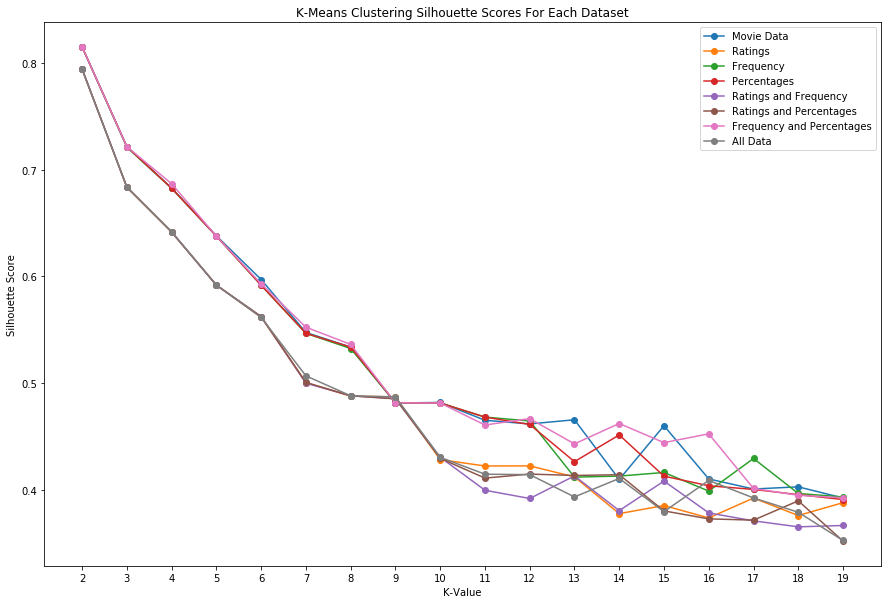

In [14]:
fig, ax = plt.subplots(figsize=(15,10))

# The different lines we're plotting
movieplot = plt.plot(range(2, len(movies_sil_scores) + 2), movies_sil_scores, 'o-', label='Movie Data')
ratingsplot = plt.plot(range(2, len(ratings_sil_scores) + 2), ratings_sil_scores, 'o-', label='Ratings')
talliesplot = plt.plot(range(2, len(tallies_sil_scores) + 2), tallies_sil_scores, 'o-', label='Frequency')
demogrpplot = plt.plot(range(2, len(demogrp_sil_scores) + 2), demogrp_sil_scores, 'o-', label='Percentages')
ratings_tallies_plot = plt.plot(range(2, len(ratings_and_tallies_sil_scores) + 2), ratings_and_tallies_sil_scores, 'o-', label='Ratings and Frequency')
ratings_demogrp_plot = plt.plot(range(2, len(ratings_and_demogrp_sil_scores) + 2), ratings_and_demogrp_sil_scores, 'o-', label='Ratings and Percentages')
tallies_demogrp_plot = plt.plot(range(2, len(tallies_and_demogrp_sil_scores) + 2), tallies_and_demogrp_sil_scores, 'o-', label='Frequency and Percentages')
allplot = plt.plot(range(2, len(all_data_sil_scores) + 2), all_data_sil_scores, 'o-', label='All Data')

# The Stylings for the plot
plt.xticks(np.arange(2, len(movies_sil_scores) + 2), range(2, len(movies_sil_scores) + 2))
plt.title('K-Means Clustering Silhouette Scores For Each Dataset')
ax.legend()
ax.set_xlabel('K-Value')
ax.set_ylabel('Silhouette Score')

# Now plot it!
plt.plot()

#### Choosing the 'best' one
It appears that the dataset with the frequency and percentages data had consistently been the highest Silhouette score before the apparent elbows around K=7 through K=11.  This will be the dataset we'll use!

## Now that we have our Optimum Dataset
Let's use the Elbow Technique to determine the best K

[]

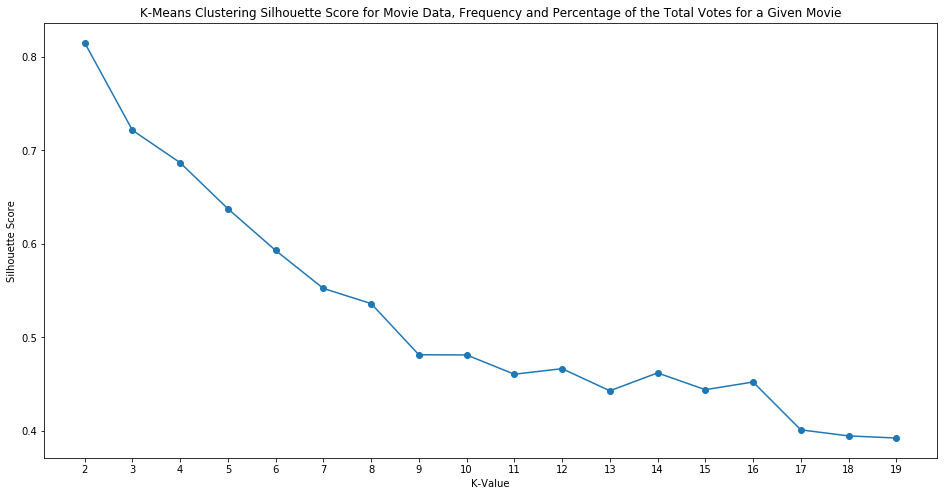

In [15]:
fig, ax = plt.subplots(figsize=(16,8))
mainplot = plt.plot(range(2, len(tallies_and_demogrp_sil_scores) + 2), tallies_and_demogrp_sil_scores, 'o-')
plt.xticks(np.arange(2, len(tallies_and_demogrp_sil_scores) + 2), range(2, len(tallies_and_demogrp_sil_scores) + 2))
plt.title('K-Means Clustering Silhouette Score for Movie Data, Frequency and Percentage of the Total Votes for a Given Movie')
ax.set_xlabel('K-Value')
ax.set_ylabel('Silhouette Score')
plt.plot()

Based on the figure above, it appears that the graph has a potential elbow at K=7 and at K=9.  While the one at K=7 has a higher Silhouette score than the one at K=9, the one at K=9 is the most well-defined cutoff.  We'll use K=9 for this one.

# Interactive Clustering Model

### Chosen K-means Clustering

In [16]:
chosen_data = create_np_data(tallies_and_demogrp)

# Create the Training Data and Testing Data
X_train, X_test = train_test_split(chosen_data, test_size=0.2, random_state=42)

In [17]:
# Setting up the K-means model
k = 9

kmeans = KMeans(n_clusters=k, n_jobs=-1, verbose=10)
y_pred = kmeans.fit(X_train)
y_test = kmeans.predict(X_train)

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


Initialization complete
Iteration 0, inertia 1.6683100075407843e+19
Iteration 1, inertia 1.1645372738049698e+19
Iteration 2, inertia 1.108438293118981e+19
Iteration 3, inertia 1.0850298749850522e+19
Iteration 4, inertia 1.0782438018285498e+19
Iteration 5, inertia 1.0747982997892936e+19
Iteration 6, inertia 1.0728143051757525e+19
Iteration 7, inertia 1.0710955301344029e+19
Iteration 8, inertia 1.0697852327367262e+19
Iteration 9, inertia 1.0682492486139423e+19
Iteration 10, inertia 1.0668061460199612e+19
Iteration 11, inertia 1.0653976440595624e+19
Iteration 12, inertia 1.063915251045039e+19
Iteration 13, inertia 1.0623692283150873e+19
Iteration 14, inertia 1.0614053701181942e+19
Iteration 15, inertia 1.0607358423517817e+19
Iteration 16, inertia 1.0600323232098865e+19
Iteration 17, inertia 1.0592158010825458e+19
Iteration 18, inertia 1.0586484848101591e+19
Iteration 19, inertia 1.0582526270297596e+19
Iteration 20, inertia 1.0578782167192404e+19
Iteration 21, inertia 1.0573867039163838e+1

Iteration 4, inertia 1.0556945624205965e+19
Iteration 5, inertia 1.0533453110845313e+19
Iteration 6, inertia 1.052078165920219e+19
Iteration 7, inertia 1.0511361901078385e+19
Iteration 8, inertia 1.0499397009899067e+19
Iteration 9, inertia 1.049137136966483e+19
Iteration 10, inertia 1.0483899238676797e+19
Iteration 11, inertia 1.04812870164579e+19
Iteration 12, inertia 1.0480861212710291e+19
Converged at iteration 12: center shift 20674486136.08076 within tolerance 59369649397.09935.
Initialization complete
Iteration 0, inertia 1.4908640676500736e+19
Iteration 1, inertia 1.184712431806365e+19
Iteration 2, inertia 1.1141381756257184e+19
Iteration 3, inertia 1.0831002464886057e+19
Iteration 4, inertia 1.0686410230001992e+19
Iteration 5, inertia 1.064606447319413e+19
Iteration 6, inertia 1.0631578623341933e+19
Iteration 7, inertia 1.0619929319494992e+19
Iteration 8, inertia 1.0599645724945736e+19
Iteration 9, inertia 1.0582421212480006e+19
Iteration 10, inertia 1.0566875069234563e+19
Iter

In [18]:
print(f"Silhouette Score: {metrics.silhouette_score(X_train, y_pred.labels_, metric='euclidean')}")
print(f"SSE: {y_pred.inertia_}")
print(f"Number of iterations: {y_pred.n_iter_}")

Silhouette Score: 0.4802597522734404
SSE: 1.0429452137155162e+19
Number of iterations: 58


In [19]:
output_notebook()
y_labels = y_test

# data sources
source = ColumnDataSource(data=dict(
    x           = X_train[:,0], 
    y           = X_train[:,1],
    x_backup    = X_train[:,0],
    y_backup    = X_train[:,1],
    desc        = y_labels, 
    titles      = movies_df['title'],
    writers     = movies_df['writer'],
    actors      = movies_df['actors'],
    description = movies_df['description'],
    length      = movies_df['duration'],
    metascore   = movies_df['metascore'],
    avg_score   = movies_df['avg_vote'],
    labels      = ["C-" + str(x) for x in y_labels]
    ))

# hover over information
hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Writer(s)", "@writers"),
    ("Actor(s)", "@actors"),
    ("Director(s)", "@actors{safe}"),
    ("Description", "@description"),
],
                 point_policy="follow_mouse")

# map colors
mapper = linear_cmap(field_name='desc', 
                     palette=Category20[20],
                     low=min(y_labels) ,high=max(y_labels))

# prepare the figure
p = figure(plot_width=800, plot_height=800, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset'], 
           title="IMDB Movie Summaries, Clustered (K-Means)", 
           toolbar_location="right")

# plot
p.scatter('x', 'y', size=5, 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          line_color="black",
          legend = 'labels')

#header
header = Div(text="""<h1>IMDB Movie Clusters</h1>""")

# show
show(column(header, widgetbox(), p))

Loading BokehJS ...

In [20]:
print(f"{tallies_and_demogrp['worldwide_income'].describe()}\n===========================================")
print(f"{tallies_and_demogrp['budget'].describe()}\n===========================================")
print(f"{tallies_and_demogrp['total_votes'].describe()}\n===========================================")
print(f"{tallies_and_demogrp['females_allages_votes_percent'].describe()}\n===========================================")

count    6.525000e+03
mean     8.869214e+07
std      1.753781e+08
min      9.500000e+01
25%      5.017653e+06
50%      2.676856e+07
75%      9.172026e+07
max      2.797801e+09
Name: worldwide_income, dtype: float64
count    6.525000e+03
mean     3.067444e+07
std      3.988107e+07
min      8.784927e+01
25%      6.000000e+06
50%      1.640000e+07
75%      3.800000e+07
max      3.560000e+08
Name: budget, dtype: float64
count    6.525000e+03
mean     9.636003e+04
std      1.676871e+05
min      1.150000e+02
25%      1.193300e+04
50%      3.826100e+04
75%      1.050580e+05
max      2.278845e+06
Name: total_votes, dtype: float64
count    6525.000000
mean        0.161994
std         0.087462
min         0.025599
25%         0.099333
50%         0.139805
75%         0.202595
max         0.621547
Name: females_allages_votes_percent, dtype: float64


As you can see from the various summary statistics above, the initial data we used doesn't contain a uniform distribution over the various scales.  Let's see if we can reduce the data to a space in which we can keep our distributions within the attributes while scaling to avoid the large SSE we initially achieved.

### t-SNE Setup
The t-SNE process, or t-distirbuted schochastic neighbor embedding, is a way to compact our movie data into a 2D map of probabilities for how likely one point is to be another points' neighbor.

In [21]:
tsne = TSNE(verbose=1, perplexity=50, method='exact', n_jobs=-1)

In [22]:
# t-SNE Call
X_embedded = tsne.fit_transform(X_train)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 5220
[t-SNE] Computed conditional probabilities for sample 2000 / 5220
[t-SNE] Computed conditional probabilities for sample 3000 / 5220
[t-SNE] Computed conditional probabilities for sample 4000 / 5220
[t-SNE] Computed conditional probabilities for sample 5000 / 5220
[t-SNE] Computed conditional probabilities for sample 5220 / 5220
[t-SNE] Mean sigma: 74105.954848
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.828885
[t-SNE] KL divergence after 1000 iterations: 0.769737


In [23]:
# Setting up the K-means model
kmeans = KMeans(n_clusters=k, n_jobs=-1, verbose=10)
y_pred = kmeans.fit(X_embedded)
y_train = y_pred
y_test = kmeans.predict(X_embedded)

Initialization complete
Iteration 0, inertia 1573745.25
Iteration 1, inertia 1261183.875
Iteration 2, inertia 1202464.0
Iteration 3, inertia 1174300.75
Iteration 4, inertia 1154567.125
Iteration 5, inertia 1142536.5
Iteration 6, inertia 1135295.5
Iteration 7, inertia 1129273.875
Iteration 8, inertia 1124395.75
Iteration 9, inertia 1119658.5
Iteration 10, inertia 1113534.875
Iteration 11, inertia 1105021.625
Iteration 12, inertia 1096987.5
Iteration 13, inertia 1090158.875
Iteration 14, inertia 1082736.5
Iteration 15, inertia 1073004.875
Iteration 16, inertia 1064755.25
Iteration 17, inertia 1060126.125
Iteration 18, inertia 1057775.875
Iteration 19, inertia 1054087.0
Iteration 20, inertia 1050876.25
Iteration 21, inertia 1048177.8125
Iteration 22, inertia 1046987.125
Iteration 23, inertia 1046352.25
Iteration 24, inertia 1046127.6875
Iteration 25, inertia 1045924.75
Converged at iteration 25: center shift 0.12458877265453339 within tolerance 0.15505439453125.
Initialization complete
It

C:\Users\jcjwg\Anaconda3\envs\PythonData\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)



Iteration 4, inertia 1052989.625
Iteration 5, inertia 1049690.0
Iteration 6, inertia 1048781.0
Iteration 7, inertia 1048371.9375
Iteration 8, inertia 1047975.5625
Iteration 9, inertia 1047539.625
Iteration 10, inertia 1047324.9375
Iteration 11, inertia 1047083.0625
Iteration 12, inertia 1046756.5
Iteration 13, inertia 1046547.6875
Iteration 14, inertia 1046378.125
Converged at iteration 14: center shift 0.07804154604673386 within tolerance 0.15505439453125.
Initialization complete
Iteration 0, inertia 1630778.5
Iteration 1, inertia 1247889.5
Iteration 2, inertia 1209963.375
Iteration 3, inertia 1198440.25
Iteration 4, inertia 1193768.5
Iteration 5, inertia 1191112.75
Iteration 6, inertia 1188279.0
Iteration 7, inertia 1185222.625
Iteration 8, inertia 1181737.875
Iteration 9, inertia 1178869.375
Iteration 10, inertia 1174116.0
Iteration 11, inertia 1169352.125
Iteration 12, inertia 1164685.875
Iteration 13, inertia 1160158.875
Iteration 14, inertia 1155409.125
Iteration 15, inertia 115

In [24]:
print(f"Silhouette Score: {metrics.silhouette_score(X_embedded, y_pred.labels_, metric='euclidean')}")
print(f"SSE: {y_pred.inertia_}")
print(f"Number of iterations: {y_pred.n_iter_}")

Silhouette Score: 0.4331132471561432
SSE: 1045649.875
Number of iterations: 13


In [25]:
output_notebook()
y_labels = y_test

# data sources
source = ColumnDataSource(data=dict(
    x           = X_embedded[:,0], 
    y           = X_embedded[:,1],
    x_backup    = X_embedded[:,0],
    y_backup    = X_embedded[:,1],
    desc        = y_labels, 
    titles      = movies_df['title'],
    writers     = movies_df['writer'],
    actors      = movies_df['actors'],
    description = movies_df['description'],
    length      = movies_df['duration'],
    metascore   = movies_df['metascore'],
    avg_score   = movies_df['avg_vote'],
    labels      = ["C-" + str(x) for x in y_labels]
    ))

# hover over information
hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Writer(s)", "@writers"),
    ("Actor(s)", "@actors"),
    ("Director(s)", "@actors{safe}"),
    ("Description", "@description"),
],
                 point_policy="follow_mouse")

# map colors
mapper = linear_cmap(field_name='desc', 
                     palette=Category20[20],
                     low=min(y_labels) ,high=max(y_labels))

# prepare the figure
p = figure(plot_width=800, plot_height=800, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset'], 
           title="t-SNE IMDB Movie Summaries, Clustered(K-Means)", 
           toolbar_location="right")

# plot
p.scatter('x', 'y', size=5, 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          line_color="black",
          legend = 'labels')

#header
header = Div(text="""<h1>IMDB Movie Clusters</h1>""")

# show
show(column(header, widgetbox(), p))

Loading BokehJS ...

We can see in the graph above that the clusters are much more well-defined after we applied the t-SNE to the dataset.

# Future Areas to Explore
If I were to explore the same data further, I would also use the SSE to determine the effectiveness of the different datasets I had created in the data preprocessing.  Exploring the effectiveness of specific vote score attribute using every variation of it (percent contribution to the score, vote count and average value) would be another avenue as well.  That one could also help lower the complexity of the clustering model without gaining SSE or losing a significant Silhouette value.  One other thing I could try is clustering based on the distance from the overall average score for each more specific attribute score (like how much does the female average vote differ from the total average vote).